#Project Overview

##Predicting Flight Delays Using Machine Learning: Classification and Regression Models on BTS Aviation Data

 **Authors:**

Ayah Batayneh 171486

Lama Emran    170190

Majd Aleyadeh 169806

>**Dataset Source:** Bureau of Transportation Statistics (BTS) TranStats


This project focuses on predicting U.S. flight delays in 2024 using real-world aviation data from the Bureau of Transportation Statistics (BTS) TranStats system. The dataset consists of 1,000,025 flight records sampled from over 7 million flights, with 34–35 operational features such as scheduled and actual times, carrier and airport identifiers, flight distance, delay causes, and cancellation information.

**The objective** is to estimate arrival delays based on known departure conditions, enabling both pre-departure forecasting and post-departure delay estimation. This approach reflects real airline operational scenarios, where understanding delay propagation is critical for planning and recovery.

To achieve this, the project adopts a two-stage machine learning framework:

- Classification to predict whether a flight will be delayed.

- Regression to estimate the duration of the delay in minutes.

More than seven models are trained for each task, ensuring robust evaluation and comparison. Overall, the project aims to uncover delay patterns, assess contributing factors, and develop predictive models that provide actionable insights for airline operations management.


# Step 1: Setup & Imports

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.6 MB/s eta 0:00:00


In [2]:
!pip install scikeras

In [232]:
import requests, zipfile, io,os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate,learning_curve
from sklearn.preprocessing import StandardScaler,PowerTransformer,RobustScaler
from category_encoders import TargetEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error,explained_variance_score,f1_score,recall_score,precision_score,accuracy_score, classification_report,roc_curve, auc,roc_auc_score, confusion_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.svm import SVR,SVC
from xgboost import XGBRegressor,XGBClassifier
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier

# Step 2: Data Loading

In [4]:
# Initialize flight delay data - download from GitHub
url= "https://github.com/MajdBa7r/Flights/releases/download/v1.0/FlightsDelayEstimation.zip"

r= requests.get(url)
z= zipfile.ZipFile(io.BytesIO(r.content))

n=z.namelist()

df= pd.read_csv(z.open(n[0]))

In [5]:
df.head()

YEAR  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE OP_UNIQUE_CARRIER  \
0  2024      1            29            1  2024-01-29                F9   
1  2024      1             8            1  2024-01-08                UA   
2  2024      1            22            1  2024-01-22                DL   
3  2024      1             1            1  2024-01-01                F9   
4  2024      1             8            1  2024-01-08                DL   

   OP_CARRIER_FL_NUM ORIGIN   ORIGIN_CITY_NAME ORIGIN_STATE_ABR  ... DIVERTED  \
0             3247.0    SJU       San Juan, PR               PR  ...      0.0   
1             2004.0    SFO  San Francisco, CA               CA  ...      0.0   
2             1596.0    LAS      Las Vegas, NV               NV  ...      0.0   
3             4714.0    DEN         Denver, CO               CO  ...      0.0   
4             1674.0    PHX        Phoenix, AZ               AZ  ...      0.0   

  CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME  AIR_TIME  DISTANCE  CARRIER_DELAY  \
0            241.0               235.0     207.0    1576.0            1.0   
1            250.0               235.0     210.0    1846.0            NaN   
2            190.0               182.0     155.0    1299.0            NaN   
3            205.0               200.0     171.0    1506.0            NaN   
4            182.0               164.0     152.0    1276.0            NaN   

   WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  LATE_AIRCRAFT_DELAY  
0            0.0        0.0             0.0                 32.0  
1            NaN        NaN             NaN                  NaN  
2            NaN        NaN             NaN                  NaN  
3            NaN        NaN             NaN                  NaN  
4            NaN        NaN             NaN                  NaN  

[5 rows x 35 columns]

In [6]:
df.tail()

YEAR  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE OP_UNIQUE_CARRIER  \
1000020  2024     12             1            7  2024-12-01                OH   
1000021  2024     12             1            7  2024-12-01                DL   
1000022  2024     12             1            7  2024-12-01                YX   
1000023  2024     12             1            7  2024-12-01                NK   
1000024  2024     12            15            7  2024-12-15                UA   

         OP_CARRIER_FL_NUM ORIGIN    ORIGIN_CITY_NAME ORIGIN_STATE_ABR  ...  \
1000020             5205.0    CLT       Charlotte, NC               NC  ...   
1000021             2075.0    SLC  Salt Lake City, UT               UT  ...   
1000022             3618.0    ORD         Chicago, IL               IL  ...   
1000023              446.0    MCO         Orlando, FL               FL  ...   
1000024             1490.0    PDX        Portland, OR               OR  ...   

        DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME  AIR_TIME  DISTANCE  \
1000020      0.0            105.0                93.0      64.0     333.0   
1000021      0.0            246.0               251.0     225.0    1927.0   
1000022      0.0            112.0               106.0      76.0     589.0   
1000023      0.0            181.0               164.0     144.0    1041.0   
1000024      0.0            229.0               217.0     198.0    1739.0   

         CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
1000020            NaN            NaN        NaN             NaN   
1000021            NaN            NaN        NaN             NaN   
1000022            NaN            NaN        NaN             NaN   
1000023            NaN            NaN        NaN             NaN   
1000024            NaN            NaN        NaN             NaN   

         LATE_AIRCRAFT_DELAY  
1000020                  NaN  
1000021                  NaN  
1000022                  NaN  
1000023                  NaN  
1000024                  NaN  

[5 rows x 35 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000025 entries, 0 to 1000024
Data columns (total 35 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 1000025 non-null  int64  
 1   MONTH                1000025 non-null  int64  
 2   DAY_OF_MONTH         1000025 non-null  int64  
 3   DAY_OF_WEEK          1000025 non-null  int64  
 4   FL_DATE              1000025 non-null  object 
 5   OP_UNIQUE_CARRIER    1000025 non-null  object 
 6   OP_CARRIER_FL_NUM    1000025 non-null  float64
 7   ORIGIN               1000025 non-null  object 
 8   ORIGIN_CITY_NAME     1000025 non-null  object 
 9   ORIGIN_STATE_ABR     1000025 non-null  object 
 10  DEST                 1000025 non-null  object 
 11  DEST_CITY_NAME       1000025 non-null  object 
 12  DEST_STATE_ABR       1000025 non-null  object 
 13  CRS_DEP_TIME         1000025 non-null  int64  
 14  DEP_TIME             986809 non-null   float64
 15

In [8]:
df.shape

(1000025, 35)

`FL_DATE` was converted to datetime for accurate time-based analysis

In [9]:
df['FL_DATE']=pd.to_datetime(df['FL_DATE'],errors='coerce')

In [414]:
X=df.drop(columns='ARR_DELAY')
y=df['ARR_DELAY'] #Arrival delay as target variable

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000025 entries, 0 to 1000024
Data columns (total 34 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   YEAR                 1000025 non-null  int64         
 1   MONTH                1000025 non-null  int64         
 2   DAY_OF_MONTH         1000025 non-null  int64         
 3   DAY_OF_WEEK          1000025 non-null  int64         
 4   FL_DATE              1000025 non-null  datetime64[ns]
 5   OP_UNIQUE_CARRIER    1000025 non-null  object        
 6   OP_CARRIER_FL_NUM    1000025 non-null  float64       
 7   ORIGIN               1000025 non-null  object        
 8   ORIGIN_CITY_NAME     1000025 non-null  object        
 9   ORIGIN_STATE_ABR     1000025 non-null  object        
 10  DEST                 1000025 non-null  object        
 11  DEST_CITY_NAME       1000025 non-null  object        
 12  DEST_STATE_ABR       1000025 non-null  object        
 1

Explore Feature Characteristics

In [12]:
X.describe().T

count                           mean  \
YEAR                 1000025.0                         2024.0   
MONTH                1000025.0                       6.590321   
DAY_OF_MONTH         1000025.0                      15.794007   
DAY_OF_WEEK          1000025.0                       3.982756   
FL_DATE                1000025  2024-07-03 20:42:43.495912960   
OP_CARRIER_FL_NUM    1000025.0                    2652.118143   
CRS_DEP_TIME         1000025.0                    1327.194101   
DEP_TIME              986809.0                    1330.832376   
DEP_DELAY             986771.0                       12.52378   
TAXI_OUT              986369.0                      18.038824   
WHEELS_OFF            986369.0                    1354.152099   
WHEELS_ON             986069.0                    1458.585017   
TAXI_IN               986069.0                       8.344335   
CRS_ARR_TIME         1000025.0                    1490.760722   
ARR_TIME              986069.0                    1462.236744   
CANCELLED            1000025.0                       0.013742   
DIVERTED             1000025.0                       0.002455   
CRS_ELAPSED_TIME     1000025.0                     143.705099   
ACTUAL_ELAPSED_TIME   983828.0                     138.229648   
AIR_TIME              983828.0                     111.861908   
DISTANCE             1000025.0                     806.323975   
CARRIER_DELAY         203515.0                      24.380011   
WEATHER_DELAY         203515.0                       4.350814   
NAS_DELAY             203515.0                      13.460693   
SECURITY_DELAY        203515.0                       0.129317   
LATE_AIRCRAFT_DELAY   203515.0                      29.622018   

                                     min                  25%  \
YEAR                              2024.0               2024.0   
MONTH                                1.0                  4.0   
DAY_OF_MONTH                         1.0                  8.0   
DAY_OF_WEEK                          1.0                  2.0   
FL_DATE              2024-01-01 00:00:00  2024-04-06 00:00:00   
OP_CARRIER_FL_NUM                    1.0               1217.0   
CRS_DEP_TIME                         1.0                910.0   
DEP_TIME                             1.0                911.0   
DEP_DELAY                          -96.0                 -6.0   
TAXI_OUT                             1.0                 12.0   
WHEELS_OFF                           1.0                927.0   
WHEELS_ON                            1.0               1043.0   
TAXI_IN                              1.0                  5.0   
CRS_ARR_TIME                         1.0               1105.0   
ARR_TIME                             1.0               1046.0   
CANCELLED                            0.0                  0.0   
DIVERTED                             0.0                  0.0   
CRS_ELAPSED_TIME                    20.0                 91.0   
ACTUAL_ELAPSED_TIME                 17.0                 86.0   
AIR_TIME                             7.0                 61.0   
DISTANCE                            31.0                373.0   
CARRIER_DELAY                        0.0                  0.0   
WEATHER_DELAY                        0.0                  0.0   
NAS_DELAY                            0.0                  0.0   
SECURITY_DELAY                       0.0                  0.0   
LATE_AIRCRAFT_DELAY                  0.0                  0.0   

                                     50%                  75%  \
YEAR                              2024.0               2024.0   
MONTH                                7.0                 10.0   
DAY_OF_MONTH                        16.0                 23.0   
DAY_OF_WEEK                          4.0                  6.0   
FL_DATE              2024-07-05 00:00:00  2024-10-01 00:00:00   
OP_CARRIER_FL_NUM                 2324.0               3960.0   
CRS_DEP_TIME                      1320.0               173

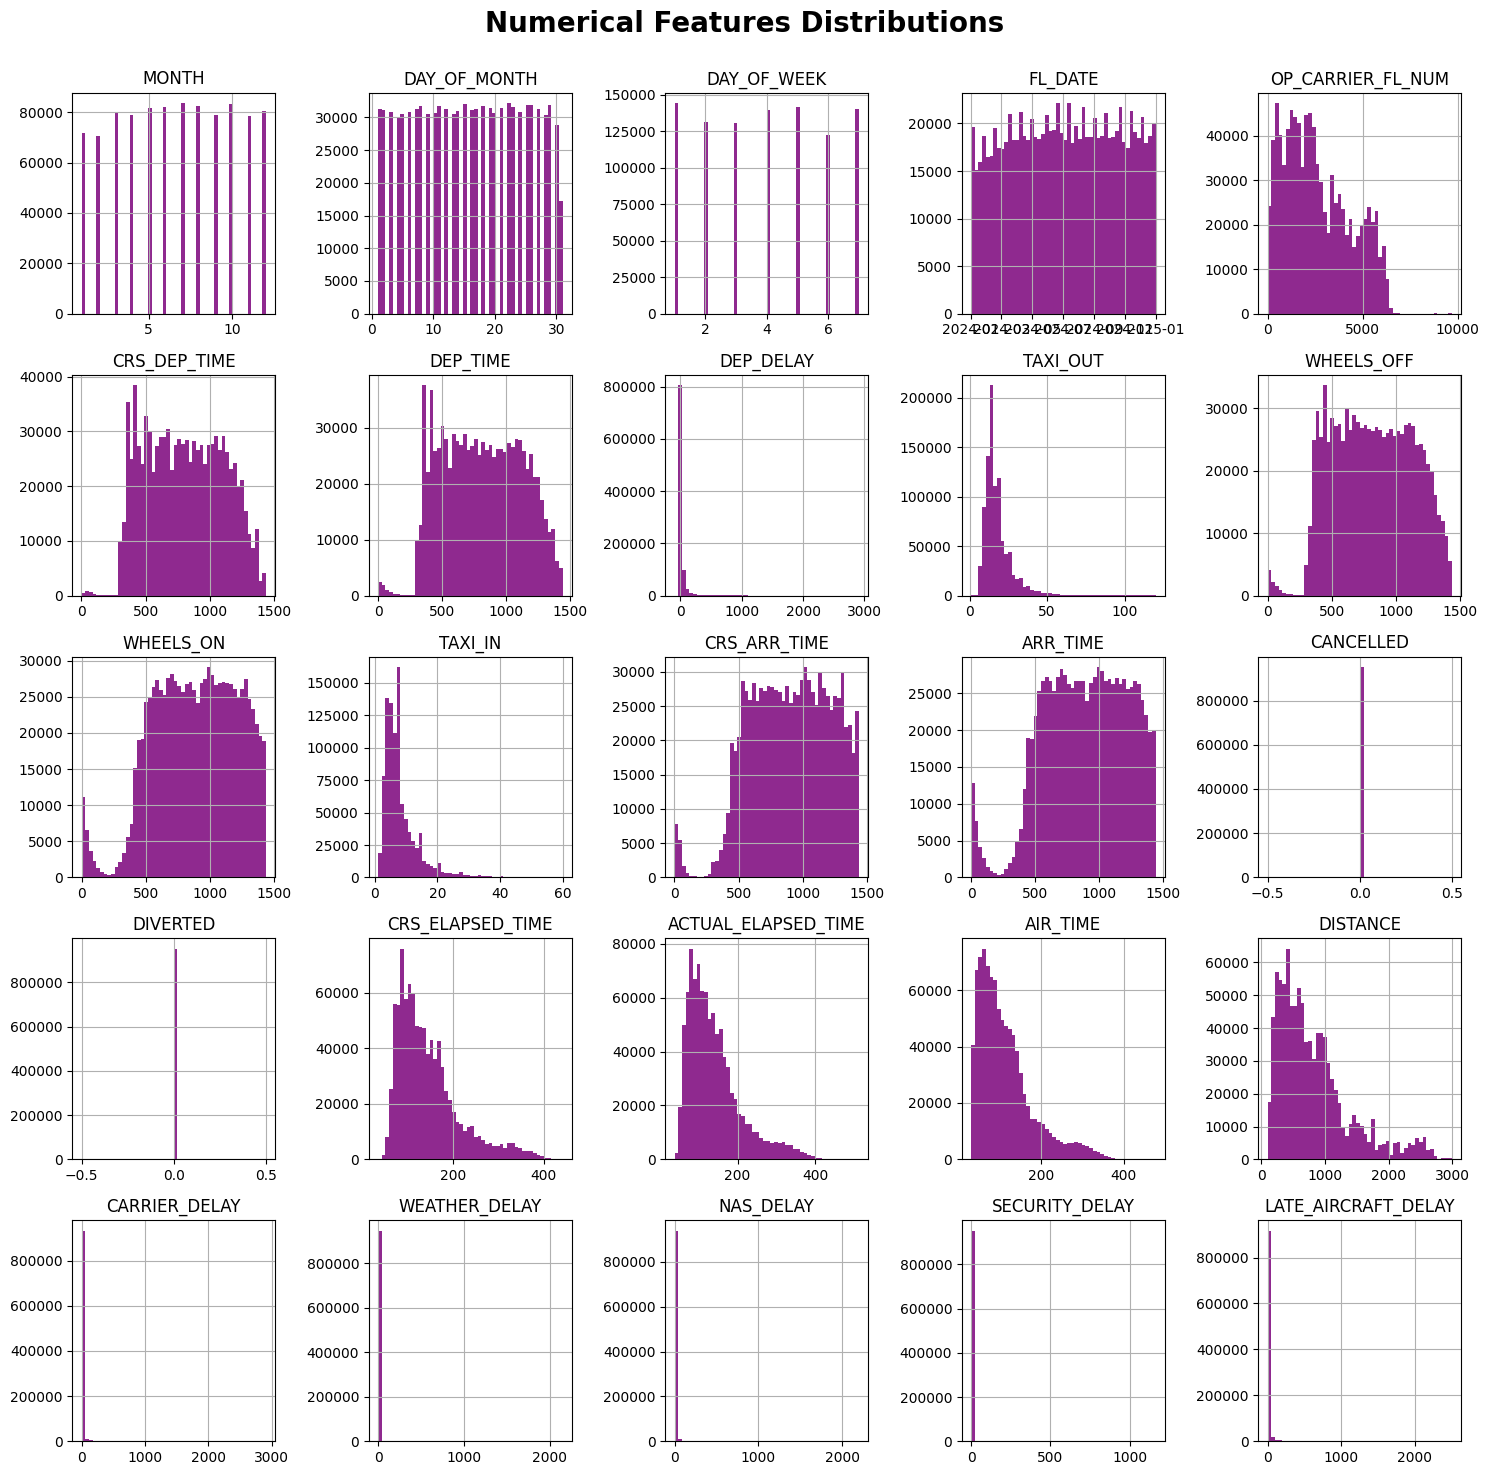

In [412]:
X.hist(figsize=(15,15),bins=50,color='#8f298f')
plt.suptitle('Numerical Features Distributions\n',size=20,fontweight='bold')
plt.tight_layout()
plt.show()

this figure shows the distributions of all numerical features revealing strong **skewness** in delay-related variables and **multimodal patterns** in scheduled and actual time features. The plots highlight the dataset’s imbalance and operational variability, emphasizing the need for **careful preprocessing** before modeling.

In [14]:
X.describe(include='object').T

count unique          top    freq
OP_UNIQUE_CARRIER  1000025     21           WN  188824
ORIGIN             1000025    359          ATL   45424
ORIGIN_CITY_NAME   1000025    353  Chicago, IL   52916
ORIGIN_STATE_ABR   1000025     52           TX  108609
DEST               1000025    359          ATL   45157
DEST_CITY_NAME     1000025    353  Chicago, IL   52509
DEST_STATE_ABR     1000025     52           TX  109234
CANCELLATION_CODE    13742      3            B    7782

# Step 3.1: Exploratory Data Analysis (EDA)

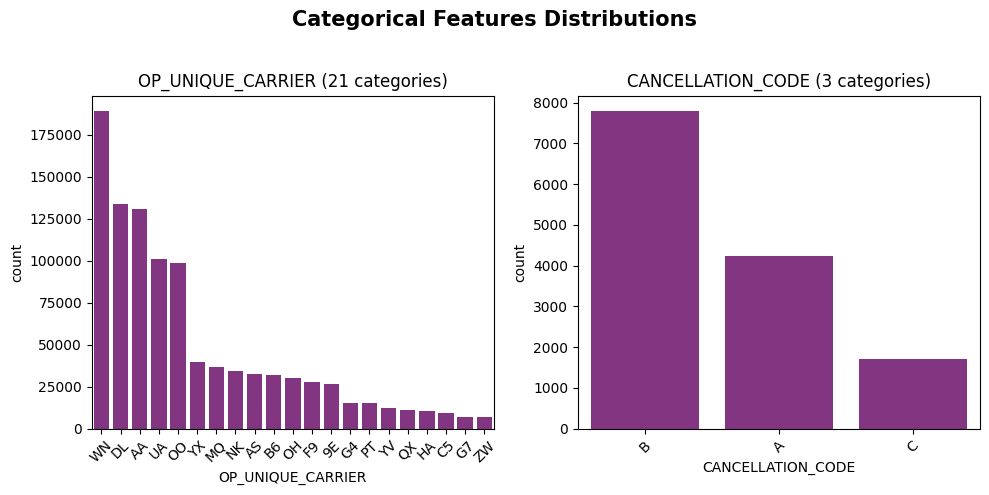

In [415]:
# Identify low-cardinality categorical columns
cat_cols = [col for col in X.select_dtypes(include='object').columns
           if X[col].nunique() < 50]

if len(cat_cols) > 0:
    n_cols = min(3, len(cat_cols))
    n_rows = (len(cat_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten() if len(cat_cols) > 1 else [axes]

    for ax, col in zip(axes, cat_cols):
        sns.countplot(x=col, data=X, ax=ax, order=X[col].value_counts().index, color='#8f298f')
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(f'{col} ({X[col].nunique()} categories)')


    for i in range(len(cat_cols), len(axes)):
        axes[i].set_visible(False)
    plt.suptitle('Categorical Features Distributions\n',size=15,fontweight='bold')
    plt.tight_layout()
    plt.show()

In [16]:
# Check missing values
X.isnull().sum()

YEAR                        0
MONTH                       0
DAY_OF_MONTH                0
DAY_OF_WEEK                 0
FL_DATE                     0
OP_UNIQUE_CARRIER           0
OP_CARRIER_FL_NUM           0
ORIGIN                      0
ORIGIN_CITY_NAME            0
ORIGIN_STATE_ABR            0
DEST                        0
DEST_CITY_NAME              0
DEST_STATE_ABR              0
CRS_DEP_TIME                0
DEP_TIME                13216
DEP_DELAY               13254
TAXI_OUT                13656
WHEELS_OFF              13656
WHEELS_ON               13956
TAXI_IN                 13956
CRS_ARR_TIME                0
ARR_TIME                13956
CANCELLED                   0
CANCELLATION_CODE      986283
DIVERTED                    0
CRS_ELAPSED_TIME            0
ACTUAL_ELAPSED_TIME     16197
AIR_TIME                16197
DISTANCE                    0
CARRIER_DELAY          796510
WEATHER_DELAY          796510
NAS_DELAY              796510
SECURITY_DELAY         796510
LATE_AIRCRAFT_DELAY    796510
dtype: int64

In [17]:
# Columns with high missingness
high_missing = [h for h in X.columns if X[h].isnull().mean() > 0.5]
high_missing

['CANCELLATION_CODE',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY']

In [18]:
# Missingness ration per column
missing_values_ratio= X.isnull().mean().sort_values(ascending=False).rename('missing_values_ratio%')
mvr=missing_values_ratio[missing_values_ratio>0]*100
mvr

CANCELLATION_CODE      98.625834
LATE_AIRCRAFT_DELAY    79.649009
NAS_DELAY              79.649009
WEATHER_DELAY          79.649009
CARRIER_DELAY          79.649009
SECURITY_DELAY         79.649009
AIR_TIME                1.619660
ACTUAL_ELAPSED_TIME     1.619660
ARR_TIME                1.395565
WHEELS_ON               1.395565
TAXI_IN                 1.395565
WHEELS_OFF              1.365566
TAXI_OUT                1.365566
DEP_DELAY               1.325367
DEP_TIME                1.321567
Name: missing_values_ratio%, dtype: float64

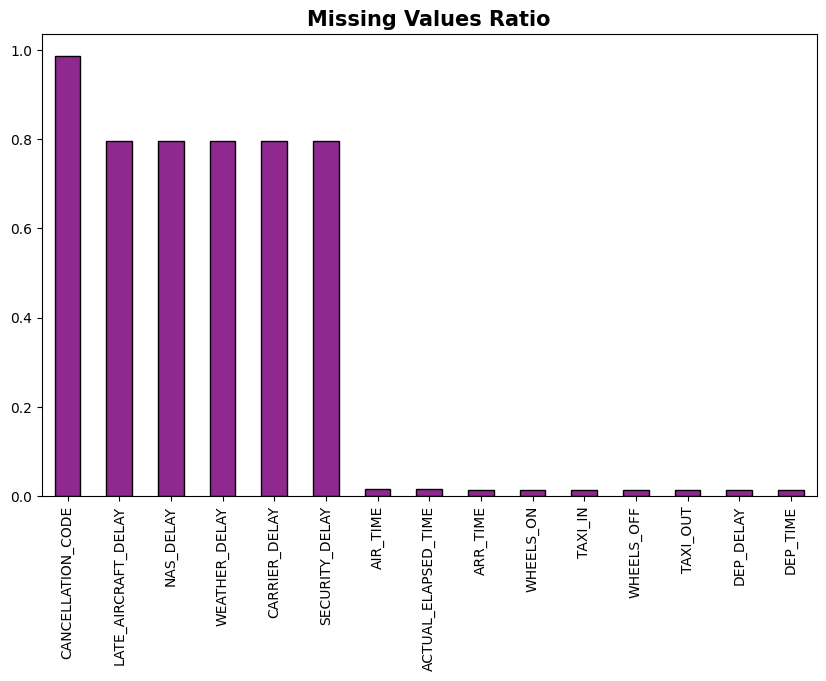

In [416]:
plt.figure(figsize=(10, 6))
missing_values_ratio[missing_values_ratio > 0].sort_values(ascending=False).plot(
        kind='bar', color='#8f298f', edgecolor='black'
    )
plt.title('Missing Values Ratio',size=15,fontweight='bold')
plt.show()

event-driven fields (e.g., CANCELLATION_CODE, LATE_AIRCRAFT_DELAY) are highly incomplete, while fundamental flight metrics (e.g., DEP_TIME, DEP_TIME) are nearly fully populated with less than 2% missing values

In [20]:
# Duplicate rows count
total_duplicates=X.duplicated().sum()
total_duplicates

np.int64(0)

There is no Duplicates

In [418]:
# Detect outliers in numerical features using IQR method
num_cols= X.select_dtypes(include=['float64', 'int64'])
Q1= num_cols.quantile(0.25)
Q3= num_cols.quantile(0.75)
IQR= Q3-Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5*IQR

Outliers=(num_cols<(lower_bound))|(num_cols>(upper_bound))
Outliers.sum().rename('Outliers Count')

YEAR                        0
MONTH                       0
DAY_OF_MONTH                0
DAY_OF_WEEK                 0
OP_CARRIER_FL_NUM         151
CRS_DEP_TIME                0
DEP_TIME                    0
DEP_DELAY              127251
TAXI_OUT                52567
WHEELS_OFF                  0
WHEELS_ON                   0
TAXI_IN                 66965
CRS_ARR_TIME                0
ARR_TIME                    0
CANCELLED               13742
DIVERTED                 2455
CRS_ELAPSED_TIME        50736
ACTUAL_ELAPSED_TIME     48535
AIR_TIME                50737
DISTANCE                56122
CARRIER_DELAY           23081
WEATHER_DELAY           12548
NAS_DELAY               15876
SECURITY_DELAY           1014
LATE_AIRCRAFT_DELAY     19819
Name: Outliers Count, dtype: int64

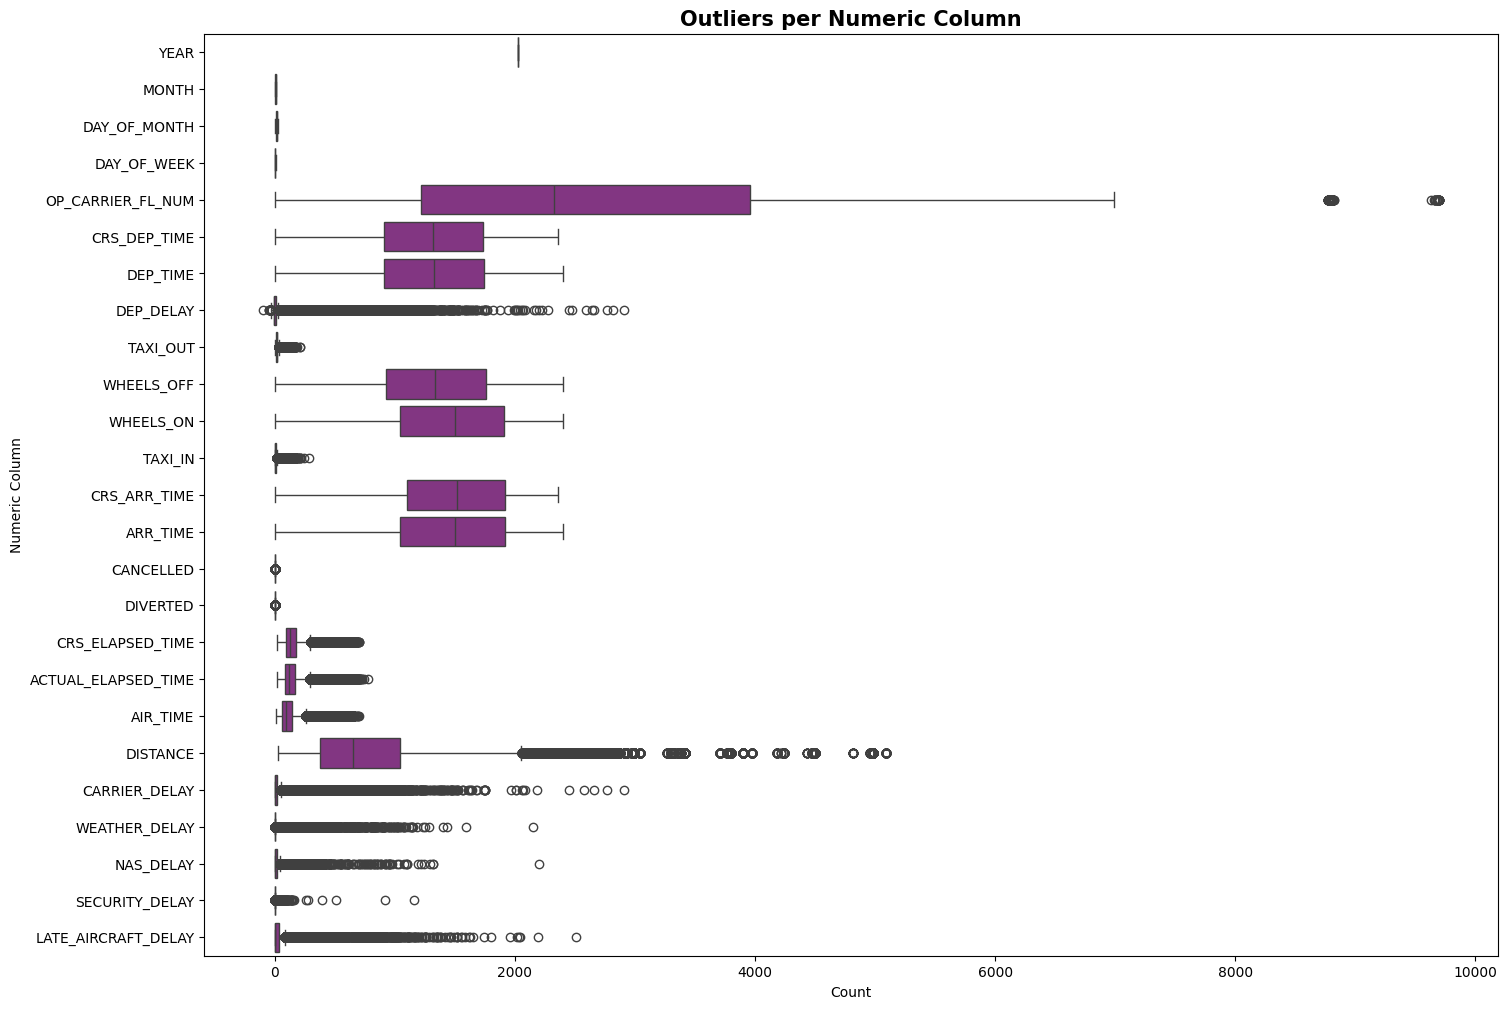

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=num_cols,color='#8f298f',orient='h')
plt.title('Outliers per Numeric Column',size=15,fontweight='bold')
plt.tight_layout()
plt.xlabel('Count')
plt.ylabel('Numeric Column')
plt.show()

The distribution of outliers across all of the dataset's numerical columns is shown in this plot.  Each horizontal boxplot displays the range of values for a particular feature; extreme outliers are represented by points that extend well beyond the whiskers.  A considerable number of outliers are present in features like dep-delay, delays, and scheduled/actual times, underscoring the broad variability and erratic behavior commonly observed in flight delay data.

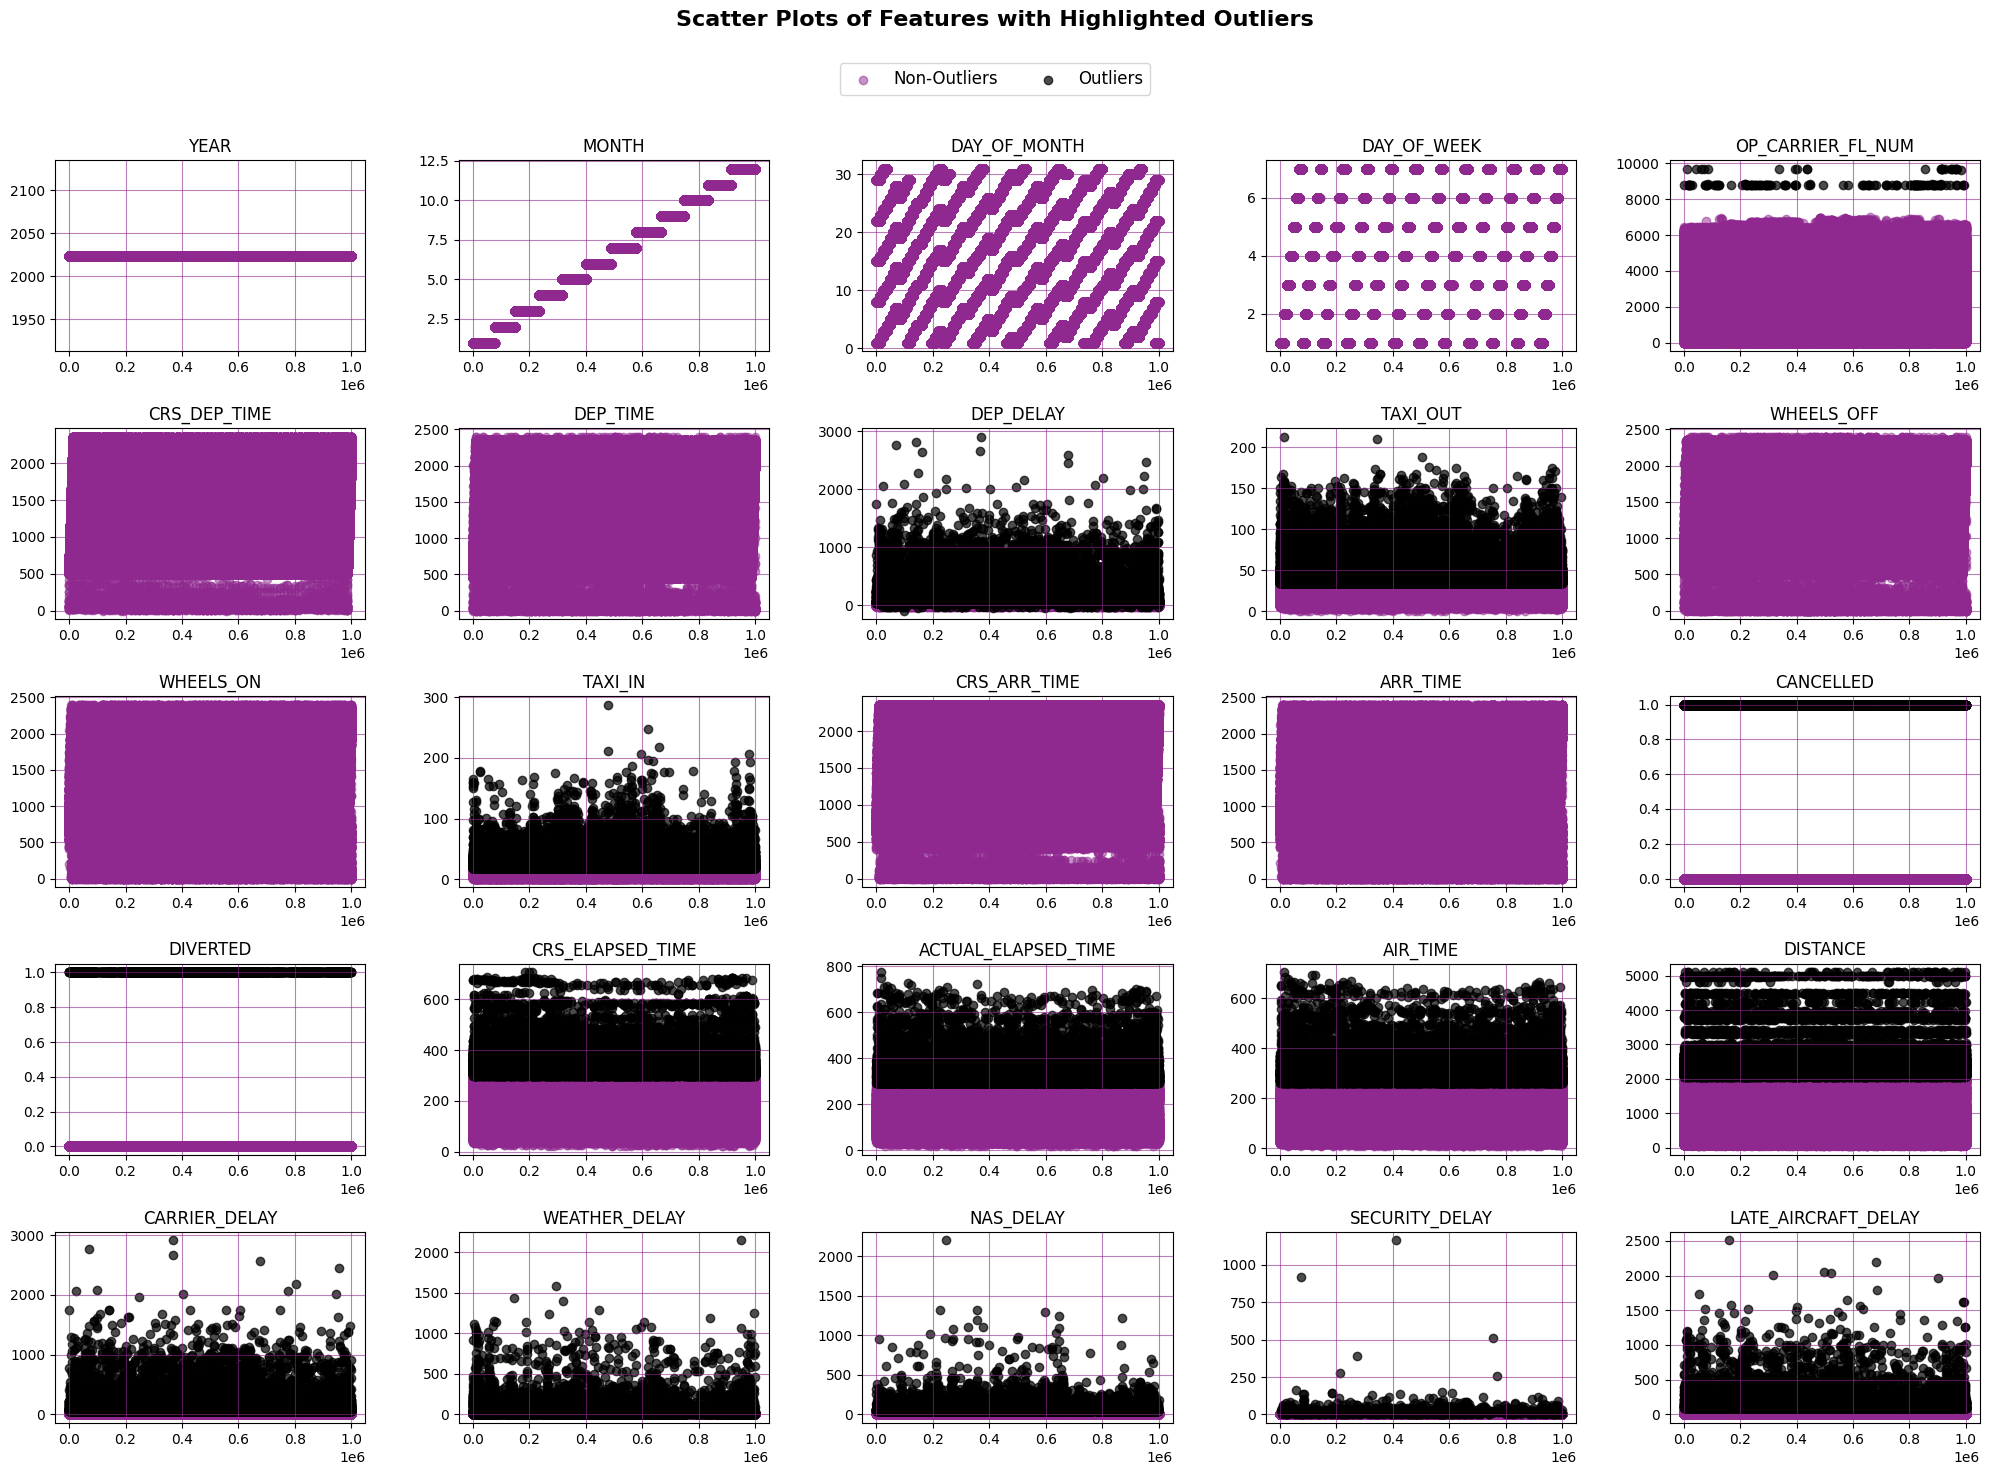

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(20, 15))
ax = ax.flatten()

for i, col in enumerate(num_cols.columns):

    Min = Q1[col] - 1.5 * IQR[col]
    Max = Q3[col] + 1.5 * IQR[col]
    out = num_cols[(num_cols[col] > Max) | (num_cols[col] < Min)]
    non_out = num_cols[(num_cols[col] <= Max) & (num_cols[col] >= Min)]

    ax[i].scatter(non_out.index, non_out[col], color='#8f298f', alpha=0.5, label='Non-Outliers')
    ax[i].scatter(out.index, out[col], color='k', alpha=0.7, label='Outliers')
    ax[i].set_title(f'{col}', fontsize=12)
    ax[i].grid(color='#8f298f', alpha=0.6)

for j in range(len(num_cols.columns), len(ax)):   # This line is to remove unused subplots
    fig.delaxes(ax[j])

plt.tight_layout()
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.95))

plt.subplots_adjust(top=0.88, hspace=0.4, wspace=0.3)

# Add title for the entire figure
fig.suptitle('Scatter Plots of Features with Highlighted Outliers', fontsize=16, weight='bold')

plt.show()

In [24]:
# Calculate the skewness for each numerical feature
num_cols.skew().sort_values(ascending=False).rename('Skewness')

SECURITY_DELAY         163.047896
DIVERTED                20.108352
WEATHER_DELAY           18.039149
NAS_DELAY               11.439186
DEP_DELAY               11.110790
CARRIER_DELAY           10.247300
CANCELLED                8.353776
LATE_AIRCRAFT_DELAY      7.889590
TAXI_IN                  4.974992
TAXI_OUT                 3.418006
DISTANCE                 1.503931
AIR_TIME                 1.447353
CRS_ELAPSED_TIME         1.438219
ACTUAL_ELAPSED_TIME      1.416097
OP_CARRIER_FL_NUM        0.428355
CRS_DEP_TIME             0.079549
DEP_TIME                 0.028417
DAY_OF_WEEK              0.006004
YEAR                     0.000000
DAY_OF_MONTH            -0.004672
WHEELS_OFF              -0.009096
MONTH                   -0.028606
CRS_ARR_TIME            -0.271351
WHEELS_ON               -0.326639
ARR_TIME                -0.367485
Name: Skewness, dtype: float64

The skewness values reveal a clear pattern: features representing rare events (like delays and diverted) are extremely right-skewed, while routine operational metrics show more normal distributions.

In [25]:
skewness=num_cols.skew().rename('Skewness')
skewness=skewness[skewness>1].sort_values(ascending=False)
skewness

SECURITY_DELAY         163.047896
DIVERTED                20.108352
WEATHER_DELAY           18.039149
NAS_DELAY               11.439186
DEP_DELAY               11.110790
CARRIER_DELAY           10.247300
CANCELLED                8.353776
LATE_AIRCRAFT_DELAY      7.889590
TAXI_IN                  4.974992
TAXI_OUT                 3.418006
DISTANCE                 1.503931
AIR_TIME                 1.447353
CRS_ELAPSED_TIME         1.438219
ACTUAL_ELAPSED_TIME      1.416097
Name: Skewness, dtype: float64

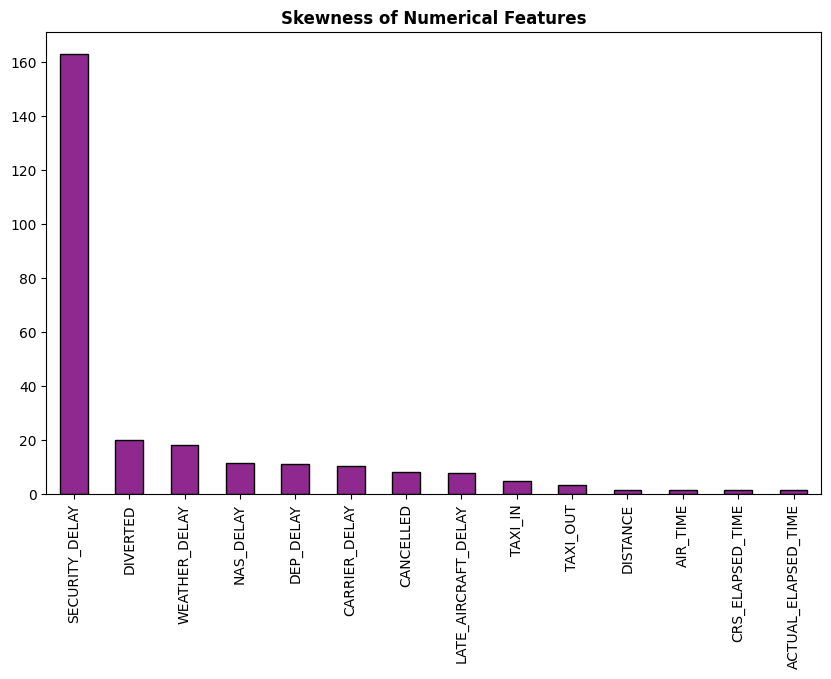

In [26]:
# Plot skewness count
plt.figure(figsize=(10, 6))
skewness.plot(kind='bar',color='#8f298f',edgecolor='#000000')
plt.title('Skewness of Numerical Features',fontweight='bold')
plt.show()

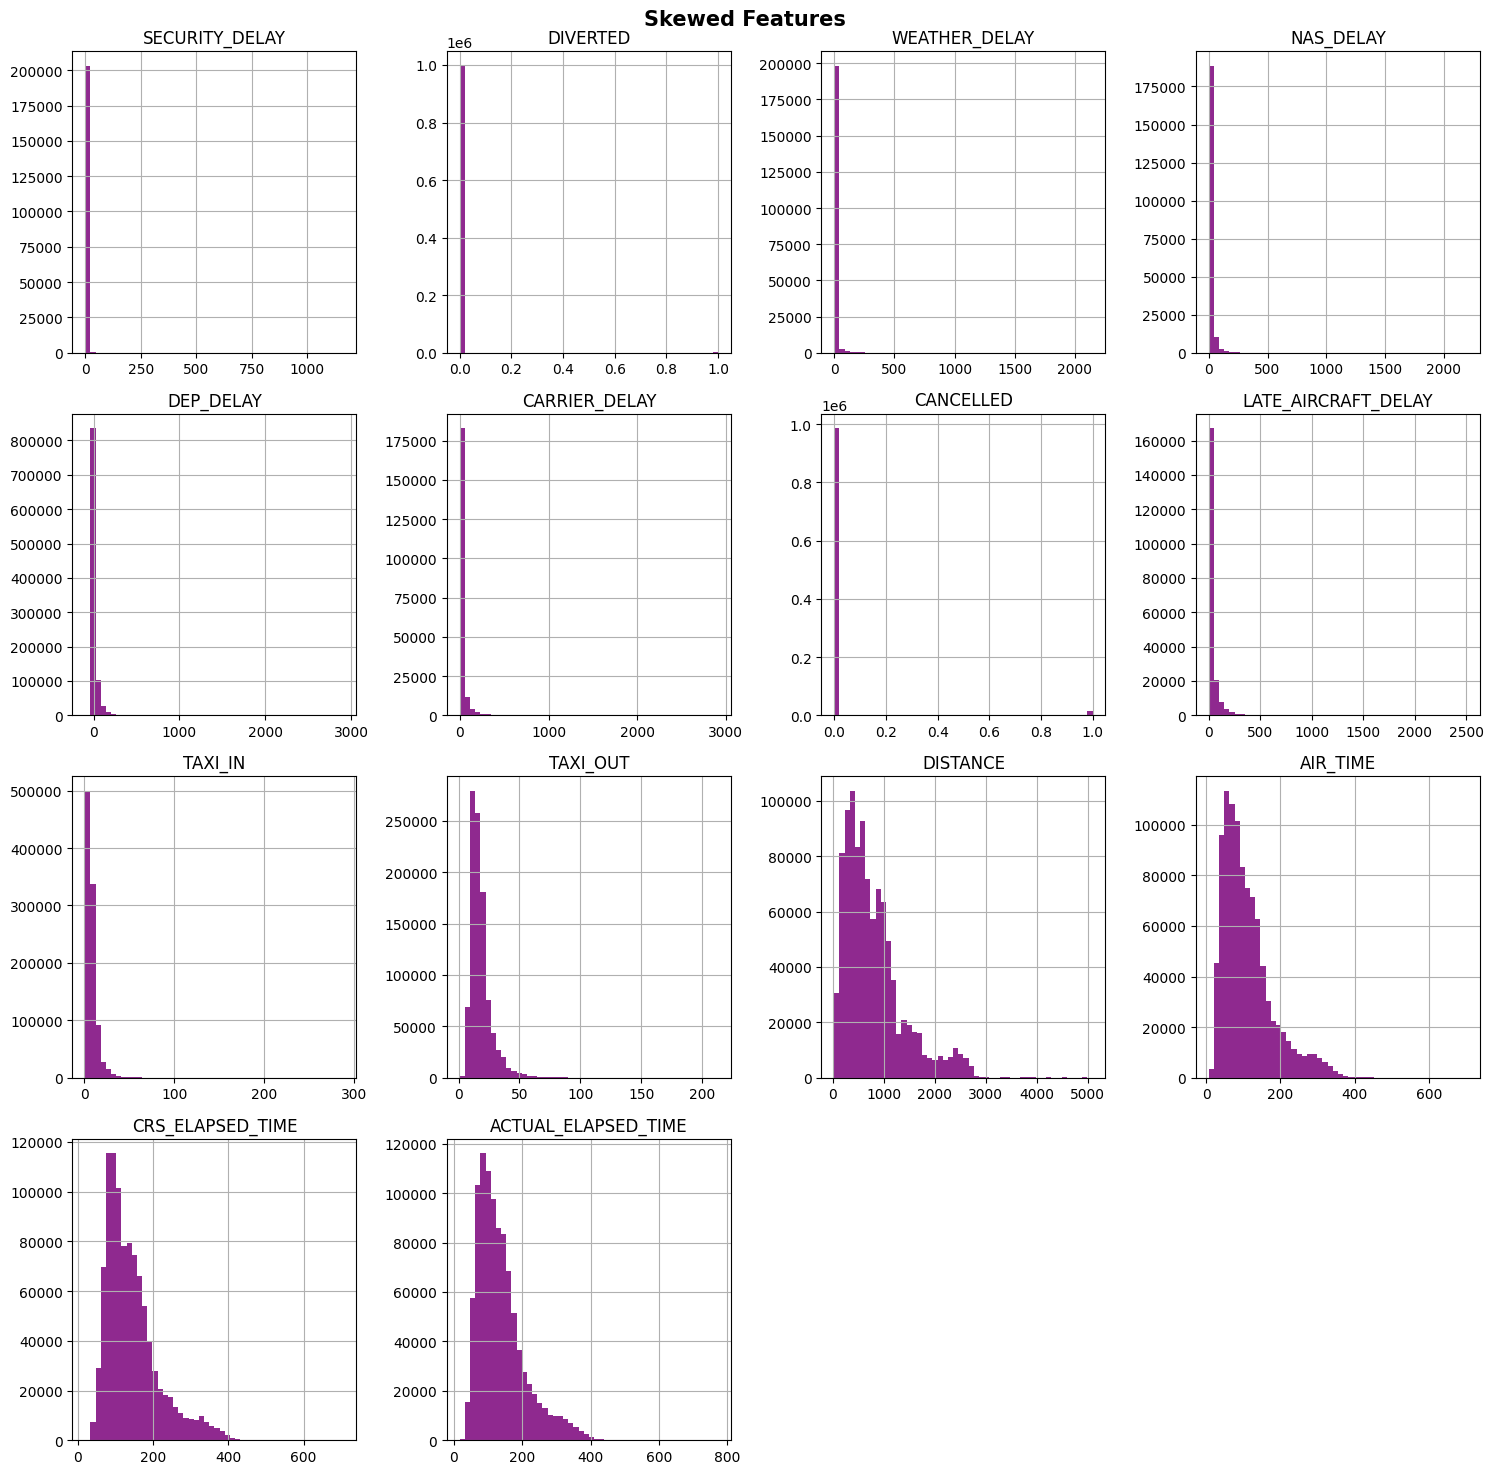

In [ ]:
X[skewness.index].hist(figsize=(15,15),bins=50,color='#8f298f')
plt.suptitle('Skewed Features',size=15,fontweight='bold')
plt.tight_layout()
plt.show()

All delay-related numerical features show a pronounced right-skewed distribution. The majority of flights have zero or minimal delay, while only a small number experience extremely high delays, resulting in a long right tail. This is typical in flight delay datasets where delays are rare but can be severe when they occur

In [28]:
# Compute Pearson correlations for numerical columns
corr_matrix = X.corr(numeric_only=True)
corr_matrix

YEAR     MONTH  DAY_OF_MONTH  DAY_OF_WEEK  \
YEAR                  NaN       NaN           NaN          NaN   
MONTH                 NaN  1.000000      0.005276     0.009863   
DAY_OF_MONTH          NaN  0.005276      1.000000     0.014613   
DAY_OF_WEEK           NaN  0.009863      0.014613     1.000000   
OP_CARRIER_FL_NUM     NaN  0.029079      0.004111    -0.002093   
CRS_DEP_TIME          NaN -0.002287      0.001555     0.005169   
DEP_TIME              NaN -0.004932      0.002569     0.004764   
DEP_DELAY             NaN -0.024990      0.008163     0.016786   
TAXI_OUT              NaN  0.002715     -0.003304    -0.001564   
WHEELS_OFF            NaN -0.004855      0.002350     0.003887   
WHEELS_ON             NaN -0.003631      0.000390    -0.002078   
TAXI_IN               NaN  0.017182     -0.000153     0.012634   
CRS_ARR_TIME          NaN -0.005757     -0.000228    -0.000878   
ARR_TIME              NaN -0.003523      0.000152    -0.003288   
CANCELLED             NaN -0.030669     -0.007463     0.001716   
DIVERTED              NaN -0.003594      0.001894    -0.000519   
CRS_ELAPSED_TIME      NaN -0.010461     -0.000228     0.006392   
ACTUAL_ELAPSED_TIME   NaN -0.012024     -0.000157     0.006732   
AIR_TIME              NaN -0.014413      0.000345     0.005848   
DISTANCE              NaN -0.006984     -0.000201     0.007316   
CARRIER_DELAY         NaN  0.005715      0.004216     0.005705   
WEATHER_DELAY         NaN -0.015884      0.004761    -0.011682   
NAS_DELAY             NaN -0.019792     -0.009700    -0.009110   
SECURITY_DELAY        NaN -0.005381      0.000200    -0.001504   
LATE_AIRCRAFT_DELAY   NaN -0.016986      0.008136     0.002646   

                     OP_CARRIER_FL_NUM  CRS_DEP_TIME  DEP_TIME  DEP_DELAY  \
YEAR                               NaN           NaN       NaN        NaN   
MONTH                         0.029079     -0.002287 -0.004932  -0.024990   
DAY_OF_MONTH                  0.004111      0.001555  0.002569   0.008163   
DAY_OF_WEEK                  -0.002093      0.005169  0.004764   0.016786   
OP_CARRIER_FL_NUM             1.000000      0.022310  0.024688  -0.015881   
CRS_DEP_TIME                  0.022310      1.000000  0.945638   0.098698   
DEP_TIME                      0.024688      0.945638  1.000000   0.122164   
DEP_DELAY                    -0.015881      0.098698  0.122164   1.000000   
TAXI_OUT                      0.094677      0.020859  0.030210   0.051347   
WHEELS_OFF                    0.034238      0.912325  0.964308   0.111031   
WHEELS_ON                     0.020206      0.620938  0.652842   0.020330   
TAXI_IN                       0.006228     -0.018620 -0.015016   0.020528   
CRS_ARR_TIME                  0.013088      0.699135  0.702492   0.080625   
ARR_TIME                      0.025050      0.586807  0.617324   0.012714   
CANCELLED                     0.004236      0.019068  0.010397   0.025966   
DIVERTED                      0.002451     -0.000153  0.001659   0.018244   
CRS_ELAPSED_TIME             -0.365914     -0.014522 -0.020793   0.019480   
ACTUAL_ELAPSED_TIME          -0.361185     -0.010946 -0.015234   0.025873   
AIR_TIME                     -0.384280     -0.012321 -0.018368   0.017376   
DISTANCE                     -0.398102     -0.007321 -0.015763   0.017219   
CARRIER_DELAY                 0.011005     -0.059430 -0.067293   0.657850   
WEATHER_DELAY                 0.048095     -0.006496 -0.023972   0.288815   
NAS_DELAY                    -0.014135     -0.046961 -0.035192   0.089925   
SECURITY_DELAY               -0.001884      0.004333  0.001935   0.028184   
LATE_AIRCRAFT_DELAY           0.006308      0.085043  0.097195   0.594053   

                     TAXI_OUT  WHEELS_OFF  ...  DIVERTED  CRS_ELAPSED_TIME  \
YEAR                      NaN         NaN  ...       NaN               NaN   
MONTH                0.002715   -0.004855  ... -0.003594         -0.010461   
DAY_OF_MONTH        -0.003304    0.002350  ...  0.001894         -0

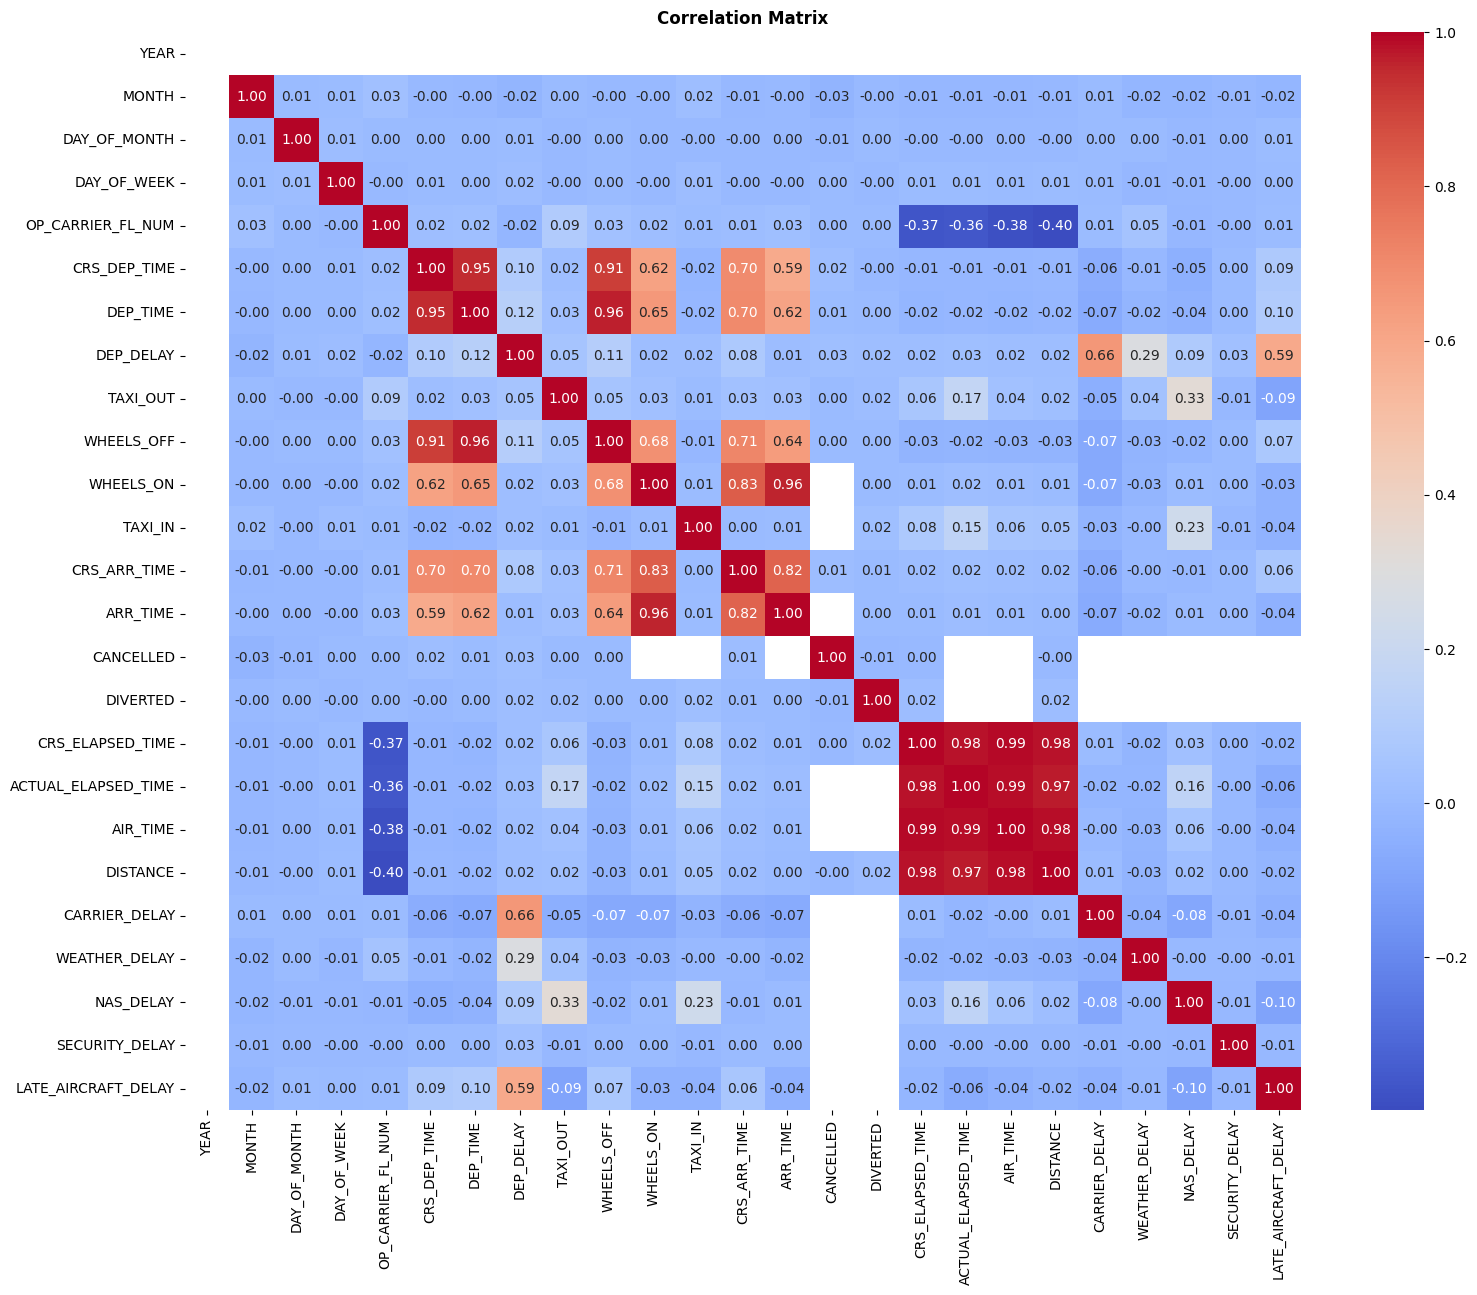

In [ ]:
# Generate correlation heatmap for feature relationship analysis
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',  fmt=".2f")
plt.title('Correlation Matrix',fontweight='bold')
plt.show()
# White cells -> NaN correlations due to high missing values

The heatmap shows strong correlations between **time-related variables** (like ARR_TIME, CRS_ARR_TIME, WHEELS_ON/OFF, AIR_TIME, ELAPSED_TIME), meaning these features **move together and contain similar information**. In contrast, delay types and date-related features have **weak** correlations with most variables, indicating they b**ehave more independently.**

In [30]:
# Identify Constant Features
constant_cols = [c for c in num_cols.columns if num_cols[c].nunique() == 1]
print("constant columns", constant_cols) #then we should remove non-informative columns

constant columns ['YEAR']


In [31]:
X.drop(columns=constant_cols,inplace=True)

In [32]:
# Detect Highly Correlated Features (>0.9) for Multicollinearity Reduction
correlation_matrix = num_cols.corr()
threshold = 0.9
high_corr = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr.add(colname)
print("High Correlated Features:", len(high_corr),high_corr)

High Correlated Features: 6 {'AIR_TIME', 'DISTANCE', 'WHEELS_OFF', 'DEP_TIME', 'ARR_TIME', 'ACTUAL_ELAPSED_TIME'}


The analysis identified 6 features with extremely high correlation (>0.9) that should **be removed to avoid multicollinearity issues**

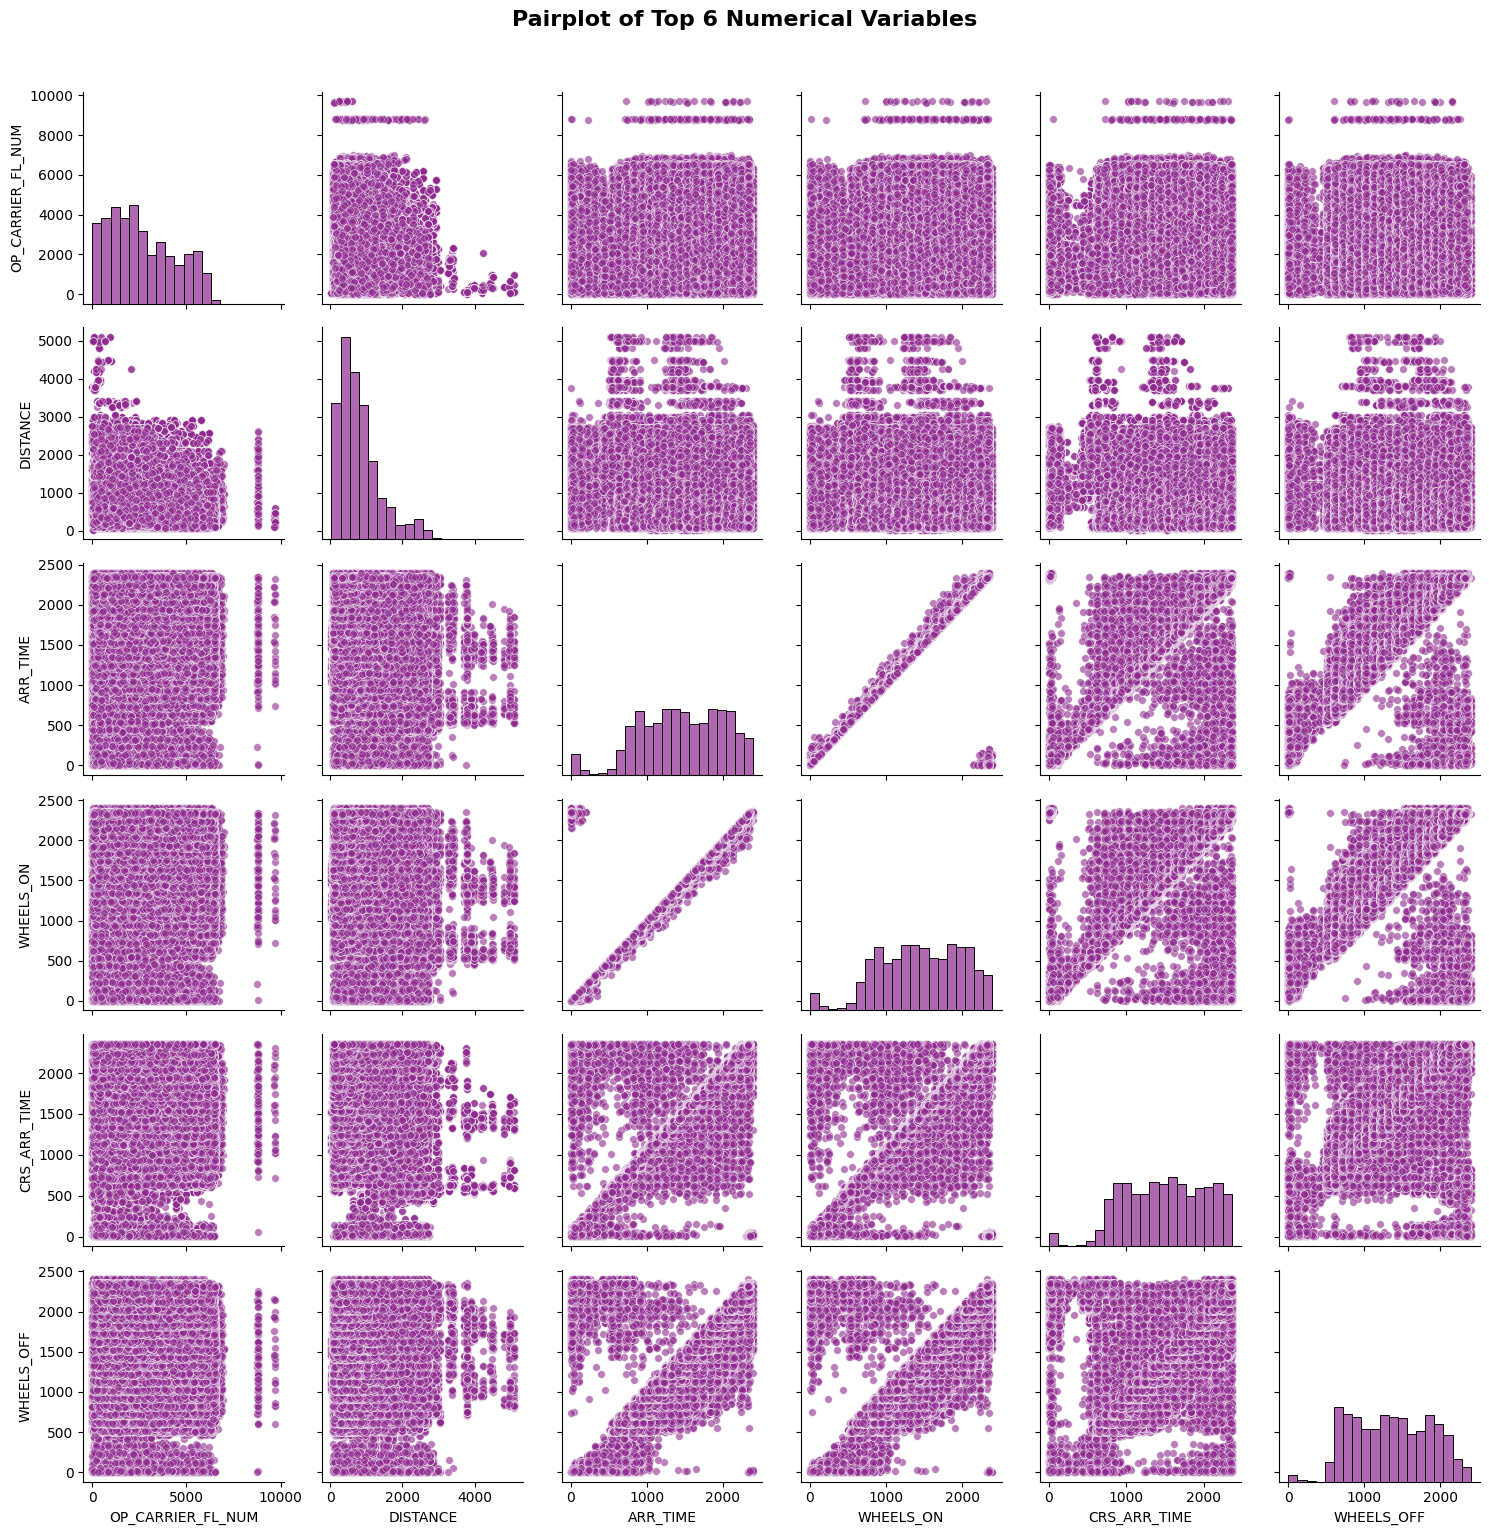

In [ ]:
# Pairwise Relationships using scatter plot
top_6_cols = num_cols.var().nlargest(6).index
sns.pairplot(X[top_6_cols],
             diag_kind='hist',
             plot_kws={'alpha': 0.6, 's': 30, 'color': '#8f298f'},
             diag_kws={'alpha': 0.7, 'bins': 20,'color': '#8f298f'})
plt.suptitle('Pairplot of Top 6 Numerical Variables', y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

The pairplot highlights **clear linear** relationships among flight-timing variables (such as ARR_TIME, CRS_ARR_TIME, WHEELS_ON, WHEELS_OFF), while OP_CARRIER_FL_NUM and DISTANCE show **no strong visual patterns** with the others. Overall, timing variables dominate the structure, suggesting multicollinearity.

# Step 3.2: Visualization of Arrival Delays and Delayed Flights

In [34]:
X['IS_DELAYED']=(y>15).astype(int)
Xy=X.copy()
Xy['Arrival Delay in Minutes'] = y
y_classification= X['IS_DELAYED']
X.drop(columns='IS_DELAYED',inplace=True)

In [35]:
y_classification.value_counts()

IS_DELAYED
0    802914
1    197111
Name: count, dtype: int64

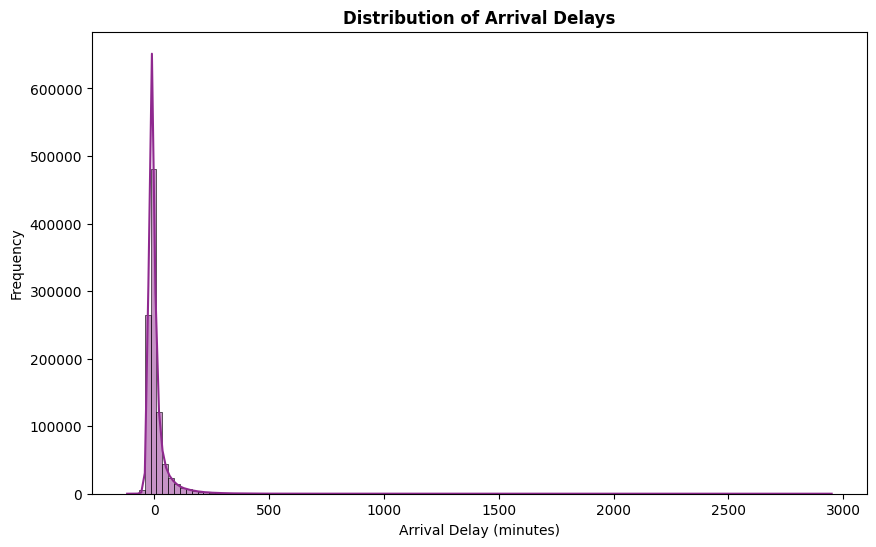

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(x=y, kde=True, bins=120,color='#8f298f')
plt.title('Distribution of Arrival Delays',fontweight='bold')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

The distribution is heavily right-skewed, meaning most flights arrive on time or with small delays, while a small number of flights experience extremely large delays. This long tail suggests the presence of significant outliers and irregular extreme delay events.

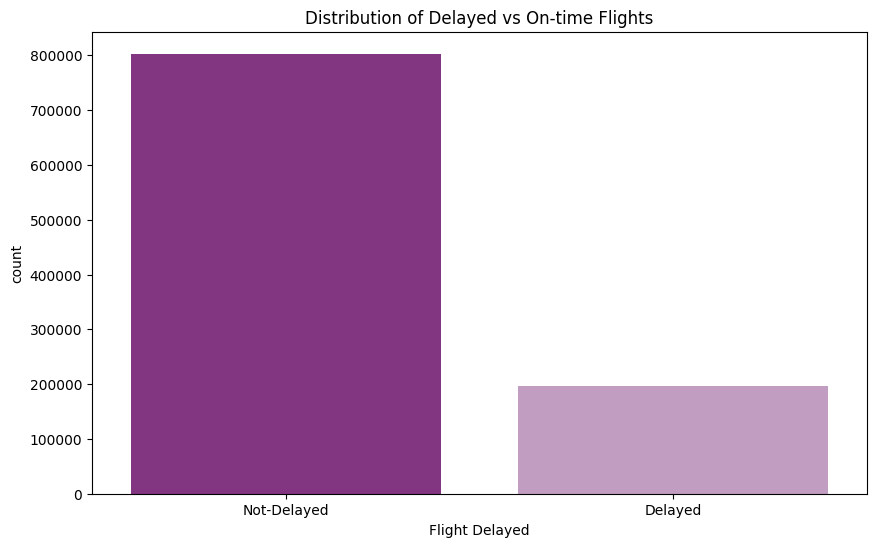

In [292]:
plt.figure(figsize=(10, 6))
sns.countplot(x='IS_DELAYED', data=Xy,palette=['#8f298f','#c897c8'])
plt.xlabel('Flight Delayed')
plt.title('Distribution of Delayed vs On-time Flights')
plt.xticks([0, 1], ['Not-Delayed', 'Delayed'])
plt.show()

In [38]:
ontime_flights_per = len(Xy[Xy['IS_DELAYED'] == 0])/Xy.shape[0]
delayed_flights_per= len(Xy[Xy['IS_DELAYED'] == 1])/Xy.shape[0]

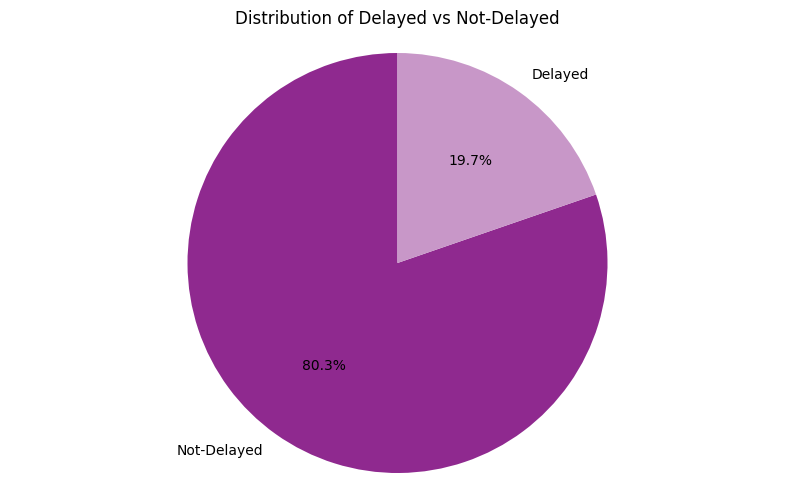

In [293]:
plt.figure(figsize=(10, 6))
plt.pie(x=[ontime_flights_per, delayed_flights_per],
        labels=['Not-Delayed', 'Delayed'],
        colors=['#8f298f', '#c897c8'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Distribution of Delayed vs Not-Delayed')
plt.axis('equal')
plt.show()

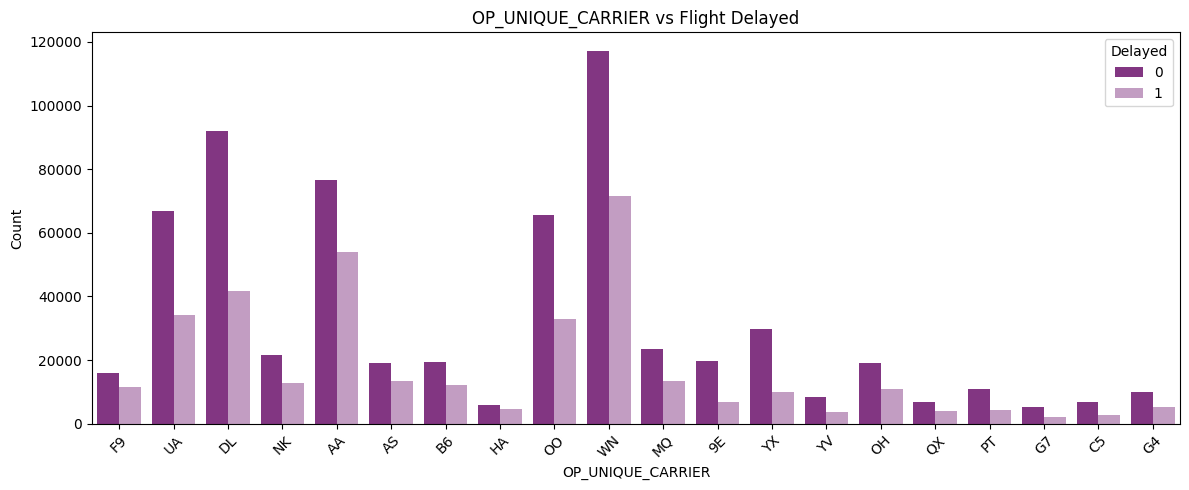

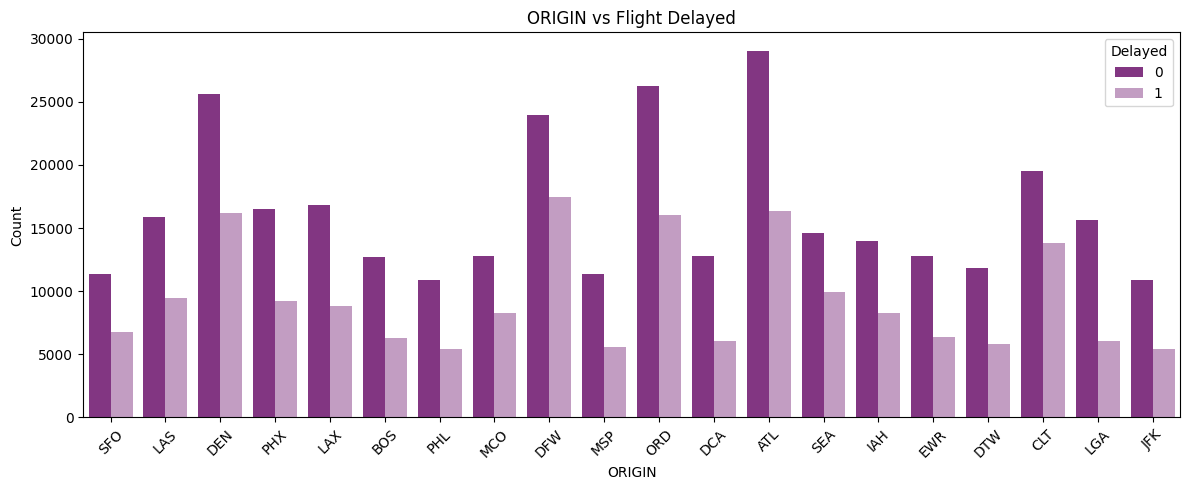

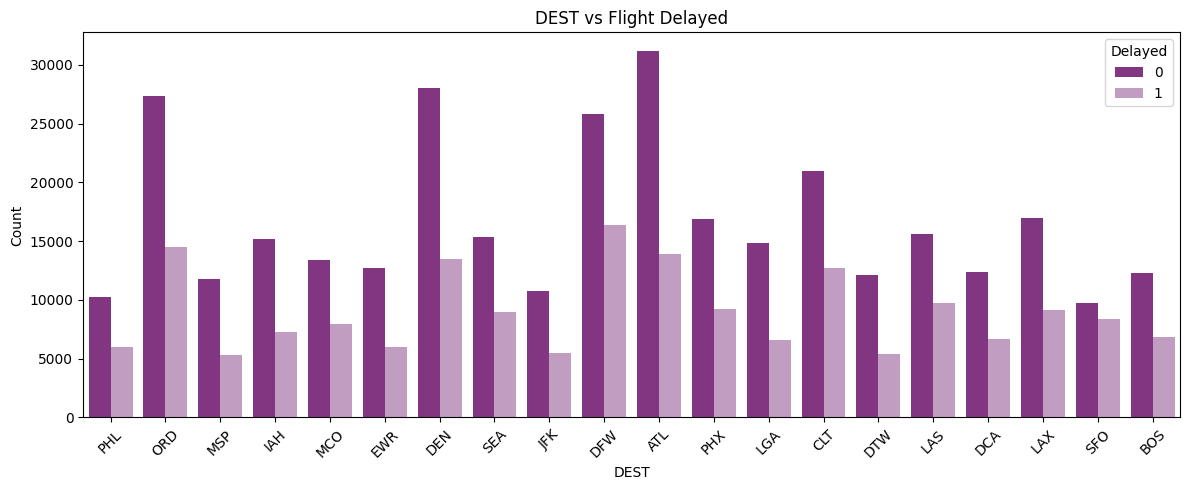

In [ ]:
categorical_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']

for col in categorical_cols:
    plt.figure(figsize=(12,5))
    top20 = Xy[col].value_counts().index[:20]
    sns.countplot(x=col, hue='IS_DELAYED', data=Xy[Xy[col].isin(top20)],palette=['#8f298f','#c897c8'])
    plt.xticks(rotation=45)
    plt.title(f'{col} vs Flight Delayed')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Delayed')
    plt.tight_layout()
    plt.show()

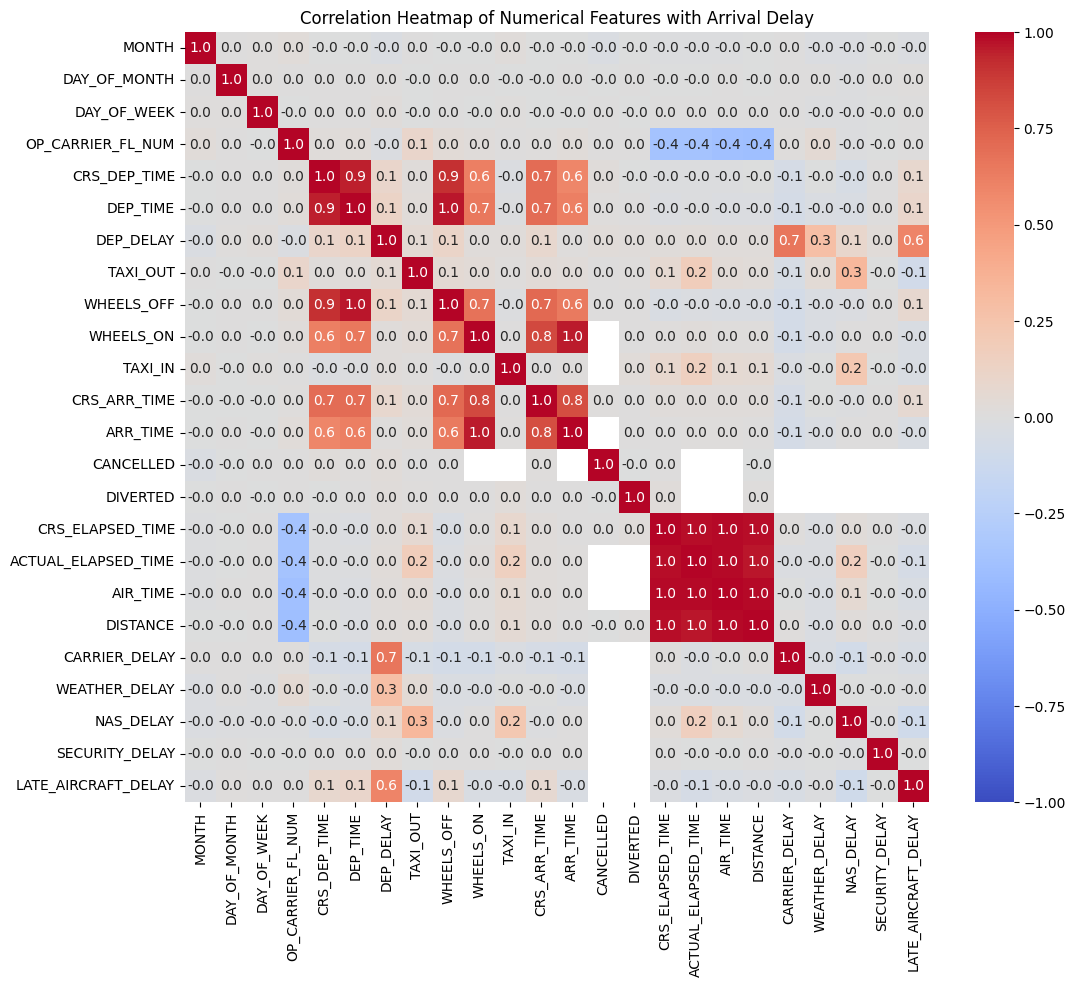

In [ ]:
numeric_cols =X.select_dtypes(include=['int64','float64']).columns.tolist()

corr_matrix = X[numeric_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features with Arrival Delay')
plt.show()

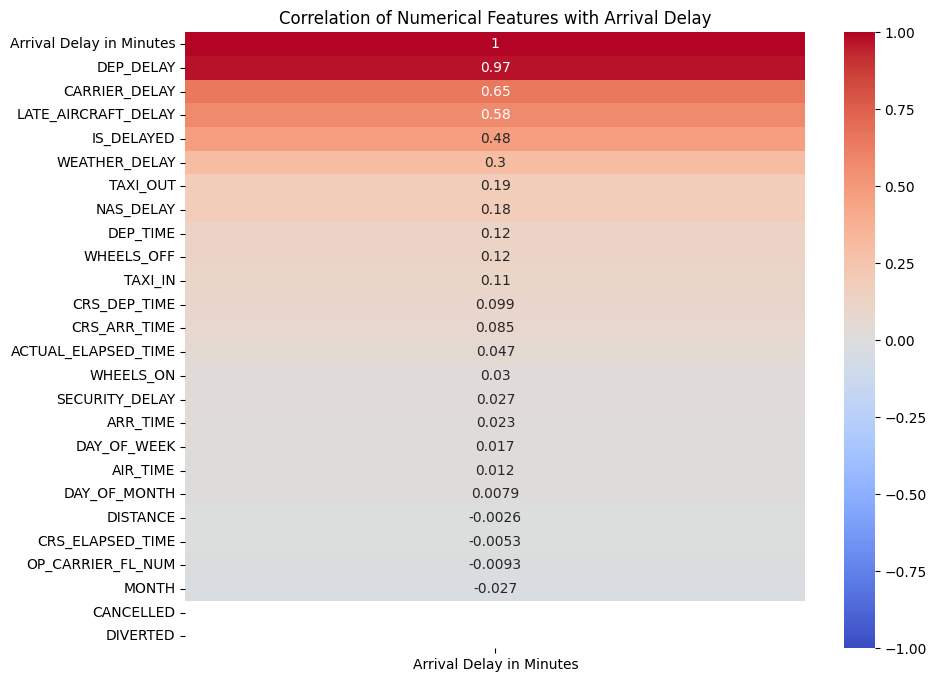

In [ ]:
numeric_cols = Xy.select_dtypes(include=['int64','float64']).columns.tolist()

plt.figure(figsize=(10,8))
sns.heatmap(Xy[numeric_cols].corr()[['Arrival Delay in Minutes']].sort_values('Arrival Delay in Minutes', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Numerical Features with Arrival Delay')
plt.show()

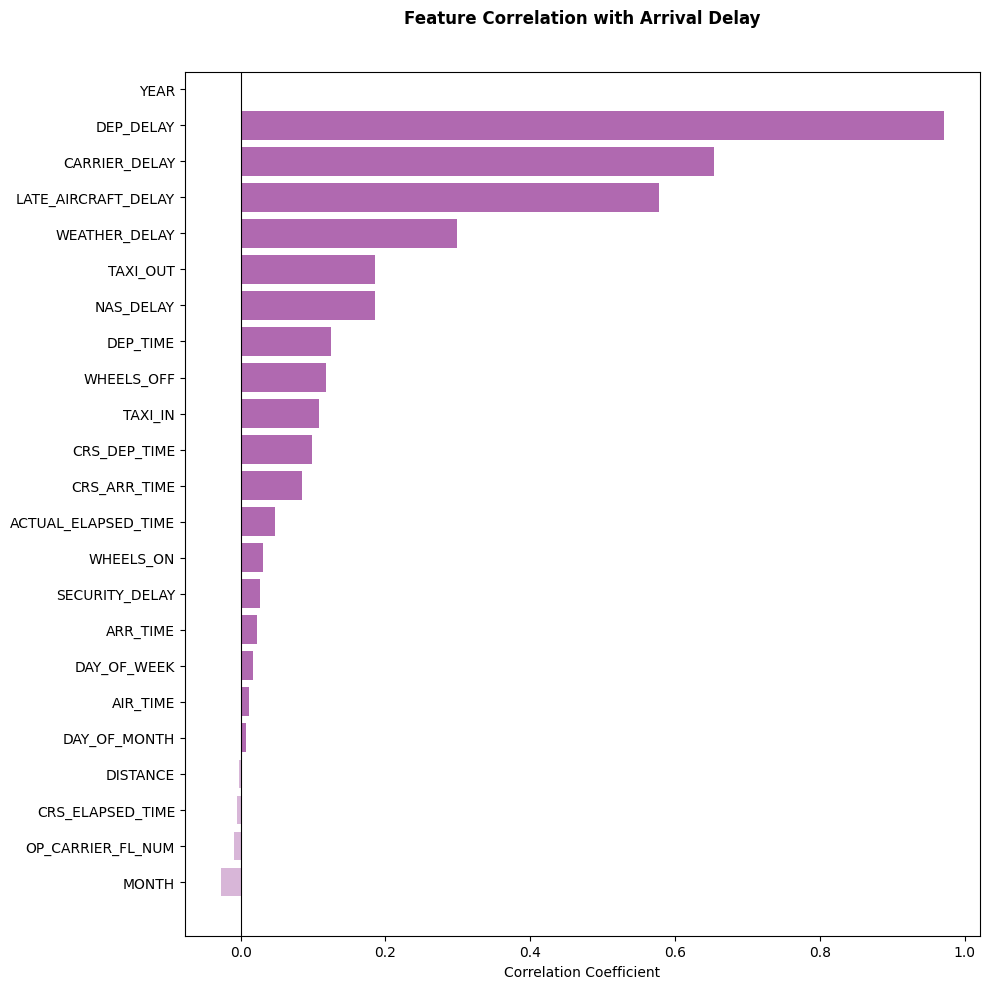

In [ ]:
corr_with_target = df.corr(numeric_only=True)['ARR_DELAY'].drop('ARR_DELAY').sort_values()
plt.figure(figsize=(10, 10))
colors = ['#c897c8' if x < 0 else '#8f298f' for x in corr_with_target.values]
plt.barh(corr_with_target.index, corr_with_target.values, color=colors, alpha=0.7)

plt.axvline(x=0, color='black', linewidth=0.8)
plt.title('Feature Correlation with Arrival Delay\n',fontweight='bold', pad=20)
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

Correlation Summary with ARR_DELAY:

* Strongest positive: DEP_DELAY (0.971)

* Strongest negative: MONTH (-0.027)

In [44]:
# Count outliers for target variable
Q1= y.quantile(0.25)
Q3= y.quantile(0.75)
IQR= Q3-Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5*IQR

y_Outliers=(y<(lower_bound))|(y>(upper_bound))
print('Outliers Count:',y_Outliers.sum())

Outliers Count: 94107


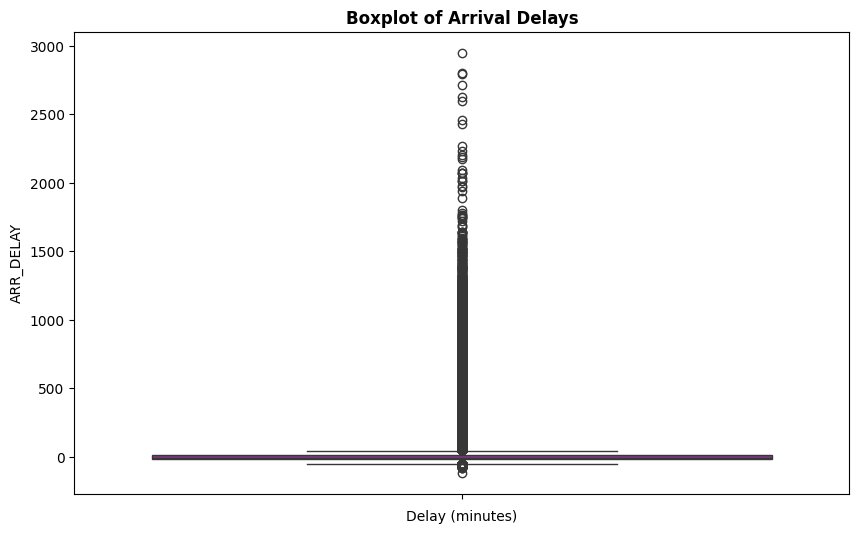

In [45]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=y,color='#8f298f')
plt.title("Boxplot of Arrival Delays",fontweight='bold')
plt.xlabel("Delay (minutes)")
plt.show()

94,107 outlier observations were detected in the arrival delay data, indicating a highly right-skewed distribution with many extreme delay values.

Recommended Actions:
- Cap extreme delays
- Use robust scaling

In [46]:
missing_values_y=y.isnull().sum()
missing_values_y

np.int64(16197)

16197 of arrival delay values are missing in the target variable

In [47]:
print('Missing percentage: ',round(y.isnull().mean()*100,2),'%')

Missing percentage:  1.62 %




1.62% missing translates to roughly 1-2 flights per 100 without delay data

This is within acceptable limits for operational data

The missing pattern is likely not random - probably related to operational disruptions

In [48]:
mask=~y.isna()
X=X[mask]
y=y[mask]
y_classification=y_classification[mask]

Removed rows where the target was missing

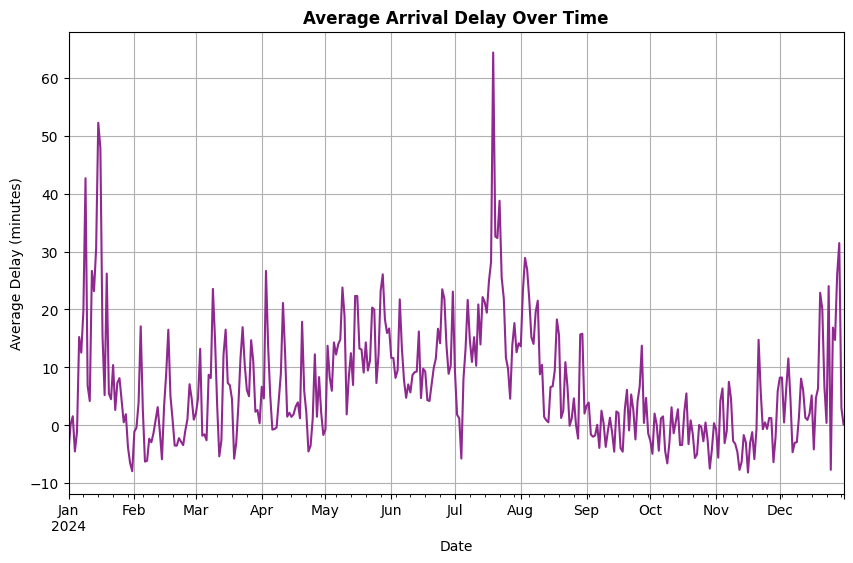

In [49]:
# Temporal Analysis: Daily Average Arrival Delay Trends Over Time
plt.figure(figsize=(10, 6))
df.groupby('FL_DATE')['ARR_DELAY'].mean().plot(color='#8f298f')
plt.title("Average Arrival Delay Over Time",fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Average Delay (minutes)")
plt.grid()
plt.show()

The data shows significant volatility in daily average delays ranging from -10 to +60 minutes, with clear seasonal patterns and specific disruption events

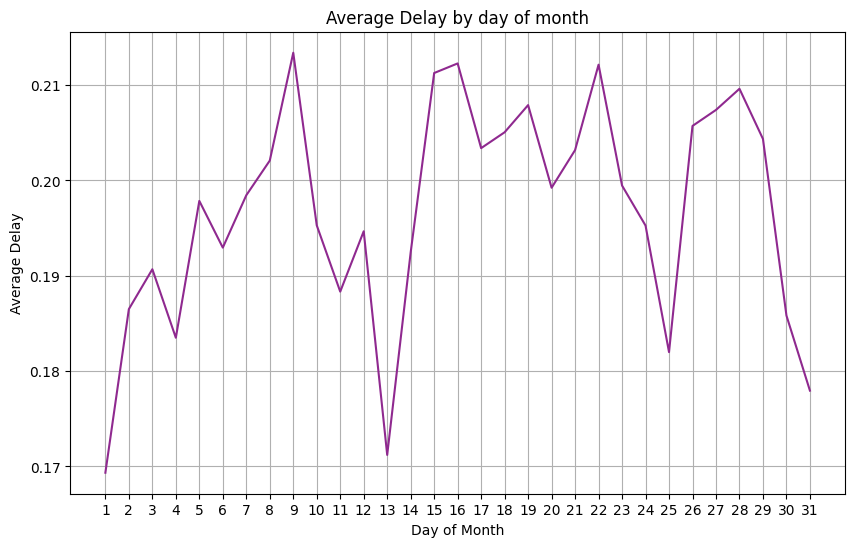

In [50]:
plt.figure(figsize=(10, 6))
Xy.groupby('DAY_OF_MONTH')['IS_DELAYED'].mean().plot(color='#8f298f')
plt.title("Average Delay by day of month")
plt.ylabel("Average Delay")
plt.xlabel("Day of Month")
plt.xticks(range(1, 32))
plt.grid()
plt.show()

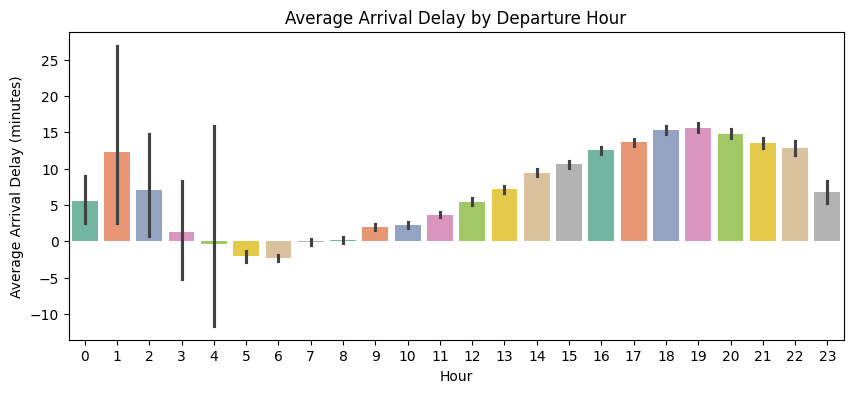

In [51]:
Xy['Hour'] = Xy['CRS_DEP_TIME'] // 100
plt.figure(figsize=(10,4))
sns.barplot(x='Hour', y='Arrival Delay in Minutes', data=Xy, estimator=lambda x: x.mean(), palette='Set2')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Average Arrival Delay by Departure Hour')
plt.show()

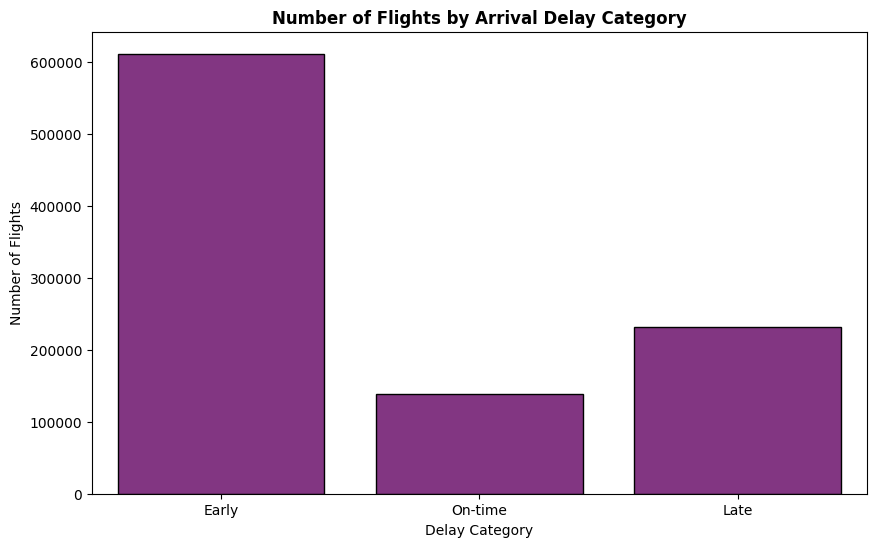

In [ ]:
# Arrival Delay Classification: Count of Flights by Punctuality Category
plt.figure(figsize=(10, 6))
df['delay_group']=pd.cut(df['ARR_DELAY'], bins=[-500, -1, 10, 500],
                           labels=["Early", "On-time", "Late"])

sns.countplot(x='delay_group', data=df,color='#8f298f',edgecolor='#000000')
plt.title("Number of Flights by Arrival Delay Category",fontweight='bold')
plt.xlabel("Delay Category")
plt.ylabel("Number of Flights")
plt.show()

df.drop(columns='delay_group',inplace=True)

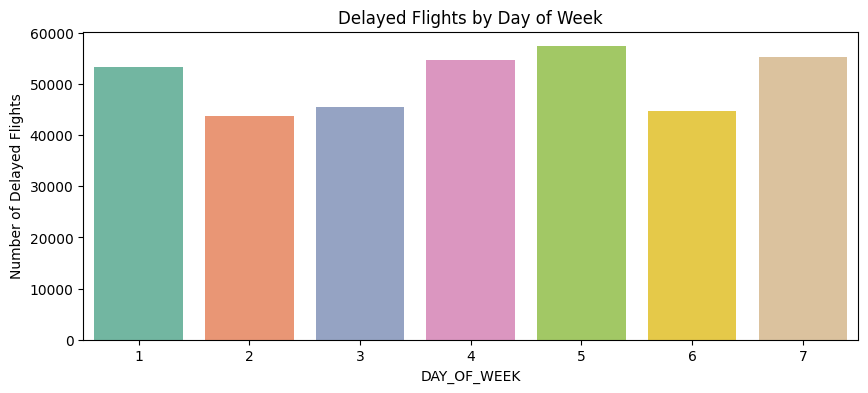

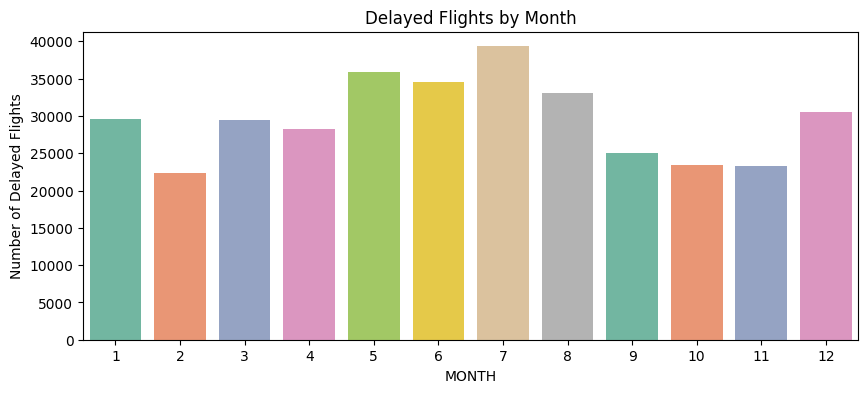

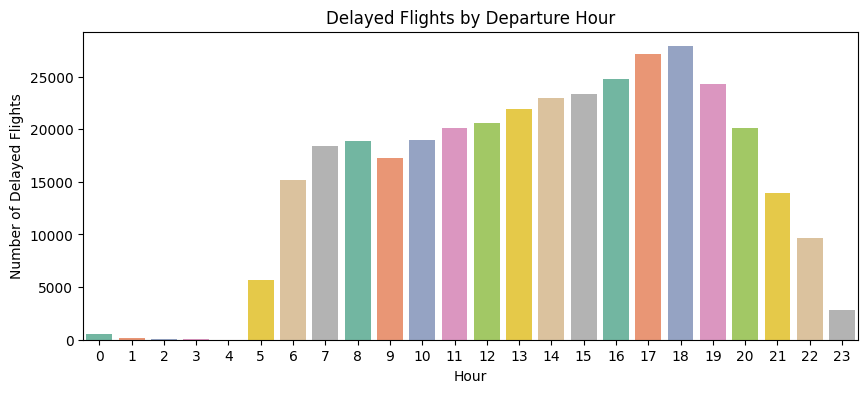

In [ ]:
# Delayed flights only
delayed = Xy[Xy['IS_DELAYED']==1]

# By Day of Week
plt.figure(figsize=(10,4))
sns.countplot(x='DAY_OF_WEEK', data=delayed, palette='Set2')
plt.ylabel('Number of Delayed Flights')
plt.title('Delayed Flights by Day of Week')
plt.show()

# By Month
plt.figure(figsize=(10,4))
sns.countplot(x='MONTH', data=delayed, palette='Set2')
plt.ylabel('Number of Delayed Flights')
plt.title('Delayed Flights by Month')
plt.show()

# By Hour
plt.figure(figsize=(10,4))
sns.countplot(x='Hour', data=delayed, palette='Set2')
plt.ylabel('Number of Delayed Flights')
plt.title('Delayed Flights by Departure Hour')
plt.show()


# Step 4.1: Data Preprocessing

**Time feature selection (hhmm vs. minutes)**

The dataset contains two types of time values :

* hhmm clock times (e.g., 0540, 1325)

* duration values in minutes (e.g., air time, taxi-out)

following the definitions used by the [U.S. Bureau of Transportation Statistics (BTS)](https://transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGK&QO_fu146_anzr=b0-gvzr), we manually identified which columns represent actual times of day versus time durations

We manually selected the hhmm time columns for preprocessing, since they represent clock times, these will then be converted into minutes since midnight to create a consistent numeric feature for modeling

The minute-based duration columns were kept as is since they already represent valid numeric intervals and do not require further transformation

In [54]:
hhmm_cols=['CRS_DEP_TIME','DEP_TIME','WHEELS_OFF','WHEELS_ON','CRS_ARR_TIME','ARR_TIME']
mm_cols=['DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME','AIR_TIME','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']

In [55]:
def time_to_minutes(t):
    t = t.fillna(0).astype(int)

    t = np.where(t == 2400, 0, t)
    hh = t // 100
    mm = t % 100
    hh = np.where(hh >= 24, hh - 24, hh)
    mm = np.where(mm >= 60, mm - 60, mm)
    return hh * 60 + mm


for col in hhmm_cols:
    X[col] = time_to_minutes(X[col])

***Physical constraints - remove impossible values***

In [56]:
current_mask = (
    (X["TAXI_OUT"].between(0, 120)) &
    (X["TAXI_IN"].between(0, 60)) &
    (X["AIR_TIME"].between(30, 1260)) &
    (X["ACTUAL_ELAPSED_TIME"].between(30, 1560)) &
    (X["CRS_ELAPSED_TIME"].between(0, 600)) &
    (X["DISTANCE"].between(100, 3000))
)

X = X.loc[current_mask].reset_index(drop=True)
y = y.loc[current_mask].reset_index(drop=True)
y_classification = y_classification.loc[current_mask].reset_index(drop=True)

This code is performing outlier filtering to remove unrealistic or impossible values from several flight-related features.
Each line keeps only the rows where the feature falls within a reasonable operational range.

Feature-by-feature explanation:

TAXI_OUT (0–120 minutes):

         Removes flights with extremely long or negative taxi-out times.
         Typical taxi-out durations rarely exceed 1 hour, so values >120 minutes are likely errors.

TAXI_IN (0–60 minutes):

         Ensures taxi-in time is reasonable.
         Taxi-in normally stays under 30 minutes; anything above 60 minutes is suspicious.

AIR_TIME (0–500 minutes):


          Keeps only valid air times.
          500 minutes (≈8 hours 20 min) covers even long domestic flights, so higher values are likely incorrect.

ACTUAL_ELAPSED_TIME (0–600 minutes):

          Limits the total flight time to 0–600 minutes.
          Flights longer than 10 hours are not part of this dataset and may be data entry errors.

CRS_ELAPSED_TIME (0–600 minutes):

        Same idea but for the scheduled (planned) flight duration.
        Ensures the scheduled time is within a realistic range.

DISTANCE (0–3000 miles):

    Removes flights with:

        Zero or negative distance → incorrect

        Distance above 3000 miles → likely international/incorrect for this dataset

***handeling missing data***

Based on the missing pct calculated before

`CANCELLATION_CODE` has ~98% missing values, so dropping it is the most reasonable choice

In [57]:
X=X.drop(columns='CANCELLATION_CODE')

Delay columns use NaN to indicate no delay, so missing values are filled with >> 0

In [58]:
delay_cols=['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']

X[delay_cols]=X[delay_cols].fillna(0)

The remaining columns have low missingness and skewed values, so we fill them using the median after splitting into training & testing

In [59]:
low_missing_cols=['AIR_TIME','ACTUAL_ELAPSED_TIME','ARR_TIME','WHEELS_ON','TAXI_IN','WHEELS_OFF','TAXI_OUT','DEP_DELAY','DEP_TIME']

**Imputing after train test split:**

In [60]:
X=X.drop(columns=['ORIGIN_CITY_NAME','ORIGIN_STATE_ABR','DEST_CITY_NAME','DEST_STATE_ABR'])

We removed the redundant city and state columns since they provide the same information as the airport codes (`ORIGIN`, `DEST`) and would only add unnecessary high-cardinality features

In [61]:
X.isnull().sum()

MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
FL_DATE                0
OP_UNIQUE_CARRIER      0
OP_CARRIER_FL_NUM      0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
TAXI_OUT               0
WHEELS_OFF             0
WHEELS_ON              0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_TIME               0
CANCELLED              0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
dtype: int64

In [62]:
num_cols=X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols=X.select_dtypes(include='object').columns.tolist()

**spliting**

In [63]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
y_classification = y_classification.reset_index(drop=True)


mask = y_classification == 1
X_reg = X.loc[mask].copy()
y_reg = y.loc[mask].copy()

In [64]:
X_classification = X.copy()
X_clas_train, X_clas_test, y_clas_train, y_clas_test = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42,stratify=y_classification)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [65]:
X_clas_train.shape

(760909, 28)

In [66]:
X_reg_train.shape

(152231, 28)

In [67]:
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

X_reg_train = encode_cyclical(X_reg_train, 'DEP_TIME', 2400)
X_reg_train = encode_cyclical(X_reg_train, 'CRS_DEP_TIME', 2400)
X_reg_train = encode_cyclical(X_reg_train, 'CRS_ARR_TIME', 2400)
X_reg_train = encode_cyclical(X_reg_train, 'ARR_TIME', 2400)

X_reg_test = encode_cyclical(X_reg_test, 'DEP_TIME', 2400)
X_reg_test = encode_cyclical(X_reg_test, 'CRS_DEP_TIME', 2400)
X_reg_test = encode_cyclical(X_reg_test, 'CRS_ARR_TIME', 2400)
X_reg_test = encode_cyclical(X_reg_test, 'ARR_TIME', 2400)

In [68]:
X_clas_train = encode_cyclical(X_clas_train, 'DEP_TIME', 2400)
X_clas_train = encode_cyclical(X_clas_train, 'CRS_DEP_TIME', 2400)
X_clas_train = encode_cyclical(X_clas_train, 'CRS_ARR_TIME', 2400)
X_clas_train = encode_cyclical(X_clas_train, 'ARR_TIME', 2400)

X_cals_test = encode_cyclical(X_clas_test, 'DEP_TIME', 2400)
X_cals_test = encode_cyclical(X_clas_test, 'CRS_DEP_TIME', 2400)
X_cals_test = encode_cyclical(X_clas_test, 'CRS_ARR_TIME', 2400)
X_cals_test = encode_cyclical(X_clas_test, 'ARR_TIME', 2400)

**Feature Engineering**

In [69]:
X_reg_train["IS_PEAK_MONTH"] = X_reg_train["MONTH"].isin([6,7,8,12]).astype(int)
X_reg_train["IS_WEEKEND"] = X_reg_train["DAY_OF_WEEK"].isin([6,7]).astype(int)

In [70]:
X_clas_train["IS_PEAK_MONTH"] = X_clas_train["MONTH"].isin([6,7,8,12]).astype(int)
X_clas_train["IS_WEEKEND"] = X_clas_train["DAY_OF_WEEK"].isin([6,7]).astype(int)

In [71]:
X_clas_test["IS_PEAK_MONTH"] = X_clas_test["MONTH"].isin([6,7,8,12]).astype(int)
X_clas_test["IS_WEEKEND"] = X_clas_test["DAY_OF_WEEK"].isin([6,7]).astype(int)

In [72]:
X_reg_test["IS_PEAK_MONTH"] = X_reg_test["MONTH"].isin([6,7,8,12]).astype(int)
X_reg_test["IS_WEEKEND"] = X_reg_test["DAY_OF_WEEK"].isin([6,7]).astype(int)

**Encoding Categorical Variables**

1. Frequency Encoding for Classification task:

Frequency encoding was used for the classification task because it preserves information about category prevalence without introducing target leakage.

However, a limitation of this approach is that it does not capture the relationship between categories and the target variable, which may reduce predictive power for some features.

In [73]:
for col in cat_cols:
    freq_map=X_clas_train[col].value_counts()
    X_clas_train[col]=X_clas_train[col].map(freq_map)
    X_clas_test[col]=X_clas_test[col].map(freq_map).fillna(0)

In [74]:
X_clas_train[cat_cols]

OP_UNIQUE_CARRIER  ORIGIN   DEST
941966              70541      22  13260
314753               4274    2798   3770
140007              70541    5408   7135
7975               147360    4679  20324
806155             104240   20223  18662
...                   ...     ...    ...
451521              12125    5140  14952
529675             101315    8834  25012
6043               147360    7229   1894
896077             101315   14610   2437
587944              30661    5228  14941

[760909 rows x 3 columns]

2. Target Encoding for Regression task:

Target encoding was applied for the regression task as it captures the direct relationship between categorical features and the continuous target variable, enabling the model to learn patterns related to delay magnitude more effectively.

Nevertheless, target encoding is sensitive to overfitting and target leakage, especially for rare categories, which requires careful regularization and proper train–test separation.

In [75]:
te = TargetEncoder(cols=cat_cols, smoothing=10)
X_reg_train[cat_cols] = te.fit_transform(X_reg_train[cat_cols], y_reg_train)
X_reg_test[cat_cols]  = te.transform(X_reg_test[cat_cols])

In [76]:
X_reg_train[cat_cols]

OP_UNIQUE_CARRIER     ORIGIN       DEST
521962          85.502008  82.026826  91.026621
112293          80.230244  76.221466  60.257500
362244          74.114667  65.407998  66.534799
635993          87.651147  73.474097  70.380577
324732          87.651147  74.717252  91.026621
...                   ...        ...        ...
544048          87.651147  74.043473  70.813851
486834          81.381493  65.407998  69.977054
597445          94.538256  76.616521  83.196716
677052          74.114667  68.953381  78.430104
550032          87.651147  74.043473  78.665116

[152231 rows x 3 columns]

**Handling outliers & skewness**

In [77]:
delay_cols = ["DEP_DELAY", "ARR_DELAY","CARRIER_DELAY", "WEATHER_DELAY","NAS_DELAY", "SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]

In [78]:
def handle_outliers(X_train,X_test,col):
  for col in col:
    if col in X_train.columns:
        X_train[col] = X_train[col].clip(lower=-30, upper=24*60)
        X_test[col] = X_test[col].clip(lower=-30, upper=24*60)
        X_train[col] = np.sign(X_train[col]) * np.log1p(np.abs(X_train[col]))
        X_test[col] = np.sign(X_test[col]) * np.log1p(np.abs(X_test[col]))

In [79]:
handle_outliers(X_reg_train,X_reg_test,delay_cols)

In [80]:
handle_outliers(X_clas_train,X_clas_test,delay_cols)

Delay-related features exhibited extreme skewness and contained both negative (early arrivals) and large positive values.
To reduce the impact of outliers while preserving the direction of delay, values were clipped to a realistic range and transformed using a signed logarithmic transformation

In [81]:
num_cols=X_reg_train.select_dtypes(include=['int64','float64']).columns.tolist()

In [82]:
Q1= X_reg_train[num_cols].quantile(0.25)
Q3= X_reg_train[num_cols].quantile(0.75)
IQR= Q3-Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5*IQR

Outliers=(X_reg_train[num_cols]<(lower_bound))|(X_reg_train[num_cols]>(upper_bound))
print(Outliers.sum().sum())
Outliers.sum().rename('Outliers Count')

122476


MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
OP_UNIQUE_CARRIER       1016
OP_CARRIER_FL_NUM         29
ORIGIN                  4089
DEST                     673
CRS_DEP_TIME              68
DEP_TIME                1603
DEP_DELAY              17074
TAXI_OUT               10146
WHEELS_OFF              2475
WHEELS_ON                  0
TAXI_IN                12454
CRS_ARR_TIME            3835
ARR_TIME                   0
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME        7198
ACTUAL_ELAPSED_TIME     6420
AIR_TIME                7134
DISTANCE                8329
CARRIER_DELAY              0
WEATHER_DELAY           9408
NAS_DELAY                  1
SECURITY_DELAY           763
LATE_AIRCRAFT_DELAY        0
DEP_TIME_sin               0
DEP_TIME_cos            3449
CRS_DEP_TIME_sin           0
CRS_DEP_TIME_cos         363
CRS_ARR_TIME_sin           0
CRS_ARR_TIME_cos        9571
ARR_TIME_sin               0
ARR_TIME_cos           16378
IS_PEAK_MONTH              0
IS_WEEKEND                 0
Name: Outliers Count, dtype: int64

In [83]:
Q1= X_clas_train[num_cols].quantile(0.25)
Q3= X_clas_train[num_cols].quantile(0.75)
IQR= Q3-Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5*IQR

Outliers=(X_clas_train[num_cols]<(lower_bound))|(X_clas_train[num_cols]>(upper_bound))
print(Outliers.sum().sum())
Outliers.sum().rename('Outliers Count')

517345


MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
OP_UNIQUE_CARRIER          0
OP_CARRIER_FL_NUM        111
ORIGIN                     0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                   0
DEP_DELAY                  0
TAXI_OUT               39927
WHEELS_OFF                 0
WHEELS_ON                  0
TAXI_IN                50598
CRS_ARR_TIME               0
ARR_TIME                   0
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME       39026
ACTUAL_ELAPSED_TIME    37942
AIR_TIME               38911
DISTANCE               42892
CARRIER_DELAY          85306
WEATHER_DELAY           9573
NAS_DELAY              78646
SECURITY_DELAY           793
LATE_AIRCRAFT_DELAY    81087
DEP_TIME_sin             421
DEP_TIME_cos               0
CRS_DEP_TIME_sin        3840
CRS_DEP_TIME_cos           0
CRS_ARR_TIME_sin           0
CRS_ARR_TIME_cos        8272
ARR_TIME_sin               0
ARR_TIME_cos               0
IS_PEAK_MONTH              0
IS_WEEKEND                 0
Name: Outliers Count, dtype: int64

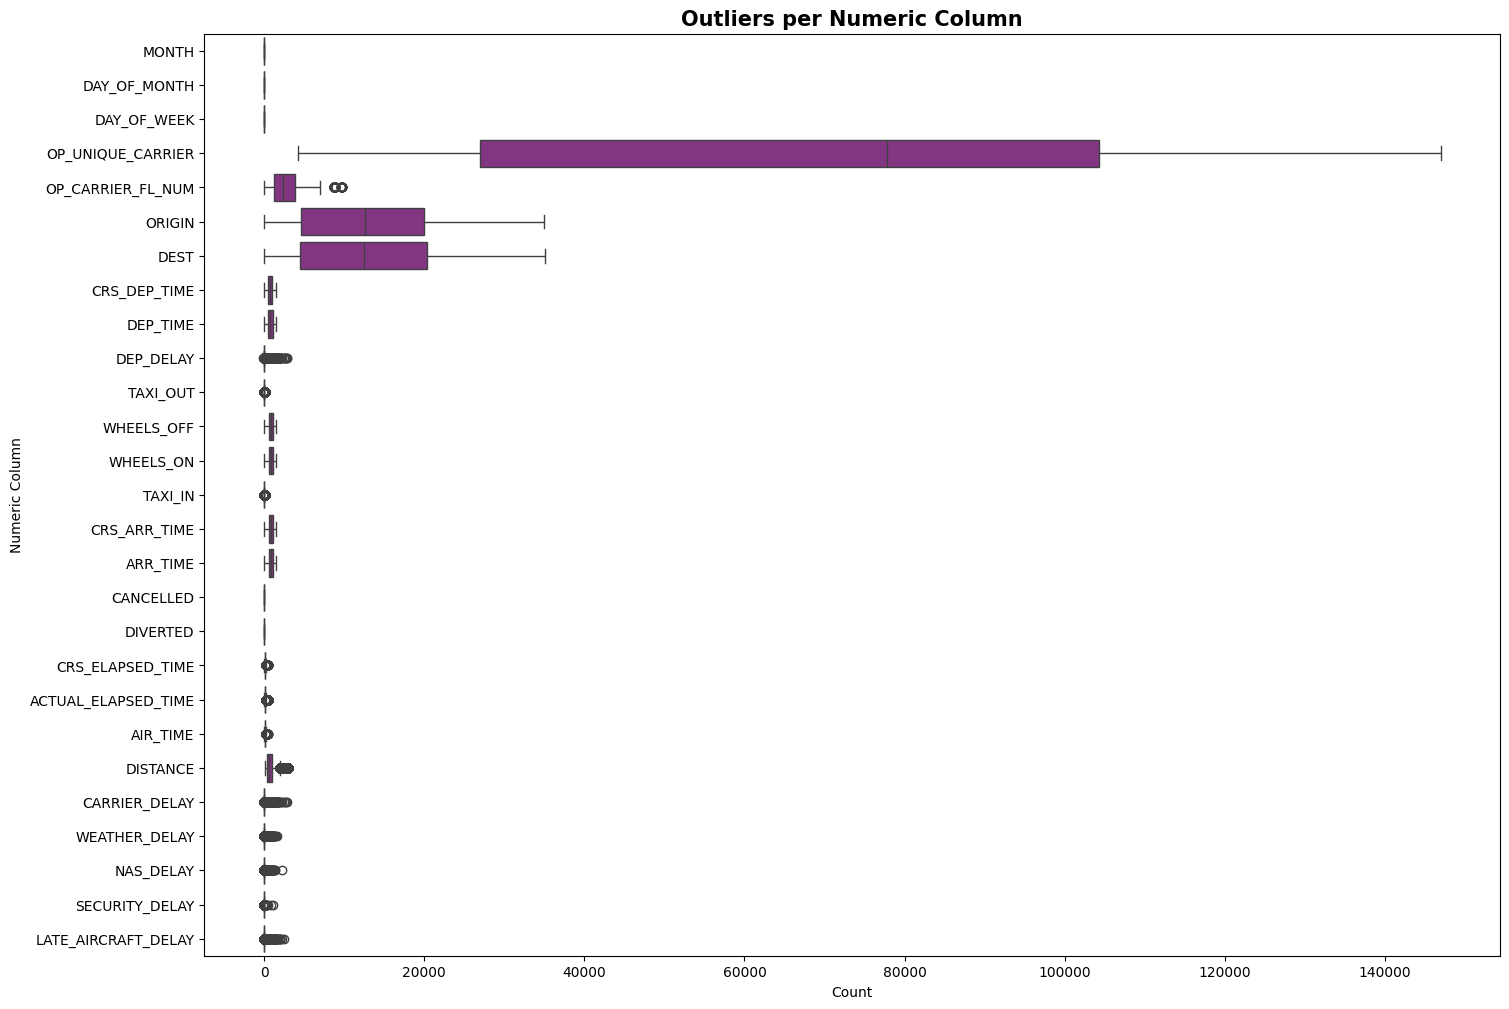

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=X_clas_train,color='#8f298f',orient='h')
plt.title('Outliers per Numeric Column',size=15,fontweight='bold')
plt.tight_layout()
plt.xlabel('Count')
plt.ylabel('Numeric Column')
plt.show()

In [85]:
def handle_skewness(X_train,X_test,num_cols):
  skewed=X_train[num_cols].skew().sort_values()
  skewed=skewed[abs(skewed)>0.75]
  pt = PowerTransformer(method='yeo-johnson')
  X_train[skewed.index]= pt.fit_transform(X_train[skewed.index])
  X_test[skewed.index]=pt.transform(X_test[skewed.index])

In [86]:
handle_skewness(X_reg_train,X_reg_test,num_cols)
handle_skewness(X_clas_train,X_clas_test,num_cols)

In [87]:
X_reg_train[num_cols].skew().sort_values()

ARR_TIME               -0.702062
WHEELS_OFF             -0.700850
WHEELS_ON              -0.680485
CRS_DEP_TIME_sin       -0.628766
DEP_TIME               -0.602188
DEP_TIME_sin           -0.423401
CRS_ARR_TIME           -0.391434
OP_UNIQUE_CARRIER      -0.365764
DEP_DELAY              -0.340702
CRS_DEP_TIME           -0.321377
CRS_ARR_TIME_sin       -0.168717
DAY_OF_WEEK            -0.085895
DAY_OF_MONTH           -0.024857
ORIGIN                 -0.023512
DISTANCE               -0.014196
ARR_TIME_sin           -0.013898
CANCELLED               0.000000
DIVERTED                0.000000
AIR_TIME                0.006100
ACTUAL_ELAPSED_TIME     0.009750
TAXI_OUT                0.020694
CRS_ELAPSED_TIME        0.026297
TAXI_IN                 0.036941
MONTH                   0.083325
DEST                    0.155124
LATE_AIRCRAFT_DELAY     0.318171
IS_PEAK_MONTH           0.355580
CRS_DEP_TIME_cos        0.458769
CARRIER_DELAY           0.513175
OP_CARRIER_FL_NUM       0.523230
DEP_TIME_cos            0.544716
NAS_DELAY               0.555160
CRS_ARR_TIME_cos        0.688235
ARR_TIME_cos            0.708813
IS_WEEKEND              0.948179
WEATHER_DELAY           3.639664
SECURITY_DELAY         14.018748
dtype: float64

In [88]:
X_clas_train[num_cols].skew().sort_values()

CRS_ARR_TIME_sin       -0.629400
ARR_TIME_sin           -0.605647
CRS_DEP_TIME_sin       -0.482000
DEP_TIME_sin           -0.470798
ARR_TIME               -0.376731
WHEELS_ON              -0.334836
CRS_ARR_TIME           -0.271224
MONTH                  -0.028865
TAXI_OUT               -0.019433
WHEELS_OFF             -0.010233
DISTANCE               -0.008748
DAY_OF_MONTH           -0.006111
CANCELLED               0.000000
DIVERTED                0.000000
DAY_OF_WEEK             0.007381
AIR_TIME                0.013264
TAXI_IN                 0.017320
ACTUAL_ELAPSED_TIME     0.021978
OP_UNIQUE_CARRIER       0.023871
CRS_ELAPSED_TIME        0.032048
DEP_TIME                0.033563
CRS_DEP_TIME            0.082678
ARR_TIME_cos            0.394635
CRS_ARR_TIME_cos        0.402760
CRS_DEP_TIME_cos        0.435634
OP_CARRIER_FL_NUM       0.453832
DEP_TIME_cos            0.475743
ORIGIN                  0.569721
DEST                    0.569917
IS_PEAK_MONTH           0.650266
DEP_DELAY               0.710444
IS_WEEKEND              0.998629
CARRIER_DELAY           2.459060
LATE_AIRCRAFT_DELAY     2.550219
NAS_DELAY               2.605943
WEATHER_DELAY           8.746311
SECURITY_DELAY         30.927932
dtype: float64

**Correlation Analysis**

Correlation analysis was conducted separately for the classification and regression tasks to reflect the different nature of the target variables and modeling objectives.

In [89]:
correlation_matrix_clas = X_clas_train[num_cols].corrwith(y_clas_train)

In [90]:
correlation_matrix_clas.sort_values(ascending=False)

DEP_DELAY              0.688688
CARRIER_DELAY          0.686487
LATE_AIRCRAFT_DELAY    0.673471
NAS_DELAY              0.649624
WEATHER_DELAY          0.222084
DEP_TIME               0.200412
WHEELS_OFF             0.197145
TAXI_OUT               0.184600
CRS_DEP_TIME           0.158261
CRS_ARR_TIME           0.132567
ACTUAL_ELAPSED_TIME    0.089614
WHEELS_ON              0.087841
ARR_TIME               0.077783
TAXI_IN                0.071530
IS_PEAK_MONTH          0.071040
SECURITY_DELAY         0.061124
AIR_TIME               0.040324
ORIGIN                 0.039442
DAY_OF_WEEK            0.025344
DISTANCE               0.021019
CRS_ELAPSED_TIME       0.019008
IS_WEEKEND             0.009495
DAY_OF_MONTH           0.008931
OP_UNIQUE_CARRIER      0.004841
DEST                  -0.004104
OP_CARRIER_FL_NUM     -0.020723
MONTH                 -0.034913
ARR_TIME_cos          -0.098683
CRS_DEP_TIME_sin      -0.135767
CRS_ARR_TIME_cos      -0.139271
CRS_ARR_TIME_sin      -0.155279
CRS_DEP_TIME_cos      -0.162277
DEP_TIME_cos          -0.186487
DEP_TIME_sin          -0.198713
ARR_TIME_sin          -0.205826
CANCELLED                   NaN
DIVERTED                    NaN
dtype: float64

In [91]:
constant_cols = [c for c in X_clas_train.columns if X_clas_train[c].nunique() == 1]
print("constant columns", constant_cols)
X_clas_train.drop(columns=constant_cols, inplace=True)
X_clas_test.drop(columns=constant_cols, inplace=True)

constant columns ['CANCELLED', 'DIVERTED']


In [92]:
correlation_matrix_reg = X_reg_train[num_cols].corrwith(y_reg_train)
correlation_matrix_reg.sort_values(ascending=False)

DEP_DELAY              0.632377
CARRIER_DELAY          0.229229
LATE_AIRCRAFT_DELAY    0.227769
OP_UNIQUE_CARRIER      0.118825
DEST                   0.104501
ORIGIN                 0.102484
WEATHER_DELAY          0.101616
ARR_TIME_cos           0.082425
IS_PEAK_MONTH          0.024708
TAXI_IN                0.023434
OP_CARRIER_FL_NUM      0.020443
DEP_TIME_cos           0.015293
CRS_ARR_TIME_cos       0.007292
DAY_OF_MONTH           0.005650
CRS_DEP_TIME_cos       0.005289
CRS_ELAPSED_TIME       0.004545
IS_WEEKEND             0.002195
DAY_OF_WEEK            0.000917
CRS_ARR_TIME_sin      -0.002100
CRS_ARR_TIME          -0.004197
ARR_TIME_sin          -0.005554
CRS_DEP_TIME_sin      -0.007978
DEP_TIME              -0.008074
TAXI_OUT              -0.008325
CRS_DEP_TIME          -0.008537
DISTANCE              -0.009732
SECURITY_DELAY        -0.010230
AIR_TIME              -0.012933
NAS_DELAY             -0.013285
ACTUAL_ELAPSED_TIME   -0.013778
MONTH                 -0.017753
WHEELS_OFF            -0.024865
DEP_TIME_sin          -0.058763
WHEELS_ON             -0.075544
ARR_TIME              -0.078260
CANCELLED                   NaN
DIVERTED                    NaN
dtype: float64

In [93]:
constant_cols = [c for c in X_reg_train.columns if X_reg_train[c].nunique() == 1]
print("constant columns", constant_cols)
X_reg_train.drop(columns=constant_cols, inplace=True)
X_reg_test.drop(columns=constant_cols, inplace=True)

constant columns ['CANCELLED', 'DIVERTED']


In [94]:
def reduce_highly_correlated_features(X, y, corr_threshold=0.9):
    corr_matrix = X.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    high_corr_groups = []
    checked = set()
    for col in upper.columns:
        if col in checked:
            continue
        group = [col]
        for other_col in upper.columns:
            if other_col != col and upper.loc[col, other_col] > corr_threshold:
                group.append(other_col)
        if len(group) > 1:
            high_corr_groups.append(group)
            checked.update(group)


    removed_features = []
    for group in high_corr_groups:
        target_corr = X[group].corrwith(y).abs()
        best_feature = target_corr.idxmax()
        to_drop = [f for f in group if f != best_feature]
        removed_features.extend(to_drop)
    X_reduced = X.copy()
    return X_reduced, removed_features


In [95]:
X_reg_train,r1 = reduce_highly_correlated_features(X_reg_train, y_reg_train)
#X_reg_test.drop(columns=r1, inplace=True)

In [96]:
r1

['FL_DATE',
 'DEP_TIME',
 'WHEELS_ON',
 'CRS_ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'CRS_DEP_TIME_sin']

In [97]:
X_clas_train,r = reduce_highly_correlated_features(X_clas_train, y_clas_train)

In [98]:
r

['FL_DATE',
 'CRS_DEP_TIME',
 'WHEELS_OFF',
 'ARR_TIME',
 'CRS_ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'CRS_DEP_TIME_sin',
 'CRS_DEP_TIME_cos',
 'CRS_ARR_TIME_sin',
 'ARR_TIME_cos']

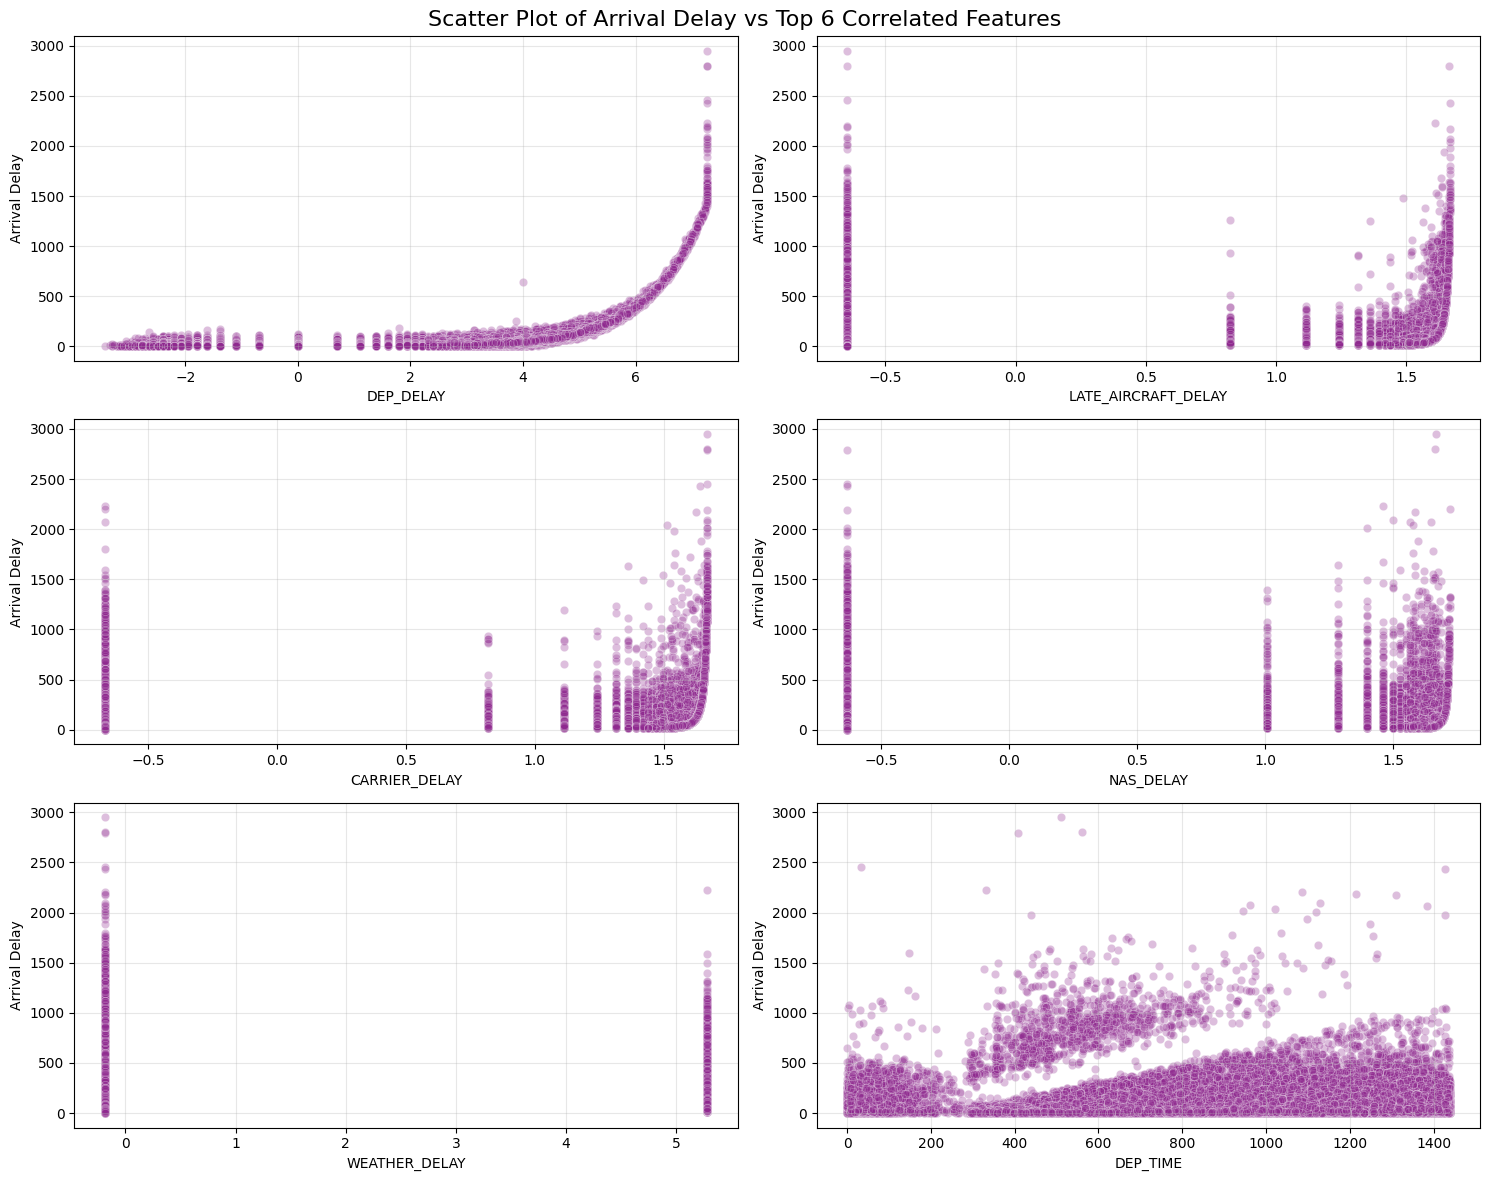

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
ax = ax.flatten()
top6 = correlation_matrix_reg.sort_values(ascending=False).head(6).index
for feature, axis in zip(top6, ax):
    sns.scatterplot(
        data=X_reg_train,
        x=feature,
        y=y_reg_train,
        alpha=0.3,
        color='#8f298f',
        ax=axis
    )
    axis.set_ylabel('Arrival Delay')
    axis.set_xlabel(feature)
    axis.grid(alpha=0.3)

fig.suptitle('Scatter Plot of Arrival Delay vs Top 6 Correlated Features', fontsize=16)
plt.tight_layout()
plt.show()

**Scaling**

In [100]:
def scaling(X_train,X_test,num_cols):
  scaler=RobustScaler()
  X_train[num_cols]=scaler.fit_transform(X_train[num_cols])
  X_test[num_cols]=scaler.transform(X_test[num_cols])

In [101]:
num_cols=X_reg_train.select_dtypes(include=['int64','float64']).columns.tolist()
scaling(X_reg_train,X_reg_test,num_cols)
num_cols=X_clas_train.select_dtypes(include=['int64','float64']).columns.tolist()
scaling(X_clas_train,X_clas_test,num_cols)

# Step 4.2: Target preprocessing

1. Regression task:

In [102]:
y_reg_train.isnull().sum()

np.int64(0)

In [103]:
y_reg_test.isnull().sum()

np.int64(0)

In [104]:
y_reg_train.skew()

np.float64(6.690691527337293)

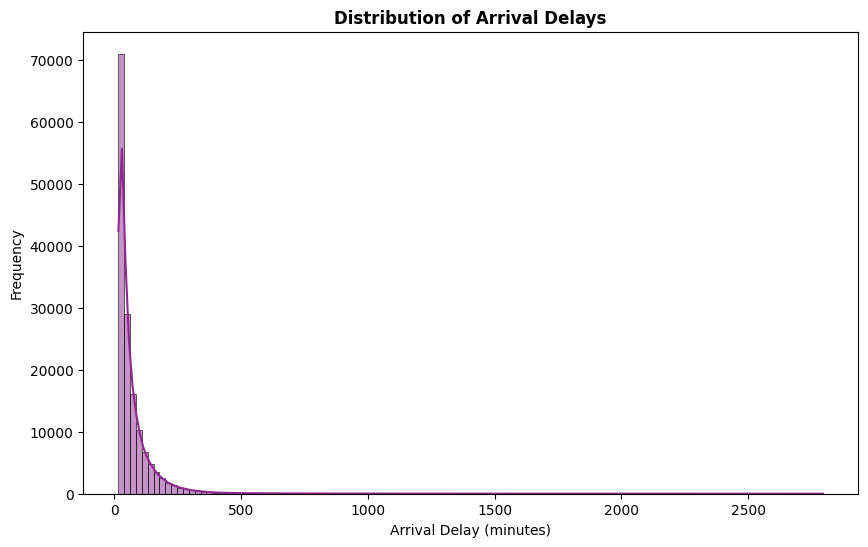

In [105]:
plt.figure(figsize=(10, 6))
sns.histplot(x=y_reg_train, kde=True, bins=120,color='#8f298f')
plt.title('Distribution of Arrival Delays',fontweight='bold')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

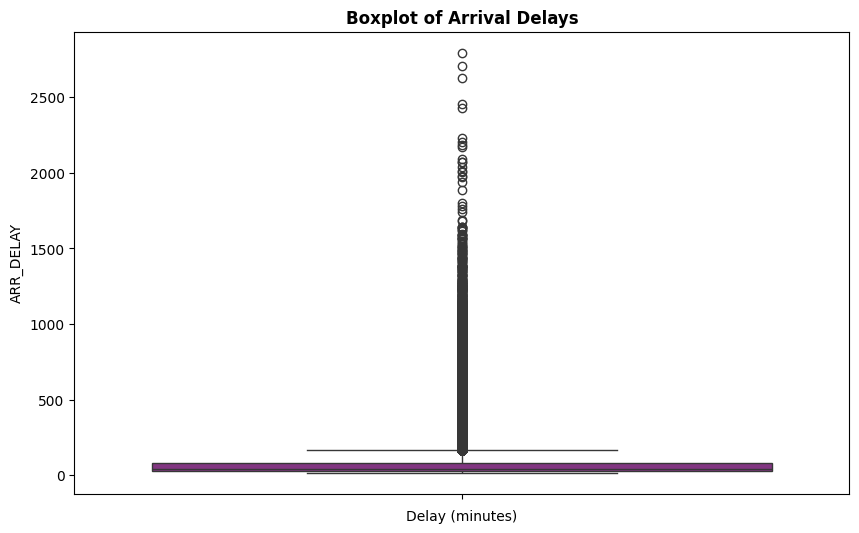

In [106]:
plt.figure(figsize=(10, 6))
sns.boxplot(y_reg_train,color='#8f298f')
plt.title("Boxplot of Arrival Delays",fontweight='bold')
plt.xlabel("Delay (minutes)")
plt.show()

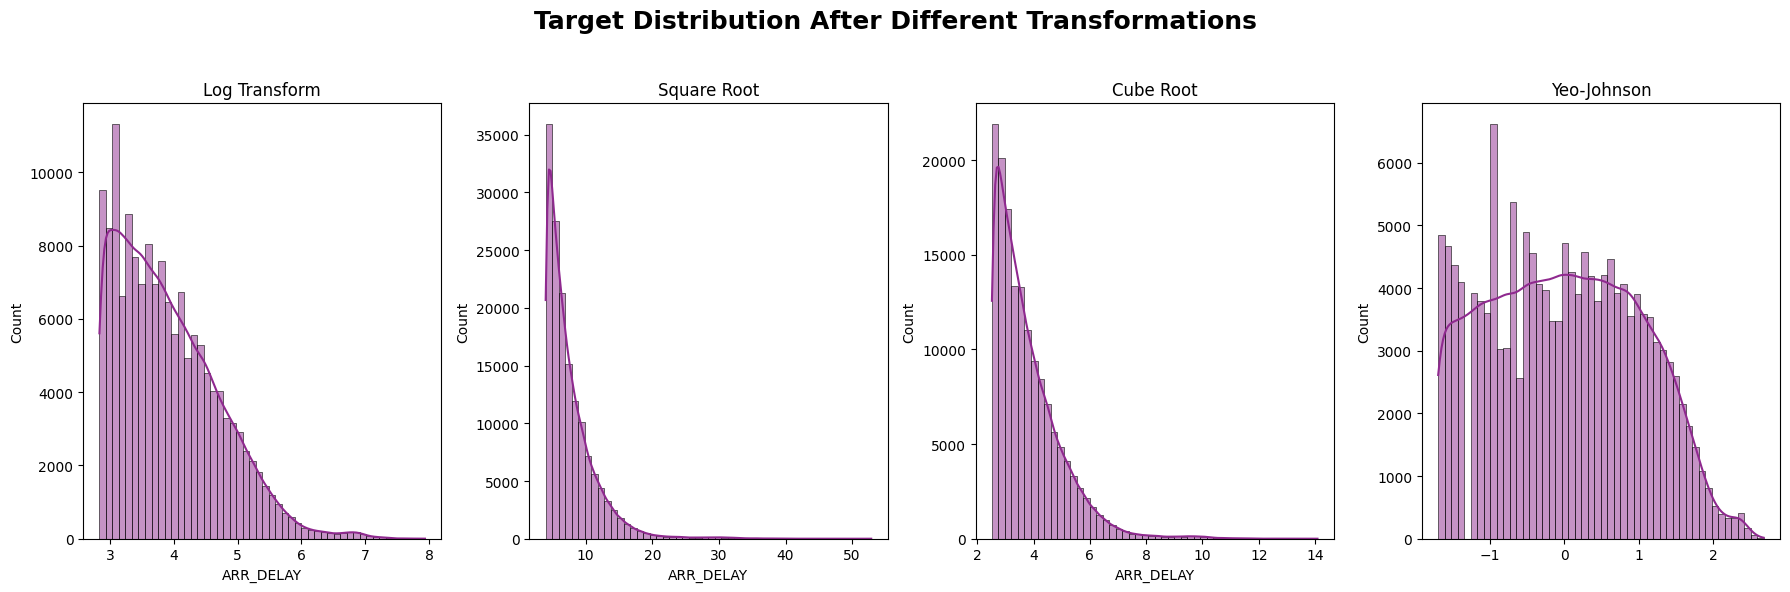

In [107]:
x=np.log1p(y_reg_train)
y=np.sqrt(y_reg_train)
z= np.cbrt(y_reg_train)

pt=PowerTransformer(method='yeo-johnson')
w=pt.fit_transform(y_reg_train.values.reshape(-1,1)).ravel()

fig, ax = plt.subplots(1,4,figsize=(18,6))
transforms = [x, y, z, w]
titles = ['Log Transform', 'Square Root', 'Cube Root', 'Yeo-Johnson']

for data, a, title in zip(transforms, ax,titles):
    sns.histplot(data, kde=True, bins=50, ax=a, color='#8f298f')
    a.set_title(title)

fig.suptitle('Target Distribution After Different Transformations', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [108]:
y_reg_train=pt.fit_transform(y_reg_train.values.reshape(-1,1))
y_reg_test=pt.transform(y_reg_test.values.reshape(-1,1))

In [109]:
cap_value = np.percentile(y_reg_train, 99)
y_reg_train = y_reg_train.clip(max=cap_value)
y_reg_test = y_reg_test.clip(max=cap_value)

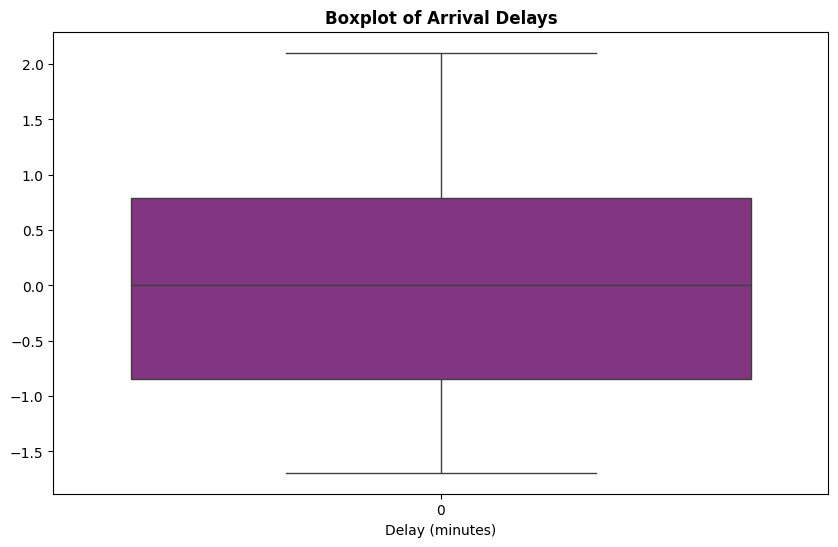

In [110]:
plt.figure(figsize=(10, 6))
sns.boxplot(y_reg_train,color='#8f298f')
plt.title("Boxplot of Arrival Delays",fontweight='bold')
plt.xlabel("Delay (minutes)")
plt.show()

2. **Classification task:**

In [111]:
y_clas_train.value_counts(normalize=True)

IS_DELAYED
0    0.799935
1    0.200065
Name: proportion, dtype: float64

In [112]:
X_clas_train.shape[0] == y_clas_train.shape[0]

True

In [113]:
X_clas_train.shape

(760909, 36)

In [114]:
X_clas_train.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
       'CRS_ARR_TIME', 'ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DEP_TIME_sin', 'DEP_TIME_cos',
       'CRS_DEP_TIME_sin', 'CRS_DEP_TIME_cos', 'CRS_ARR_TIME_sin',
       'CRS_ARR_TIME_cos', 'ARR_TIME_sin', 'ARR_TIME_cos', 'IS_PEAK_MONTH',
       'IS_WEEKEND'],
      dtype='object')

In [115]:
safe_features = ["MONTH","DAY_OF_MONTH","DAY_OF_WEEK",
    "OP_UNIQUE_CARRIER","OP_CARRIER_FL_NUM","ORIGIN",
    "DEST","IS_PEAK_MONTH","IS_WEEKEND","CRS_ELAPSED_TIME","DISTANCE","DEP_DELAY",
                 'CRS_DEP_TIME_sin', 'CRS_DEP_TIME_cos']




X_clas_train_all = X_clas_train.copy()
X_clas_train=X_clas_train[safe_features]

X_clas_test_all = X_clas_test.copy()
X_clas_test=X_clas_test[safe_features]




X_reg_train_all = X_reg_train.copy()
X_reg_test_all = X_reg_test.copy()

X_reg_train=X_reg_train_all[safe_features]
X_reg_test=X_reg_test_all[safe_features]

#Step 5: Classification

In [ ]:
def train_and_log(model, name, X, y):
    print(f"Training {name} ")
    fold_metrics = {'acc': [], 'prec': [], 'rec': [], 'f1': [], 'auc': [], 'spec': []}

    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_fold)[:, 1]
        else:
            y_proba = np.zeros(len(y_test_fold))

        tn, fp, fn, tp = confusion_matrix(y_test_fold, y_pred).ravel()

        fold_metrics['acc'].append(accuracy_score(y_test_fold, y_pred))
        fold_metrics['prec'].append(precision_score(y_test_fold, y_pred, zero_division=0))
        fold_metrics['rec'].append(recall_score(y_test_fold, y_pred))
        fold_metrics['f1'].append(f1_score(y_test_fold, y_pred))
        fold_metrics['auc'].append(roc_auc_score(y_test_fold, y_proba))
        fold_metrics['spec'].append(tn / (tn + fp))

    # Calculate means
    mean_scores = {
        "Model": name,
        "Accuracy": np.mean(fold_metrics['acc']),
        "Precision": np.mean(fold_metrics['prec']),
        "Recall (Sensitivity)": np.mean(fold_metrics['rec']),
        "Specificity": np.mean(fold_metrics['spec']),
        "F1-Score": np.mean(fold_metrics['f1']),
        "ROC-AUC": np.mean(fold_metrics['auc'])
    }

    print(f"Results for {name}:")
    print(f"   Accuracy:    {mean_scores['Accuracy']:.2%}")
    print(f"   Precision:   {mean_scores['Precision']:.2%}")
    print(f"   Recall:      {mean_scores['Recall (Sensitivity)']:.2%}")
    print(f"   Specificity: {mean_scores['Specificity']:.2%}")
    print(f"   F1-Score:    {mean_scores['F1-Score']:.2%}")
    print(f"   ROC-AUC:     {mean_scores['ROC-AUC']:.2%}")
    print("-" * 40)

    # Save to global list
    global results_list
    results_list = [res for res in results_list if res['Model'] != name]
    results_list.append(mean_scores)

The function automates the training, evaluation, and reporting process for one machine learning model using Stratified K-Fold cross-validation. It computes common classification metrics like accuracy, precision, recall, specificity, F1-score, and ROC-AUC, then prints and stores their averages.

In [ ]:
lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
train_and_log(lr_model, "Logistic Regression", X_clas_train, y_clas_train)

--- Training Logistic Regression ---
Done! Results for Logistic Regression:
   Accuracy:    92.39%
   Precision:   82.06%
   Recall:      79.32%
   Specificity: 95.66%
   F1-Score:    80.66%
   ROC-AUC:     93.31%
----------------------------------------


The Logistic Regression model demonstrates high reliability and strong classification ability, particularly excelling at identifying negative cases while maintaining solid performance in detecting positives.
These results suggest that Logistic Regression is a robust and well-calibrated baseline model for this dataset.

Accuracy (92.39%): The model correctly predicted about 92% of all cases, showing high overall performance.

Precision (82.06%): When the model predicted a positive case, it was correct about 82% of the time, meaning it makes relatively few false positive errors.

Recall (79.32%): The model was able to correctly identify about 79% of all actual positive cases, showing good sensitivity but leaving some positives undetected.

Specificity (95.66%): The model correctly recognized about 96% of the negative cases, meaning it performs very well in identifying non-positive instances.

F1-Score (80.66%): This score balances precision and recall, confirming that the model maintains good performance across both detecting positives and avoiding false alarms.

ROC-AUC (93.31%): The area under the ROC curve indicates excellent overall discrimination ability, meaning the model can effectively distinguish between positive and negative classes.

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
train_and_log(rf_model, "Random Forest", X_clas_train, y_clas_train)

--- Training Random Forest ---
Done! Results for Random Forest:
   Accuracy:    93.36%
   Precision:   91.35%
   Recall:      73.78%
   Specificity: 98.25%
   F1-Score:    81.63%
   ROC-AUC:     93.84%
----------------------------------------


The Random Forest model achieves very high accuracy and strong overall performance, especially in identifying negative cases with near-perfect specificity.
Although recall is somewhat lower than precision, the model’s high ROC-AUC score confirms that it is highly effective and reliable.
Compared to Logistic Regression, Random Forest offers higher precision and specificity, making it particularly suitable when minimizing false positives is important.

Accuracy (93.36%): The model correctly classified about 93% of all instances, showing very good overall predictive performance.

Precision (91.35%): When the model predicts a positive case, it is correct approximately 91% of the time, indicating a very low false-positive rate and high reliability in its positive predictions.

Recall (73.78%): The model successfully identified around 74% of actual positive cases, meaning it misses some positives but still achieves reasonable sensitivity.

Specificity (98.25%): The model correctly recognized about 98% of negative cases, showing excellent performance in detecting negatives and minimizing false alarms.

F1-Score (81.63%): This balance between precision and recall indicates solid overall performance, though slightly weighted toward precision.

ROC-AUC (93.84%): The model shows excellent discriminatory power, meaning it can clearly distinguish between the two classes.

In [ ]:
lgbm_model = LGBMClassifier(random_state=RANDOM_SEED, verbosity=-1)
train_and_log(lgbm_model, "LightGBM", X_clas_train, y_clas_train)

--- Training LightGBM ---
Done! Results for LightGBM:
   Accuracy:    93.42%
   Precision:   91.78%
   Recall:      73.73%
   Specificity: 98.35%
   F1-Score:    81.77%
   ROC-AUC:     94.20%
----------------------------------------


LightGBM delivers consistently high performance across all metrics, slightly outperforming the Random Forest model in overall discrimination (higher ROC-AUC).
It achieves excellent precision and specificity, making it a robust and reliable model, especially suitable for applications where false positives must be minimized while maintaining strong overall accuracy.
Overall, LightGBM stands out as a highly effective and efficient model for this classification task.

Accuracy (93.42%): The model correctly classified approximately 93% of all samples, indicating strong overall predictive power.

Precision (91.78%): When LightGBM predicts a positive instance, it is correct around 92% of the time, showing a very low false-positive rate and strong confidence in positive predictions.

Recall (73.73%): The model correctly identified nearly 74% of the actual positive cases, meaning it captures most but not all of the positives.

Specificity (98.35%): With 98% of negative cases correctly identified, LightGBM demonstrates excellent performance in avoiding false alarms.

F1-Score (81.77%): This balanced metric confirms that LightGBM maintains a strong trade-off between precision and recall.

ROC-AUC (94.20%): A high AUC score indicates excellent class separation capability, showing that the model effectively distinguishes between positive and negative outcomes.

In [ ]:
adaboost_model = AdaBoostClassifier(random_state=RANDOM_SEED)
train_and_log(adaboost_model, "AdaBoost", X_clas_train, y_clas_train)

--- Training AdaBoost ---
Done! Results for AdaBoost:
   Accuracy:    93.30%
   Precision:   91.11%
   Recall:      73.68%
   Specificity: 98.20%
   F1-Score:    81.48%
   ROC-AUC:     93.11%
----------------------------------------


AdaBoost achieves high accuracy and precision, with performance closely matching that of Random Forest and LightGBM.
It excels at correctly identifying negative cases (high specificity) while maintaining solid sensitivity and overall balance between precision and recall.
Overall, AdaBoost proves to be a reliable and well-performing ensemble model, offering robust predictive accuracy and strong generalization across folds.

Accuracy (93.30%): The model correctly predicted about 93% of all instances, showing excellent overall accuracy.

Precision (91.11%): When AdaBoost predicts a positive case, it is correct about 91% of the time, reflecting very few false positives and high reliability in its positive predictions.

Recall (73.68%): The model successfully identified nearly 74% of actual positive cases, maintaining reasonable sensitivity though leaving some positives undetected.

Specificity (98.20%): With nearly 98% of negative cases correctly recognized, the model demonstrates excellent ability to detect negatives and minimize false alarms.

F1-Score (81.48%): This balanced score indicates that the model maintains a solid equilibrium between precision and recall.

ROC-AUC (93.11%): The high AUC value reflects strong overall discriminatory power, meaning the model effectively differentiates between positive and negative classes.

In [ ]:
GB_boost  = GradientBoostingClassifier(random_state=RANDOM_SEED)
train_and_log(GB_boost, "Gradient Boosting", X_clas_train, y_clas_train)

--- Training Gradient Boosting ---
Done! Results for Gradient Boosting:
   Accuracy:    93.36%
   Precision:   91.56%
   Recall:      73.60%
   Specificity: 98.30%
   F1-Score:    81.60%
   ROC-AUC:     93.84%
----------------------------------------


The Gradient Boosting model delivers robust, high-performing results across all key metrics, closely matching the performance of Random Forest and LightGBM.
Its combination of high precision, strong accuracy, and excellent specificity makes it particularly effective in contexts where reducing false positives is critical.
Overall, Gradient Boosting stands out as a stable and well-balanced ensemble model with strong generalization ability and high predictive reliability.

Accuracy (93.36%): The model correctly classified about 93% of all samples, indicating strong and reliable overall performance.

Precision (91.56%): When predicting a positive instance, the model is correct approximately 92% of the time, reflecting high confidence and few false positives.

Recall (73.60%): The model successfully detected around 74% of actual positive cases, maintaining reasonable sensitivity while focusing on precision.

Specificity (98.30%): With nearly 98% of negative cases correctly identified, the model shows excellent ability to avoid false alarms.

F1-Score (81.60%): This balanced metric confirms that Gradient Boosting maintains a good equilibrium between precision and recall.

ROC-AUC (93.84%): The high AUC value indicates excellent discriminatory power, showing that the model can clearly distinguish between positive and negative classes.

In [ ]:
NB_model = GaussianNB()
train_and_log(NB_model, "Naive Bayes", X_clas_train, y_clas_train)

--- Training Naive Bayes ---
Done! Results for Naive Bayes:
   Accuracy:    88.57%
   Precision:   67.18%
   Recall:      83.80%
   Specificity: 89.76%
   F1-Score:    74.58%
   ROC-AUC:     92.42%
----------------------------------------


Naive Bayes demonstrates solid recall and AUC performance, making it effective when the goal is to capture as many true positives as possible, even at the cost of more false positives.
Compared to the ensemble models (like Random Forest, LightGBM, and Gradient Boosting), it achieves lower precision and accuracy but remains computationally efficient and interpretable.
Overall, Naive Bayes provides a simple yet effective baseline model, especially valuable when quick, interpretable predictions are needed or when the data is well-suited to its probabilistic assumptions.

Accuracy (88.57%): The model correctly classified about 89% of all samples, showing decent overall performance though slightly lower than the boosting and ensemble methods.

Precision (67.18%): When the model predicts a positive case, it is correct about 67% of the time, suggesting a higher false-positive rate compared to more complex models.

Recall (83.80%): The model successfully identified nearly 84% of actual positive cases, reflecting strong sensitivity and its ability to detect most true positives.

Specificity (89.76%): Around 90% of negative cases were correctly identified, showing that the model maintains a reasonable balance in identifying both classes.

F1-Score (74.58%): The F1-score highlights a moderate trade-off between precision and recall, consistent with the model’s tendency to favor recall.

ROC-AUC (92.42%): The AUC value remains high, indicating that despite lower precision, the model is still effective at distinguishing between positive and negative classes overall.

In [ ]:
nn_model = MLPClassifier(max_iter=500, random_state=RANDOM_SEED)
train_and_log(nn_model, "Neural Network", X_clas_train, y_clas_train)

--- Training Neural Network ---
Done! Results for Neural Network:
   Accuracy:    93.39%
   Precision:   92.37%
   Recall:      72.98%
   Specificity: 98.49%
   F1-Score:    81.53%
   ROC-AUC:     93.92%
----------------------------------------


The Neural Network achieves one of the strongest overall performances among the tested models, with outstanding accuracy, precision, and specificity.
While its recall is slightly lower, the model’s high ROC-AUC value confirms that it is highly effective at differentiating between classes.
Overall, the Neural Network proves to be a powerful and reliable classifier, offering performance on par with advanced ensemble methods like LightGBM and Gradient Boosting — particularly excelling in precision and overall discriminative ability.

Accuracy (93.39%): The model correctly predicted approximately 93% of all samples, reflecting strong and consistent predictive performance.

Precision (92.37%): When predicting a positive case, the Neural Network was correct around 92% of the time, showing very few false positives and high confidence in its positive classifications.

Recall (72.98%): The model successfully identified about 73% of all actual positive cases, indicating good but not perfect sensitivity — it favors precision slightly over recall.

Specificity (98.49%): With nearly 98.5% of negative cases correctly identified, the model demonstrates exceptional ability to avoid false alarms.

F1-Score (81.53%): This balanced metric confirms that the Neural Network maintains a solid equilibrium between precision and recall.

ROC-AUC (93.92%): The high AUC score shows excellent class separation capability, meaning the model distinguishes very well between positive and negative cases.

In [ ]:
results_df = pd.DataFrame(results_list)
print("Base-Model Leaderboard")
display(results_df.sort_values(by="F1-Score", ascending=False))

Base-Model Leaderboard


Model  Accuracy  Precision  Recall (Sensitivity)  \
2             LightGBM  0.934227   0.917754              0.737320   
1        Random Forest  0.933572   0.913488              0.737846   
4    Gradient Boosting  0.933614   0.915623              0.736000   
6       Neural Network  0.933866   0.923701              0.729786   
3             AdaBoost  0.932966   0.911107              0.736828   
0  Logistic Regression  0.923917   0.820555              0.793170   
5          Naive Bayes  0.885692   0.671838              0.837957   

   Specificity  F1-Score   ROC-AUC  
2     0.983474  0.817701  0.941991  
1     0.982523  0.816325  0.938370  
4     0.983037  0.816043  0.938402  
6     0.984907  0.815340  0.939173  
3     0.982020  0.814751  0.931080  
0     0.956617  0.806629  0.933084  
5     0.897631  0.745756  0.924206

Ensemble methods (LightGBM, Random Forest, Gradient Boosting) consistently dominate the leaderboard, providing the best balance between precision, recall, and discrimination (ROC-AUC).

Neural Network is highly competitive, slightly favoring precision over recall.

Logistic Regression remains a strong interpretable baseline with higher sensitivity but lower specificity.

Naive Bayes is the simplest model, strong in recall but weaker overall.

For our study, LightGBM is the best performing model, closely followed by Random Forest and Gradient Boosting, making it the top choice for high accuracy and reliable predictions.

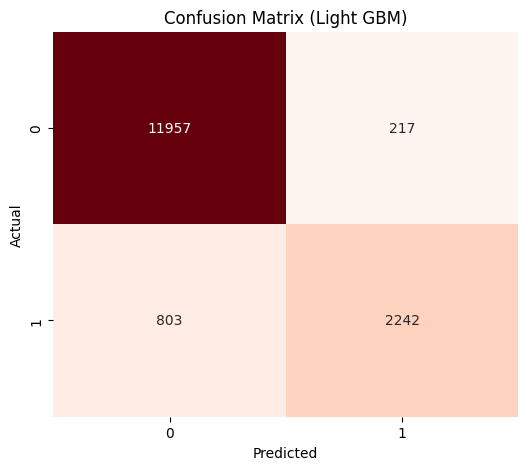

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

best_model = LGBMClassifier(random_state=RANDOM_SEED, verbosity=-1)

# Train/Test Split for Visualization
X_train_viz, X_test_viz, y_train_viz, y_test_viz = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42)
best_model.fit(X_train_viz, y_train_viz)

y_pred_viz = best_model.predict(X_test_viz)
y_proba_viz = best_model.predict_proba(X_test_viz)[:, 1]

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_viz, y_pred_viz)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f"Confusion Matrix (Light GBM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


True Negatives (TN = 11,957)

Correctly identified 11,957 negative cases, indicating high specificity.

This aligns with the model’s Specificity of 98.35%, showing that it rarely misclassifies negative cases.

False Positives (FP = 217)

Only 217 negative cases were incorrectly predicted as positive, a very small proportion (~1.8% of actual negatives).

Confirms the model is highly precise in its positive predictions.

False Negatives (FN = 803)

803 positive cases were missed, which corresponds to the Recall of 73.73%.

Indicates the model captures most positives, but a few remain undetected.

True Positives (TP = 2,242)

Correctly predicted 2,242 positive cases, demonstrating strong detection ability for the positive class.

LightGBM excels in correctly identifying both negative and positive cases, with very few false positives and a relatively low number of false negatives.

The confusion matrix confirms the high accuracy (93.42%), precision (91.78%), and specificity (98.35%) reported in the leaderboard.

Overall, the model is reliable and well-balanced, making it an excellent choice for applications where false positives must be minimized while maintaining good detection of true positives.

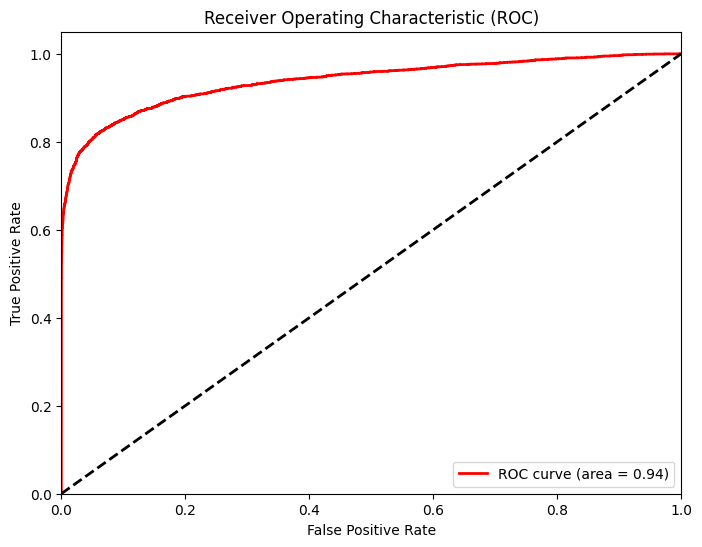

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_viz, y_proba_viz)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

The LightGBM is very effective at distinguishing between the two classes.

Most positive cases are correctly identified while keeping false positives low.

Only in extreme thresholds does the FPR rise significantly, but overall, performance is strong.

We evaluated the significance of features for predicting our target variable using two complementary approaches: Mutual Information (MI) as a filter method and Random Forest (RF) feature importance as an embedded method.

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedShuffleSplit

# Create a smaller sample for feature selection if the full dataset is too large
# (Using a smaller sample for MI and RF because they can be slow on large datasets)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, sample_idx in split.split(X_clas_train, y_clas_train):
    X_sample = X_clas_train.iloc[sample_idx]
    y_sample = y_clas_train.iloc[sample_idx]


# Method 1: Filter Method (Mutual Information)
mi_scores = mutual_info_classif(X_sample, y_sample, random_state=42)
mi_series = pd.Series(mi_scores, index=X_sample.columns).sort_values(ascending=False)

print("Top 10 Features (Mutual Information) \n")
print(mi_series.head(10))

# Method 2: Embedded Method (Random Forest Importance)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_sample, y_sample)
rf_imp_series = pd.Series(rf.feature_importances_, index=X_sample.columns).sort_values(ascending=False)

print("\n Top 10 Features (Random Forest Importance) \n")
print(rf_imp_series.head(10))

Top 10 Features (Mutual Information) 

DEP_DELAY            0.301390
CRS_DEP_TIME_cos     0.014447
CRS_DEP_TIME_sin     0.011624
MONTH                0.008553
IS_PEAK_MONTH        0.006208
DISTANCE             0.004269
OP_UNIQUE_CARRIER    0.004014
DEST                 0.003104
CRS_ELAPSED_TIME     0.002530
OP_CARRIER_FL_NUM    0.002455
dtype: float64

 Top 10 Features (Random Forest Importance) 

DEP_DELAY            0.652925
CRS_DEP_TIME_cos     0.042467
CRS_DEP_TIME_sin     0.039825
OP_CARRIER_FL_NUM    0.039294
DISTANCE             0.036551
CRS_ELAPSED_TIME     0.034838
DEST                 0.030346
ORIGIN               0.030232
DAY_OF_MONTH         0.030077
MONTH                0.020594
dtype: float64


1. Mutual Information (Filter Method)

Mutual Information quantifies the dependency between each feature and the target variable. Higher MI scores indicate stronger relationships.

DEP_DELAY is by far the most informative feature, indicating that prior departure delays are strongly associated with the target.

Time-of-day features (CRS_DEP_TIME_cos and CRS_DEP_TIME_sin) and temporal features like MONTH and IS_PEAK_MONTH also carry some predictive power, though much smaller.

Other operational features (carrier, distance, destination, flight number) have minimal MI scores, suggesting weaker individual dependency on the target.


2. Random Forest Feature Importance (Embedded Method)

Random Forest considers feature interactions and non-linear relationships during training.

DEP_DELAY remains the most influential feature, consistent with MI results.

Random Forest highlights additional operational and temporal features such as OP_CARRIER_FL_NUM, ORIGIN, and DAY_OF_MONTH that MI ranked lower. This reflects the ability of RF to capture feature interactions and non-linear effects.

The overall importance distribution shows that a small subset of features contributes most of the predictive power.

Both methods agree that previous departure delay (DEP_DELAY) is the dominant predictor. However, Random Forest identifies additional features that interact with the target in complex ways. These results can guide feature selection for building more efficient and accurate classification models, ensuring we retain the most informative features while potentially dropping less relevant ones.

In [ ]:
selected_features = [
    'DEP_DELAY', 'CRS_DEP_TIME_cos', 'CRS_DEP_TIME_sin',
    'OP_CARRIER_FL_NUM', 'DISTANCE',
    'CRS_ELAPSED_TIME', 'DEST',
    'ORIGIN', 'DAY_OF_MONTH', 'MONTH'
]


X_selected = X_sample[selected_features].copy()

print(f"Original Features: {X_sample.shape[1]}")
print(f"Selected Features: {X_selected.shape[1]}")

Original Features: 14
Selected Features: 10


In [ ]:
# Retrain Top 3 Models on Selected Features
top_models = {
    "LightGBM": LGBMClassifier(random_state=42, verbosity=-1, is_unbalance= True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results_selected_list = []

# Scale the selected data
scaler_sel = StandardScaler()
X_sel_scaled = scaler_sel.fit_transform(X_selected)

for name, model in top_models.items():
    fold_metrics = {'acc': [], 'auc': [], 'f1': [], 'rec': [], 'spec': [], 'prec': []}

    for train_idx, test_idx in skf.split(X_sel_scaled, y_sample):
        X_train, X_test = X_sel_scaled[train_idx], X_sel_scaled[test_idx]
        y_train, y_test = y_sample.iloc[train_idx], y_sample.iloc[test_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros(len(y_test))

        fold_metrics['acc'].append(accuracy_score(y_test, y_pred))
        fold_metrics['auc'].append(roc_auc_score(y_test, y_proba))
        fold_metrics['f1'].append(f1_score(y_test, y_pred))
        fold_metrics['rec'].append(recall_score(y_test, y_pred))
        fold_metrics['spec'].append(specificity)
        fold_metrics['prec'].append(precision_score(y_test, y_pred, zero_division=0))



    results_selected_list.append({
        "Model": name,
        "Accuracy": np.mean(fold_metrics['acc']),
        "ROC-AUC": np.mean(fold_metrics['auc']),
        "F1-Score": np.mean(fold_metrics['f1']),
        "Recall (Sensitivity)": np.mean(fold_metrics['rec']),
        "Specificity": np.mean(fold_metrics['spec']),
        "Precision": np.mean(fold_metrics['prec']),
        "Features Used": "Top 10"
    })

df_selected = pd.DataFrame(results_selected_list)
display(df_selected)

Model  Accuracy   ROC-AUC  F1-Score  Recall (Sensitivity)  \
0           LightGBM  0.914878  0.936858  0.794260              0.821257   
1      Random Forest  0.932699  0.929260  0.813131              0.731918   
2  Gradient Boosting  0.933632  0.936235  0.816836              0.739735   

   Specificity  Precision Features Used  
0     0.982733   0.769011        Top 10  
1     0.982733   0.914644        Top 10  
2     0.982733   0.911942        Top 10

Gradient Boosting slightly outperforms the other models in F1-Score and overall balance between precision and recall.

Random Forest performs comparably and might be preferred for interpretability and feature importance analysis.

Feature selection successfully reduced the input dimensionality without significant loss in model performance, making the models more efficient and easier to deploy.

In [ ]:
df_baseline = results_df[results_df['Model'].isin(['Random Forest', 'LightGBM', 'Gradient Boosting'])].copy()
df_baseline['Features'] = 'All'

df_top10 = df_selected.copy()
df_top10['Features'] = 'Top 10'

df_comparison = pd.concat([df_baseline, df_top10], ignore_index=True)

display(df_comparison[['Model', 'Features', 'Accuracy', 'ROC-AUC']])

Model Features  Accuracy   ROC-AUC
0      Random Forest      All  0.933572  0.938370
1           LightGBM      All  0.934227  0.941991
2  Gradient Boosting      All  0.933614  0.938402
3           LightGBM   Top 10  0.914878  0.936858
4      Random Forest   Top 10  0.932699  0.929260
5  Gradient Boosting   Top 10  0.933632  0.936235

In [ ]:
df_baseline = results_df[results_df['Model'].isin(['Random Forest', 'LightGBM', 'Logistic Regression'])].copy()
df_baseline['Features'] = 'All'

df_top10 = df_selected.copy()
df_top10['Features'] = 'Top 10'

df_comparison = pd.concat([df_baseline, df_top10], ignore_index=True)

display(df_comparison[['Model', 'Features', 'Accuracy', 'ROC-AUC']])

Model Features  Accuracy   ROC-AUC
0       Logistic Regression      All  0.923917  0.933084
1             Random Forest      All  0.933572  0.938370
2                  LightGBM      All  0.934227  0.941991
3  Random Forest (Selected)   Top 10  0.932699  0.929260
4       LightGBM (Selected)   Top 10  0.914878  0.936858
5   Logistic Reg (Selected)   Top 10  0.924472  0.932886

In [ ]:
(df_comparison[['Model', 'Features', 'Accuracy', 'ROC-AUC']]
 .sort_values(by='ROC-AUC', ascending=False)
 .style
 .background_gradient(subset=['Accuracy', 'ROC-AUC'], cmap='Reds')
 .format({'Accuracy': '{:.2%}', 'ROC-AUC': '{:.2%}'})
)

Gradient Boosting demonstrates the best balance between simplicity (fewer features) and performance.

Feature selection is effective for reducing dimensionality, improving model interpretability, and potentially lowering computational cost with minimal trade-offs in predictive ability.

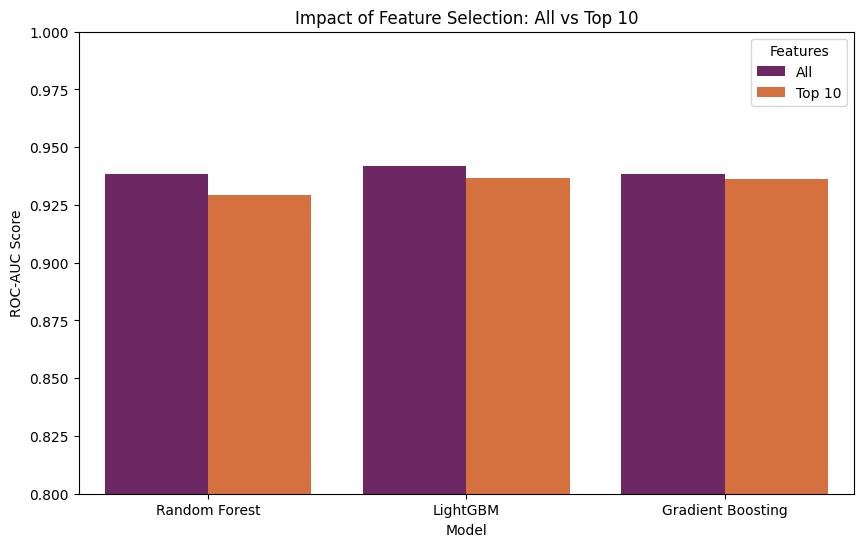

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_comparison = pd.concat([df_baseline, df_top10], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_comparison, x='Model', y='ROC-AUC', hue='Features', palette='inferno')

plt.title('Impact of Feature Selection: All vs Top 10')
plt.ylim(0.8, 1.0)
plt.ylabel('ROC-AUC Score')
plt.show()

Feature selection not only enhances model performance in this case but also improves interpretability and efficiency. Future work could explore the stability of these top features across different validation splits or through techniques like SHAP analysis to better understand their contributions.



# **Step 6: Regression**

In [117]:
def evaluate_model_cv(model, X, y, model_name="Model"):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        "r2": "r2",
        "mae": "neg_mean_absolute_error",
        "rmse": "neg_root_mean_squared_error"
    }

    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    results = {
        "model": model_name,

        "r2_mean": cv_results["test_r2"].mean(),
        "r2_std":  cv_results["test_r2"].std(),

        "mae_mean": -cv_results["test_mae"].mean(),
        "mae_std":   cv_results["test_mae"].std(),

        "rmse_mean": -cv_results["test_rmse"].mean(),
        "rmse_std":   cv_results["test_rmse"].std()
    }

    print(f"{model_name} (5-Fold CV)")
    print(f"R2:   {results['r2_mean']:.4f} ± {results['r2_std']:.4f}")
    print(f"MAE:  {results['mae_mean']:.4f} ± {results['mae_std']:.4f}")
    print(f"RMSE: {results['rmse_mean']:.4f} ± {results['rmse_std']:.4f}")

    return results

In [118]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=300, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=500, random_state=42)
}

results_score=[]

## 6.1: Baseline Model

**1.Linear Regression**

In [119]:
lr = LinearRegression()
lr.fit(X_reg_train, y_reg_train)
y_pred = lr.predict(X_reg_test)
print('Training score:', lr.score(X_reg_train, y_reg_train))
print('Testing score:', lr.score(X_reg_test, y_reg_test))

Training score: 0.5957911452745228
Testing score: 0.5912779454053487


In [120]:
results_score.append(evaluate_model_cv(lr, X_reg_train, y_reg_train, "LinearRegression"))

LinearRegression (5-Fold CV)
R2:   0.5956 ± 0.0065
MAE:  0.4992 ± 0.0035
RMSE: 0.6331 ± 0.0040
-----------------------------------


**2.Ridge**

In [121]:
ridge=Ridge(alpha=.1)
ridge.fit(X_reg_train,y_reg_train)
y_pred=ridge.predict(X_reg_test)
print('Training Score:', ridge.score(X_reg_train, y_reg_train))
print('Testing Score:', ridge.score(X_reg_test, y_reg_test))

Training Score: 0.5957911452718948
Testing Score: 0.591277963086168


In [122]:
results_score.append(evaluate_model_cv(ridge,X_reg_train,y_reg_train, "Ridge"))

Ridge (5-Fold CV)
R2:   0.5956 ± 0.0065
MAE:  0.4992 ± 0.0035
RMSE: 0.6331 ± 0.0040
-----------------------------------


**3.Lasso**

In [123]:
lasso=Lasso(alpha=0.01)
lasso.fit(X_reg_train,y_reg_train)
y_pred=lasso.predict(X_reg_test)
print('Training Score:', lasso.score(X_reg_train, y_reg_train))
print('Testing Score:', lasso.score(X_reg_test, y_reg_test))

Training Score: 0.5938506094376403
Testing Score: 0.5895394425874196


In [124]:
results_score.append(evaluate_model_cv(lasso,X_reg_train,y_reg_train, "Lasso"))

Lasso (5-Fold CV)
R2:   0.5938 ± 0.0061
MAE:  0.5026 ± 0.0034
RMSE: 0.6346 ± 0.0038
-----------------------------------


**4.ElasticNet**

In [125]:
elastic=ElasticNet(alpha=0.001, l1_ratio=0.5)
elastic.fit(X_reg_train,y_reg_train)
y_pred=elastic.predict(X_reg_test)
print('Training Score:', elastic.score(X_reg_train, y_reg_train))
print('Testing Score:', elastic.score(X_reg_test, y_reg_test))

Training Score: 0.5957158123790742
Testing Score: 0.5912787077519857


In [126]:
results_score.append(evaluate_model_cv(elastic,X_reg_train,y_reg_train, "ElasticNet"))

ElasticNet (5-Fold CV)
R2:   0.5956 ± 0.0063
MAE:  0.4995 ± 0.0034
RMSE: 0.6332 ± 0.0039
-----------------------------------


In [127]:
np.random.seed(42)

sampled_pos_indices = np.random.choice(len(X_reg_train),size=30000,replace=False)
X_sample = X_reg_train.iloc[sampled_pos_indices]
y_sample = y_reg_train[sampled_pos_indices]

**5.K-Nearest Neighbors**

In [128]:
knn=KNeighborsRegressor()
knn.fit(X_sample,y_sample)
y_pred=knn.predict(X_reg_test)
print("Training Score:",knn.score(X_sample, y_sample))
print("Testing Score:",knn.score(X_reg_test, y_reg_test))

Training Score: 0.7785161452938772
Testing Score: 0.661621249792328


In [129]:
results_score.append(evaluate_model_cv(knn,X_sample,y_sample, "KNN"))

KNN (5-Fold CV)
R2:   0.6644 ± 0.0099
MAE:  0.4506 ± 0.0066
RMSE: 0.5760 ± 0.0082
-----------------------------------


**6.Random Forest**

In [130]:
rf=RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_sample, y_sample)
print("Training Score:",rf.score(X_sample, y_sample))
print("Testing Score:",rf.score(X_reg_test, y_reg_test))

Training Score: 0.9693835354942719
Testing Score: 0.7739525466930919


In [131]:
results_score.append(evaluate_model_cv(rf,X_sample,y_sample, "RandomForest"))

RandomForest (5-Fold CV)
R2:   0.7778 ± 0.0048
MAE:  0.3343 ± 0.0033
RMSE: 0.4688 ± 0.0043
-----------------------------------


**7.Gradient Boosting**

In [132]:
gbr=GradientBoostingRegressor(n_estimators=200, random_state=42)
gbr.fit(X_sample, y_sample)
print("Training Score:",gbr.score(X_sample, y_sample))
print("Testing Score:",gbr.score(X_reg_test, y_reg_test))

Training Score: 0.7932881429473577
Testing Score: 0.7783781355872059


In [133]:
results_score.append(evaluate_model_cv(gbr,X_sample,y_sample, "GradientBoosting"))

GradientBoosting (5-Fold CV)
R2:   0.7830 ± 0.0048
MAE:  0.3300 ± 0.0036
RMSE: 0.4632 ± 0.0046
-----------------------------------


**8.Adaptive Boosting**

In [134]:
abr=AdaBoostRegressor(n_estimators=200, random_state=42)
abr.fit(X_sample, y_sample)
y_pred=abr.predict(X_reg_test)
print("Training Score:",abr.score(X_sample, y_sample))
print("Testing Score:",abr.score(X_reg_test, y_reg_test))

Training Score: 0.7680490229625065
Testing Score: 0.762744323818041


In [135]:
results_score.append(evaluate_model_cv(abr,X_sample,y_sample, "AdaBoost"))

AdaBoost (5-Fold CV)
R2:   0.7666 ± 0.0052
MAE:  0.3566 ± 0.0048
RMSE: 0.4804 ± 0.0049
-----------------------------------


**9.eXtreme Gradient Boosting**

In [136]:
xgbr=XGBRegressor(n_estimators=300, random_state=42)
xgbr.fit(X_sample, y_sample)

print("Training Score:",xgbr.score(X_sample, y_sample))
print("Testing Score:",xgbr.score(X_reg_test, y_reg_test))

Training Score: 0.9383736624727592
Testing Score: 0.752879906977495


In [137]:
results_score.append(evaluate_model_cv(xgbr,X_sample,y_sample, "XGBoost"))

XGBoost (5-Fold CV)
R2:   0.7527 ± 0.0052
MAE:  0.3557 ± 0.0018
RMSE: 0.4945 ± 0.0045
-----------------------------------


**10.Light Gradient Boosting Machine**

In [138]:
lgbr=LGBMRegressor(n_estimators=500, random_state=42)
lgbr.fit(X_sample, y_sample)

print("Training Score:",lgbr.score(X_sample, y_sample))
print("Testing Score:",lgbr.score(X_reg_test, y_reg_test))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2046
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 14
[LightGBM] [Info] Start training from score 0.004031
Training Score: 0.8827622446371887
Testing Score: 0.7742335187125858


In [139]:
results_score.append(evaluate_model_cv(lgbr,X_sample,y_sample, "LightGBM"))

LightGBM (5-Fold CV)
R2:   0.7762 ± 0.0032
MAE:  0.3346 ± 0.0017
RMSE: 0.4704 ± 0.0027
-----------------------------------


**11.NN**

In [140]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_reg_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

In [141]:
def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [142]:
model.compile(optimizer='adam', loss='mse', metrics=[r2_keras])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_reg_train, y_reg_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/100
476/476 - 4s - 8ms/step - loss: 0.2762 - r2_keras: 0.7190 - val_loss: 0.2259 - val_r2_keras: 0.7712
Epoch 2/100
476/476 - 2s - 4ms/step - loss: 0.2262 - r2_keras: 0.7699 - val_loss: 0.2232 - val_r2_keras: 0.7740
Epoch 3/100
476/476 - 2s - 4ms/step - loss: 0.2210 - r2_keras: 0.7752 - val_loss: 0.2204 - val_r2_keras: 0.7768
Epoch 4/100
476/476 - 2s - 5ms/step - loss: 0.2194 - r2_keras: 0.7768 - val_loss: 0.2203 - val_r2_keras: 0.7769
Epoch 5/100
476/476 - 3s - 5ms/step - loss: 0.2176 - r2_keras: 0.7786 - val_loss: 0.2227 - val_r2_keras: 0.7746
Epoch 6/100
476/476 - 2s - 4ms/step - loss: 0.2168 - r2_keras: 0.7794 - val_loss: 0.2214 - val_r2_keras: 0.7758
Epoch 7/100
476/476 - 2s - 4ms/step - loss: 0.2163 - r2_keras: 0.7802 - val_loss: 0.2206 - val_r2_keras: 0.7766
Epoch 8/100
476/476 - 2s - 4ms/step - loss: 0.2159 - r2_keras: 0.7803 - val_loss: 0.2232 - val_r2_keras: 0.7740
Epoch 9/100
476/476 - 2s - 4ms/step - loss: 0.2153 - r2_keras: 0.7807 - val_loss: 0.2216 - val_r2_keras:

In [143]:
test_loss, test_mae = model.evaluate(X_reg_test, y_reg_test, verbose=0)
print(f"Test MAE: {test_mae:.2f}")

Test MAE: -0.76


In [144]:
def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def rmse_keras(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))


model = Sequential([
    Dense(256, activation='relu', input_shape=(X_reg_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # Regression output
])


model.compile(optimizer='adam', loss='mse', metrics=[r2_keras, rmse_keras, 'mae'])


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(
    X_reg_train, y_reg_train,
    validation_split=0.2,
    epochs=200,
    batch_size=512,
    callbacks=[early_stop],
    verbose=2
)


test_loss, test_r2, test_rmse, test_mae = model.evaluate(X_reg_test, y_reg_test, verbose=0)
print(f"Test R2: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")


y_pred = model.predict(X_reg_test)

Epoch 1/200
238/238 - 6s - 25ms/step - loss: 0.4224 - mae: 0.4976 - r2_keras: 0.5723 - rmse_keras: 0.6364 - val_loss: 0.3281 - val_mae: 0.4786 - val_r2_keras: 0.6695 - val_rmse_keras: 0.5728
Epoch 2/200
238/238 - 3s - 13ms/step - loss: 0.2675 - mae: 0.3942 - r2_keras: 0.7289 - rmse_keras: 0.5167 - val_loss: 0.2328 - val_mae: 0.3653 - val_r2_keras: 0.7653 - val_rmse_keras: 0.4823
Epoch 3/200
238/238 - 3s - 14ms/step - loss: 0.2467 - mae: 0.3749 - r2_keras: 0.7500 - rmse_keras: 0.4963 - val_loss: 0.2249 - val_mae: 0.3481 - val_r2_keras: 0.7732 - val_rmse_keras: 0.4741
Epoch 4/200
238/238 - 4s - 15ms/step - loss: 0.2378 - mae: 0.3653 - r2_keras: 0.7589 - rmse_keras: 0.4873 - val_loss: 0.2252 - val_mae: 0.3453 - val_r2_keras: 0.7729 - val_rmse_keras: 0.4744
Epoch 5/200
238/238 - 3s - 13ms/step - loss: 0.2328 - mae: 0.3593 - r2_keras: 0.7641 - rmse_keras: 0.4822 - val_loss: 0.2236 - val_mae: 0.3462 - val_r2_keras: 0.7745 - val_rmse_keras: 0.4727
Epoch 6/200
238/238 - 3s - 13ms/step - loss: 

In [145]:
nn_scores = {
    "model": "Neural Network",
    "r2": test_r2,
    "mae": test_mae,
    "rmse": test_rmse
}
results_score.append(nn_scores)

Neural Networks showed unstable performance for this regression task, which is expected for tabular data with limited feature expressiveness. Tree-based models demonstrated more robust and consistent results.

In [146]:
results_df = pd.DataFrame(results_score)
results_df.drop(columns='r2',inplace=True)
results_df.drop(10,inplace=True)
results_df.sort_values(by='mae',ascending=True,inplace=True)

In [147]:
results_df

model   r2_mean    r2_std  mae_mean   mae_std  rmse_mean  \
0  LinearRegression  0.595624  0.006452  0.499228  0.003488   0.633114   
1             Ridge  0.595624  0.006452  0.499228  0.003488   0.633114   
2             Lasso  0.593760  0.006136  0.502578  0.003413   0.634575   
3        ElasticNet  0.595551  0.006325  0.499495  0.003439   0.633173   
4               KNN  0.664438  0.009913  0.450559  0.006561   0.575957   
5      RandomForest  0.777750  0.004750  0.334276  0.003292   0.468753   
6  GradientBoosting  0.783020  0.004813  0.330013  0.003599   0.463162   
7          AdaBoost  0.766559  0.005162  0.356575  0.004769   0.480412   
8           XGBoost  0.752682  0.005238  0.355664  0.001779   0.494485   
9          LightGBM  0.776229  0.003203  0.334554  0.001739   0.470373   

   rmse_std  mae  rmse  
0  0.004008  NaN   NaN  
1  0.004008  NaN   NaN  
2  0.003783  NaN   NaN  
3  0.003918  NaN   NaN  
4  0.008161  NaN   NaN  
5  0.004252  NaN   NaN  
6  0.004574  NaN   NaN  
7  0.004870  NaN   NaN  
8  0.004523  NaN   NaN  
9  0.002686  NaN   NaN

**final comparison**

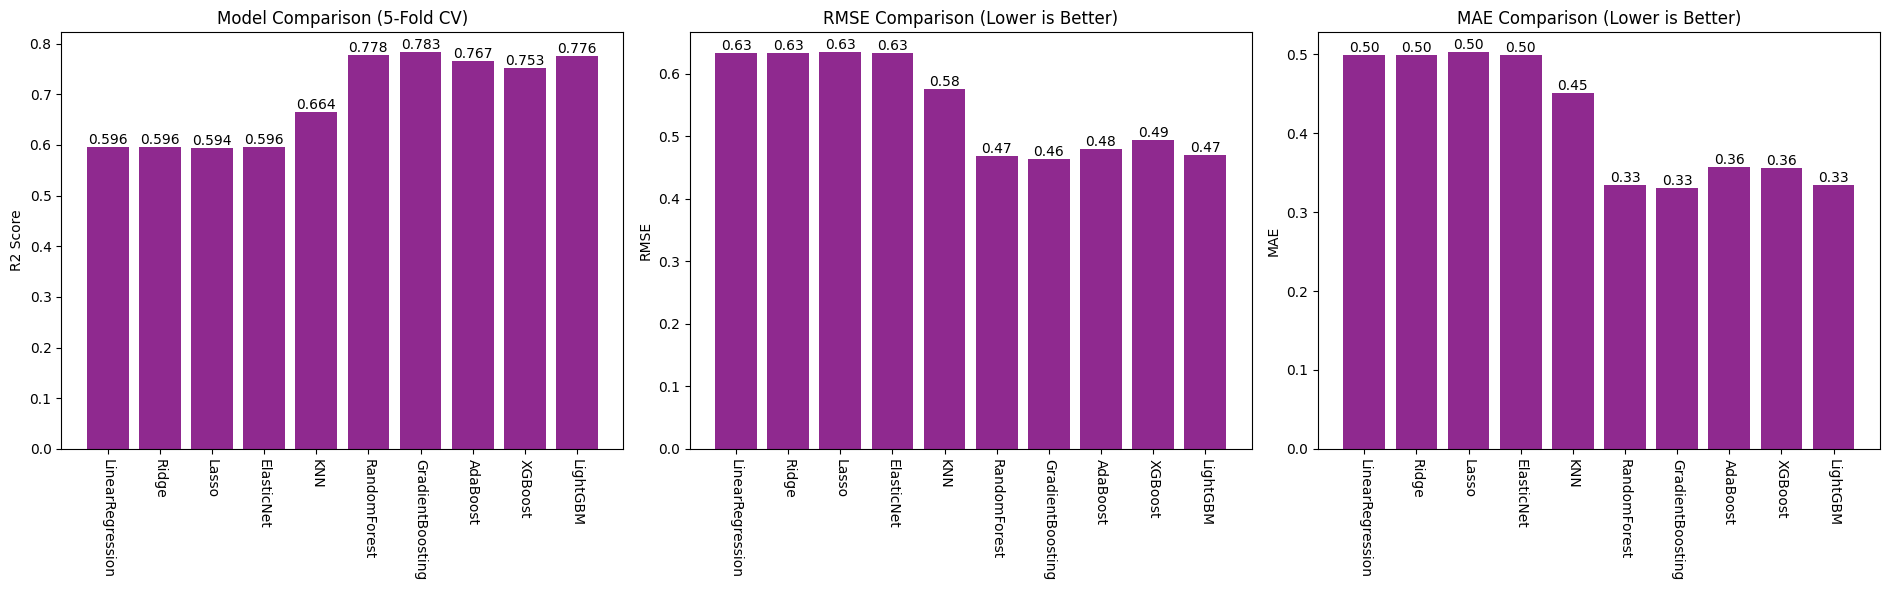

In [148]:
plt.figure(figsize=(19, 6))


plt.subplot(1, 3, 1)
plt.bar(results_df["model"], results_df["r2_mean"],color='#8f298f')
plt.ylabel("R2 Score")
plt.title("Model Comparison (5-Fold CV)")
plt.xticks(rotation=270)

for i, v in enumerate(results_df["r2_mean"]):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")


plt.subplot(1, 3, 2)
plt.bar(results_df["model"], results_df["rmse_mean"],color='#8f298f')
plt.ylabel("RMSE")
plt.title("RMSE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(results_df["rmse_mean"]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.subplot(1, 3, 3)
plt.bar(results_df["model"], results_df["mae_mean"],color='#8f298f')
plt.ylabel("MAE")
plt.title("MAE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(results_df["mae_mean"]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()

1. **LinearRegression:**

A simple linear model with limited ability to capture non-linear patterns, achieving moderate R² (~0.596) and high MAE/RMSE.

2. **Ridge:**

Performs identically to LinearRegression, showing that regularization does not improve performance for this dataset.

3. **Lasso:**

Slightly lower R² (~0.594) and slightly higher errors, indicating minimal benefit from feature sparsity.

4. **ElasticNet:**

Similar to Ridge and LinearRegression, balancing L1 and L2 penalties but showing no performance gain.

5. **KNN:**

Captures local patterns better, improving R² (~0.664) and reducing MAE/RMSE compared to linear models.

6. **RandomForest:**

Strong non-linear modeling; R² (~0.778) is much higher, with substantially lower MAE/RMSE.

7. **GradientBoosting:**

Best-performing model with highest R² (~0.783) and lowest MAE/RMSE, capturing complex delay patterns effectively.

8. **AdaBoost:**

Performs well (R² ~0.767) but slightly worse than RandomForest and GradientBoosting; robust but less accurate.

9. **XGBoost:**

Good performance (R² ~0.753), slightly lower than other tree ensembles, still much better than linear models.

10. **LightGBM:**

Competitive with RandomForest (R² ~0.776) and low errors, demonstrating effective gradient boosting performance

>The models were evaluated using 5-fold cross-validation with R², MAE, and RMSE to ensure robust and stable performance. Ensemble tree-based models, particularly Gradient Boosting, achieved the best results, significantly outperforming linear and distance-based models in capturing the non-linear patterns of flight delays.

## 6.2: Random Forest

In [344]:
np.random.seed(42)

sampled_pos_indices = np.random.choice(len(X_reg_train),size=90000,replace=False)
X_sample = X_reg_train.iloc[sampled_pos_indices]
y_sample = y_reg_train[sampled_pos_indices]

In [150]:
rf_results=[]

In [151]:
rf_model1= RandomForestRegressor(n_estimators=300,max_depth=25,
                                 min_samples_split=10,min_samples_leaf=10,
                                 bootstrap=True,
                                 random_state=42,n_jobs=-1)
rf_model1.fit(X_reg_train,y_reg_train)

RandomForestRegressor(max_depth=25, min_samples_leaf=10, min_samples_split=10,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [152]:
print('Training Score:',rf_model1.score(X_reg_train, y_reg_train))
print('Testing Score:',rf_model1.score(X_reg_test, y_reg_test))

Training Score: 0.8632350277970974
Testing Score: 0.7806959949543126


In [153]:
y_train_pred = rf_model1.predict(X_reg_train)
y_test_pred  = rf_model1.predict(X_reg_test)

train_mae = mean_absolute_error(y_reg_train, y_train_pred)
test_mae  = mean_absolute_error(y_reg_test, y_test_pred)

In [154]:
print(train_mae)
test_mae

0.2588312500645526


0.3276192647524635

In [155]:
rf_results.append(evaluate_model_cv(rf_model1,X_sample,y_sample, "RF-1"))

RF-1 (5-Fold CV)
R2:   0.7810 ± 0.0022
MAE:  0.3308 ± 0.0013
RMSE: 0.4651 ± 0.0017
-----------------------------------


In [156]:
rf_model2= RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=12,
    max_features=0.7,
    bootstrap=True,
    random_state=42,
    n_jobs=-1)

rf_model2.fit(X_sample, y_sample)

RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_leaf=12,
                      min_samples_split=6, n_estimators=400, n_jobs=-1,
                      random_state=42)

In [157]:
print('Training Score:',rf_model2.score(X_sample,y_sample))
print('Testing Score:',rf_model2.score(X_reg_test,y_reg_test))

Training Score: 0.8449001044606415
Testing Score: 0.7806012185498883


In [158]:
y_train_pred=rf_model2.predict(X_reg_train)
y_test_pred=rf_model2.predict(X_reg_test)

train_mae =mean_absolute_error(y_reg_train,y_train_pred)
test_mae  =mean_absolute_error(y_reg_test,y_test_pred)

In [159]:
print(train_mae)
print(test_mae)

0.29670717583816975
0.32809458984923734


In [160]:
rf_results.append(evaluate_model_cv(rf_model2,X_sample,y_sample, "RF-2"))

RF-2 (5-Fold CV)
R2:   0.7820 ± 0.0023
MAE:  0.3299 ± 0.0013
RMSE: 0.4639 ± 0.0017
-----------------------------------


In [161]:
rf_model3= RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    min_samples_split=15,
    min_samples_leaf=15,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_model3.fit(X_sample, y_sample)

RandomForestRegressor(max_depth=25, min_samples_leaf=15, min_samples_split=15,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [162]:
print('Training Score:',rf_model3.score(X_sample, y_sample))
print('Testing Score:',rf_model3.score(X_reg_test, y_reg_test))

Training Score: 0.8419519711269855
Testing Score: 0.7798185254861977


In [163]:
y_train_pred=rf_model3.predict(X_reg_train)
y_test_pred=rf_model3.predict(X_reg_test)

train_mae =mean_absolute_error(y_reg_train,y_train_pred)
test_mae  =mean_absolute_error(y_reg_test,y_test_pred)

In [164]:
print(train_mae)
print(test_mae)

0.29877772871208824
0.3286575859236537


In [165]:
rf_results.append(evaluate_model_cv(rf_model3,X_sample,y_sample, "RF-3"))

RF-3 (5-Fold CV)
R2:   0.7812 ± 0.0023
MAE:  0.3306 ± 0.0013
RMSE: 0.4648 ± 0.0017
-----------------------------------


In [166]:
importances = rf_model1.feature_importances_
feat_df = pd.DataFrame({"feature": X_sample.columns, "importance": importances})
feat_df.sort_values(by="importance", ascending=False, inplace=True)
print(feat_df.head(10))

              feature  importance
11          DEP_DELAY    0.906032
4   OP_CARRIER_FL_NUM    0.012528
9    CRS_ELAPSED_TIME    0.010972
10           DISTANCE    0.009881
6                DEST    0.009072
1        DAY_OF_MONTH    0.009005
5              ORIGIN    0.008799
12   CRS_DEP_TIME_sin    0.008705
13   CRS_DEP_TIME_cos    0.008467
0               MONTH    0.005876


In [167]:
top_features = feat_df["feature"].head(8).tolist()
X_top_train = X_sample[top_features]
X_top_test  = X_reg_test[top_features]

In [168]:
rf_top = RandomForestRegressor(
    n_estimators=400,
    max_depth=15,
    min_samples_split=6,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf_top.fit(X_top_train, y_sample)

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=6, n_estimators=400, n_jobs=-1,
                      random_state=42)

In [169]:
train_score = rf_top.score(X_top_train, y_sample)
test_score = rf_top.score(X_top_test, y_reg_test)
print("Training Score:", train_score)
print("Testing Score:", test_score)

Training Score: 0.8172281110282322
Testing Score: 0.7735365844066002


In [171]:
rf_results=pd.DataFrame(rf_results)
rf_results

model   r2_mean    r2_std  mae_mean   mae_std  rmse_mean  rmse_std
0  RF-1  0.780955  0.002232  0.330774  0.001265   0.465096  0.001671
1  RF-2  0.782039  0.002314  0.329930  0.001298   0.463942  0.001738
2  RF-3  0.781212  0.002329  0.330575  0.001259   0.464823  0.001729

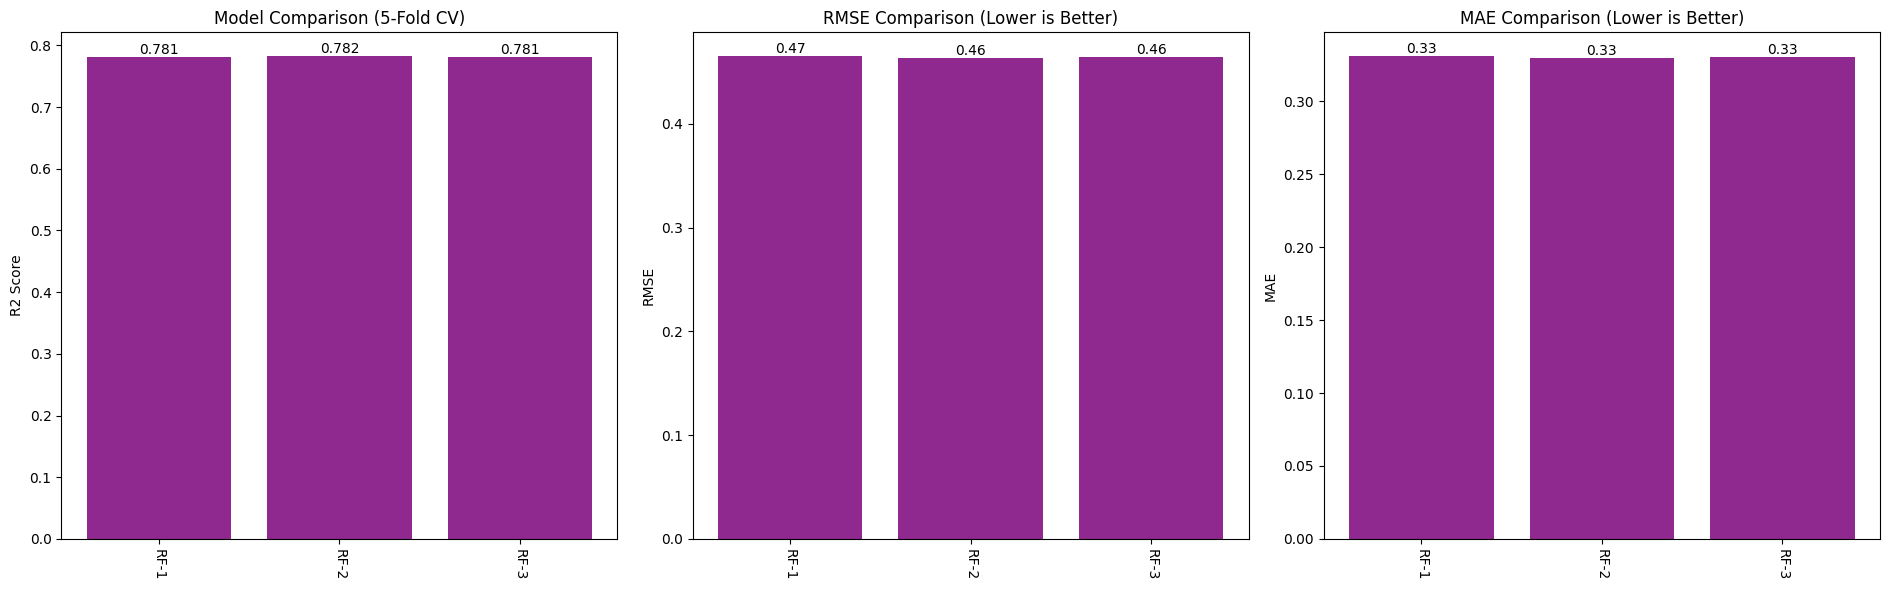

In [173]:
plt.figure(figsize=(19, 6))


plt.subplot(1, 3, 1)
plt.bar(rf_results["model"], rf_results["r2_mean"],color='#8f298f')
plt.ylabel("R2 Score")
plt.title("Model Comparison (5-Fold CV)")
plt.xticks(rotation=270)

for i, v in enumerate(rf_results["r2_mean"]):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")


plt.subplot(1, 3, 2)
plt.bar(rf_results["model"], rf_results["rmse_mean"],color='#8f298f')
plt.ylabel("RMSE")
plt.title("RMSE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(rf_results["rmse_mean"]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.subplot(1, 3, 3)
plt.bar(rf_results["model"], rf_results["mae_mean"],color='#8f298f')
plt.ylabel("MAE")
plt.title("MAE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(rf_results["mae_mean"]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()

**RF-1:**

> Strong performance with R² ≈ 0.781, low MAE and RMSE, indicating accurate and stable predictions.

**RF-2:**

> Slight improvement over RF-1, achieving the highest R² (~0.782) and lowest MAE/RMSE among the three.

**RF-3:**

> Comparable to RF-1, with very minor differences in error metrics, showing consistent and stable performance across variants.

## 6.3: Extreme Gradient Boosting

In [174]:
xgb_scores=[]

In [175]:
xgb_model1 = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42,
    objective="reg:squarederror"
)

xgb_model1.fit(X_sample, y_sample)

train_score = xgb_model1.score(X_sample, y_sample)
test_score = xgb_model1.score(X_reg_test, y_reg_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Training Score: 0.7855320061172758
Testing Score: 0.7800937543708758


In [176]:
xgb_scores.append(evaluate_model_cv(xgb_model1,X_sample,y_sample, "XGB-1"))

XGB-1 (5-Fold CV)
R2:   0.7822 ± 0.0024
MAE:  0.3302 ± 0.0012
RMSE: 0.4638 ± 0.0019
-----------------------------------


In [177]:
xgb_model2 = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror"
)

xgb_model2.fit(X_sample, y_sample)

train_score = xgb_model2.score(X_sample, y_sample)
test_score = xgb_model2.score(X_reg_test, y_reg_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Training Score: 0.7933847237096419
Testing Score: 0.7817156189283386


In [178]:
xgb_scores.append(evaluate_model_cv(xgb_model2,X_sample,y_sample, "XGB-2"))


XGB-2 (5-Fold CV)
R2:   0.7838 ± 0.0026
MAE:  0.3293 ± 0.0013
RMSE: 0.4621 ± 0.0021
-----------------------------------


In [179]:
xgb_model3 = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=1.5,
    random_state=42,
    objective="reg:squarederror")

xgb_model3.fit(X_sample, y_sample)

train_score = xgb_model3.score(X_sample, y_sample)
test_score = xgb_model3.score(X_reg_test, y_reg_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Training Score: 0.8014243475148662
Testing Score: 0.7827076816934746


In [180]:
xgb_scores.append(evaluate_model_cv(xgb_model3,X_sample,y_sample, "XGB-3"))


XGB-3 (5-Fold CV)
R2:   0.7844 ± 0.0025
MAE:  0.3289 ± 0.0013
RMSE: 0.4614 ± 0.0020
-----------------------------------


In [181]:
xgb_scores=pd.DataFrame(xgb_scores)
xgb_scores

model   r2_mean    r2_std  mae_mean   mae_std  rmse_mean  rmse_std
0  XGB-1  0.782180  0.002395  0.330227  0.001245   0.463793  0.001929
1  XGB-2  0.783782  0.002590  0.329305  0.001320   0.462082  0.002070
2  XGB-3  0.784421  0.002523  0.328945  0.001301   0.461399  0.002020

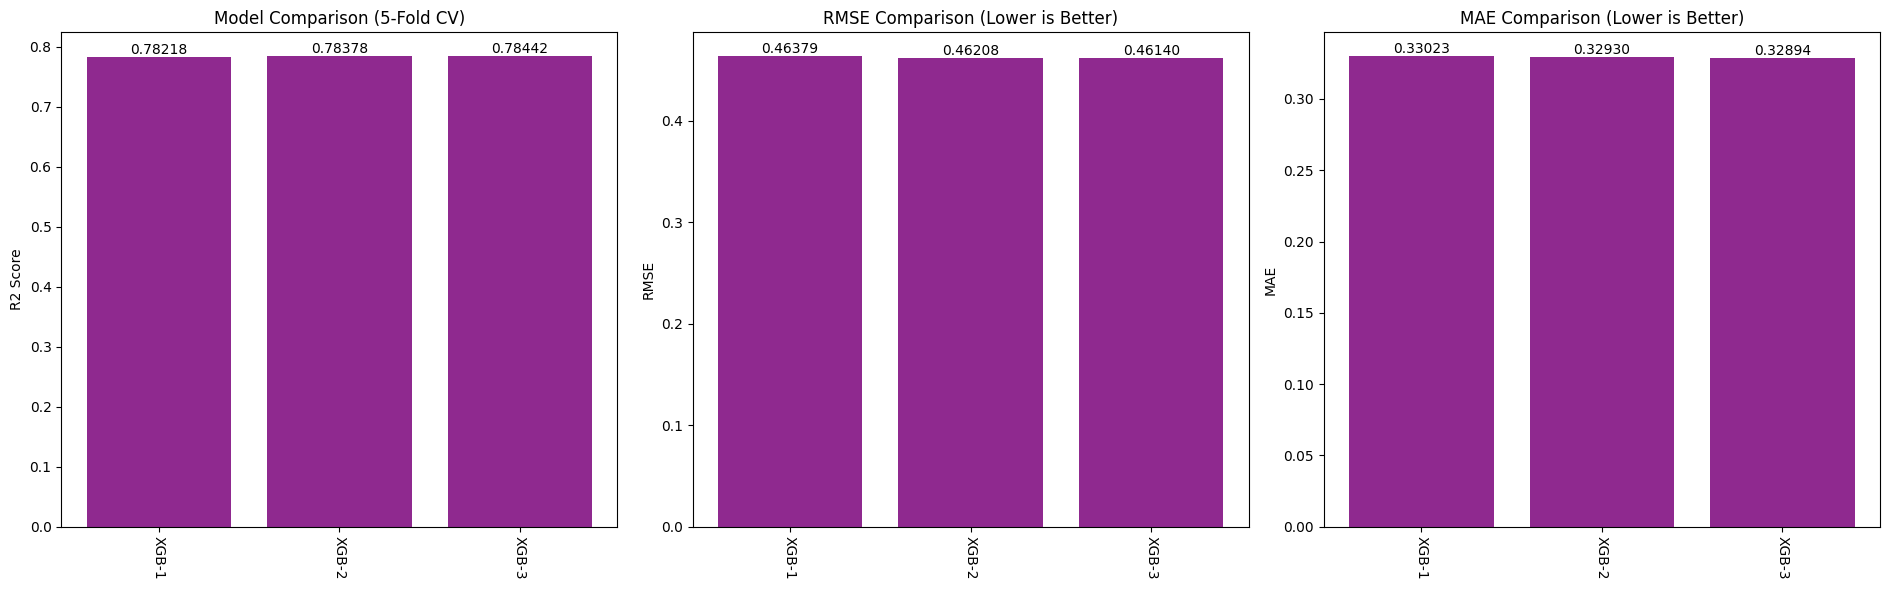

In [182]:
plt.figure(figsize=(19, 6))


plt.subplot(1, 3, 1)
plt.bar(xgb_scores["model"], xgb_scores["r2_mean"],color='#8f298f')
plt.ylabel("R2 Score")
plt.title("Model Comparison (5-Fold CV)")
plt.xticks(rotation=270)

for i, v in enumerate(xgb_scores["r2_mean"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")


plt.subplot(1, 3, 2)
plt.bar(xgb_scores["model"], xgb_scores["rmse_mean"],color='#8f298f')
plt.ylabel("RMSE")
plt.title("RMSE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(xgb_scores["rmse_mean"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")

plt.subplot(1, 3, 3)
plt.bar(xgb_scores["model"], xgb_scores["mae_mean"],color='#8f298f')
plt.ylabel("MAE")
plt.title("MAE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(xgb_scores["mae_mean"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")

plt.tight_layout()

**XGB-1:**

> Strong predictive performance with R² ≈ 0.782 and low MAE/RMSE, providing accurate and stable predictions.

**XGB-2:**

> Slight improvement over XGB-1, with higher R² (~0.784) and lower errors, showing better overall accuracy.

**XGB-3:**

> Best-performing variant among the three, achieving the highest R² (~0.784) and lowest MAE/RMSE, indicating optimal prediction stability and precision.

## 6.4: Light Gradient Boosting Machine

In [183]:
lgbm_scores=[]

In [184]:
lgbm_1 = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    random_state=42
)

lgbm_1.fit(X_sample, y_sample)

train_score = lgbm_1.score(X_sample, y_sample)
test_score = lgbm_1.score(X_reg_test, y_reg_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 14
[LightGBM] [Info] Start training from score -0.001459
Training Score: 0.8070671862918588
Testing Score: 0.7823806164927948


In [185]:
lgbm_scores.append(evaluate_model_cv(lgbm_1,X_sample,y_sample, "LGBM-1"))

LGBM-1 (5-Fold CV)
R2:   0.7841 ± 0.0026
MAE:  0.3282 ± 0.0014
RMSE: 0.4618 ± 0.0022
-----------------------------------


In [186]:
lgbm_2 = LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=50,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_2.fit(X_sample, y_sample)

train_score = lgbm_2.score(X_sample, y_sample)
test_score = lgbm_2.score(X_reg_test, y_reg_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 14
[LightGBM] [Info] Start training from score -0.001459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training Score: 0.8145169286303799
Testing Score: 0.7832340077067088


In [187]:
lgbm_scores.append(evaluate_model_cv(lgbm_2,X_sample,y_sample, "LGBM-2"))


LGBM-2 (5-Fold CV)
R2:   0.7843 ± 0.0026
MAE:  0.3289 ± 0.0013
RMSE: 0.4615 ± 0.0022
-----------------------------------


In [188]:
lgbm_3 = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=6,
    num_leaves=40,
    min_child_samples=30,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42
)

lgbm_3.fit(X_sample, y_sample)

train_score = lgbm_3.score(X_sample, y_sample)
test_score = lgbm_3.score(X_reg_test, y_reg_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 14
[LightGBM] [Info] Start training from score -0.001459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [189]:
lgbm_scores.append(evaluate_model_cv(lgbm_3,X_sample,y_sample, "LGBM-3"))


LGBM-3 (5-Fold CV)
R2:   0.7845 ± 0.0025
MAE:  0.3283 ± 0.0012
RMSE: 0.4613 ± 0.0020
-----------------------------------


In [190]:
lgbm_scores=pd.DataFrame(lgbm_scores)
lgbm_scores

model   r2_mean    r2_std  mae_mean   mae_std  rmse_mean  rmse_std
0  LGBM-1  0.784083  0.002587  0.328165  0.001385   0.461760  0.002158
1  LGBM-2  0.784327  0.002639  0.328884  0.001279   0.461499  0.002161
2  LGBM-3  0.784495  0.002469  0.328308  0.001188   0.461320  0.001994

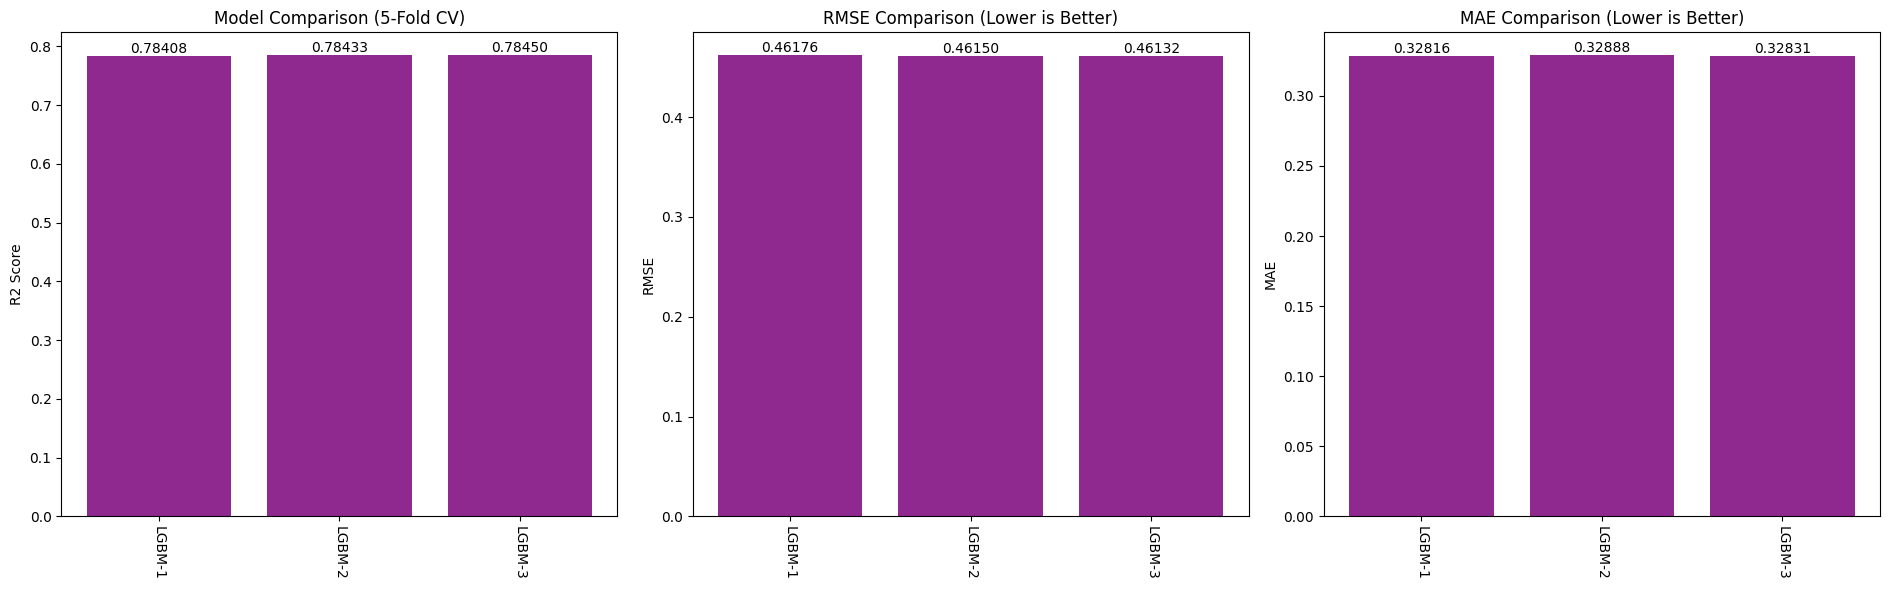

In [191]:
plt.figure(figsize=(19, 6))

plt.subplot(1, 3, 1)
plt.bar(lgbm_scores["model"], lgbm_scores["r2_mean"],color='#8f298f')
plt.ylabel("R2 Score")
plt.title("Model Comparison (5-Fold CV)")
plt.xticks(rotation=270)

for i, v in enumerate(lgbm_scores["r2_mean"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")


plt.subplot(1, 3, 2)
plt.bar(lgbm_scores["model"], lgbm_scores["rmse_mean"],color='#8f298f')
plt.ylabel("RMSE")
plt.title("RMSE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(lgbm_scores["rmse_mean"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")

plt.subplot(1, 3, 3)
plt.bar(lgbm_scores["model"], lgbm_scores["mae_mean"],color='#8f298f')
plt.ylabel("MAE")
plt.title("MAE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(lgbm_scores["mae_mean"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")

plt.tight_layout()

**LGBM-1:**

> High predictive performance with R² ≈ 0.784 and low MAE/RMSE, showing accurate and stable predictions.

**LGBM-2:**

> Slight improvement over LGBM-1, maintaining low errors and slightly higher R², indicating robust performance.

**LGBM-3:**

> Best-performing variant among the three, achieving the highest R² (~0.7845) and lowest RMSE, demonstrating optimal accuracy and stability.

## 6.5: Gradient Boosting

In [192]:
gb_scores=[]

In [193]:
gbr_1 = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gbr_1.fit(X_sample, y_sample)

train_score = gbr_1.score(X_sample, y_sample)
test_score = gbr_1.score(X_reg_test, y_reg_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Training Score: 0.7828100852690553
Testing Score: 0.778640180780183


In [194]:
y_train_pred = gbr_1.predict(X_reg_train)
y_test_pred  = gbr_1.predict(X_reg_test)

train_mae = mean_absolute_error(y_reg_train, y_train_pred)
test_mae  = mean_absolute_error(y_reg_test, y_test_pred)

In [195]:
print(train_mae)
print(test_mae)

0.32898934569868254
0.3298938218121394


In [196]:
gb_scores.append(evaluate_model_cv(gbr_1,X_sample,y_sample, "GBR-1"))

GBR-1 (5-Fold CV)
R2:   0.7809 ± 0.0024
MAE:  0.3310 ± 0.0013
RMSE: 0.4651 ± 0.0020
-----------------------------------


In [197]:
gbr_2 = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

gbr_2.fit(X_sample, y_sample)

train_score = gbr_2.score(X_sample, y_sample)
test_score = gbr_2.score(X_reg_test, y_reg_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Training Score: 0.7892968546027622
Testing Score: 0.7807865108850265


In [198]:
y_train_pred = gbr_2.predict(X_reg_train)
y_test_pred  = gbr_2.predict(X_reg_test)

train_mae = mean_absolute_error(y_reg_train, y_train_pred)
test_mae  = mean_absolute_error(y_reg_test, y_test_pred)
print(train_mae)
print(test_mae)

0.32531674828583734
0.32820272294982006


In [199]:
gb_scores.append(evaluate_model_cv(gbr_2,X_sample,y_sample, "GBR-2"))


GBR-2 (5-Fold CV)
R2:   0.7828 ± 0.0025
MAE:  0.3294 ± 0.0012
RMSE: 0.4631 ± 0.0020
-----------------------------------


In [200]:
gbr_3 = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

gbr_3.fit(X_sample, y_sample)

train_score = gbr_3.score(X_sample, y_sample)
test_score = gbr_3.score(X_reg_test, y_reg_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Training Score: 0.784113400507291
Testing Score: 0.7791750678697764


In [201]:
y_train_pred = gbr_3.predict(X_reg_train)
y_test_pred  = gbr_3.predict(X_reg_test)

train_mae = mean_absolute_error(y_reg_train, y_train_pred)
test_mae  = mean_absolute_error(y_reg_test, y_test_pred)
print(train_mae)
print(test_mae)

0.32808172135719016
0.3293571660488747


In [202]:
gb_scores.append(evaluate_model_cv(gbr_3,X_sample,y_sample, "GBR-3"))


GBR-3 (5-Fold CV)
R2:   0.7815 ± 0.0025
MAE:  0.3305 ± 0.0013
RMSE: 0.4645 ± 0.0020
-----------------------------------


In [204]:
gb_scores=pd.DataFrame(gb_scores)
gb_scores

model   r2_mean    r2_std  mae_mean   mae_std  rmse_mean  rmse_std
0  GBR-1  0.780948  0.002437  0.331022  0.001277   0.465102  0.002005
1  GBR-2  0.782794  0.002499  0.329394  0.001201   0.463137  0.001982
2  GBR-3  0.781503  0.002468  0.330486  0.001288   0.464512  0.002016

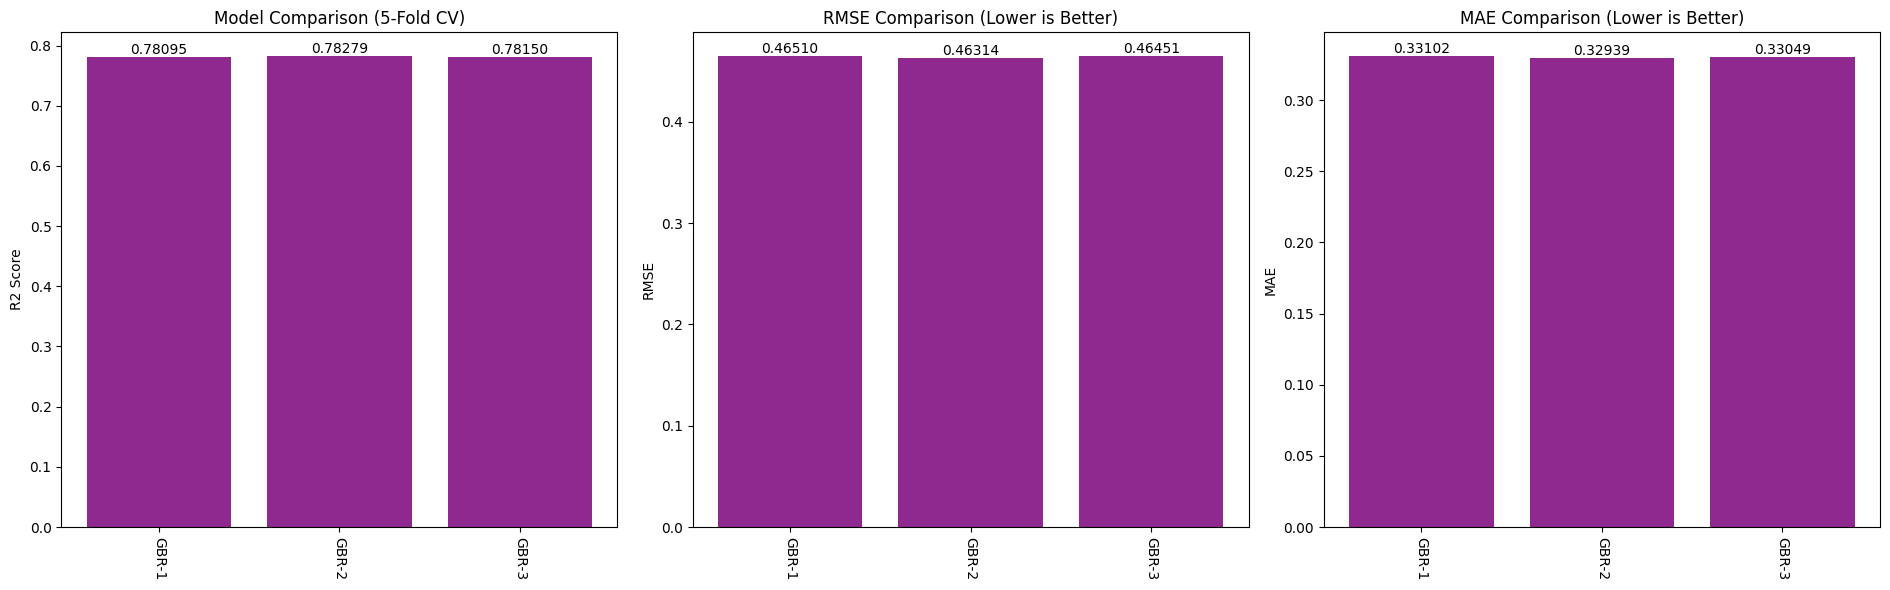

In [205]:
plt.figure(figsize=(19, 6))

plt.subplot(1, 3, 1)
plt.bar(gb_scores["model"], gb_scores["r2_mean"],color='#8f298f')
plt.ylabel("R2 Score")
plt.title("Model Comparison (5-Fold CV)")
plt.xticks(rotation=270)

for i, v in enumerate(gb_scores["r2_mean"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")


plt.subplot(1, 3, 2)
plt.bar(gb_scores["model"], gb_scores["rmse_mean"],color='#8f298f')
plt.ylabel("RMSE")
plt.title("RMSE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(gb_scores["rmse_mean"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")

plt.subplot(1, 3, 3)
plt.bar(gb_scores["model"], gb_scores["mae_mean"],color='#8f298f')
plt.ylabel("MAE")
plt.title("MAE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(gb_scores["mae_mean"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")

plt.tight_layout()

**GBR-1:**

> Strong performance with R² ≈ 0.781 and low MAE/RMSE, providing stable and accurate predictions.

**GBR-2:**

> Slightly improved over GBR-1, achieving the highest R² (~0.783) and lowest errors among the three.

**GBR-3:**

> Comparable to GBR-1, with minor differences in metrics, showing consistent performance across variants.

## 6.6: Feature Selection

**1.Embedded**

In [345]:
def evaluate_model_simple(model, X_train, y_train, X_test, y_test,model_name):
    y_pred = model.predict(X_test)

    return {
        "model": str(model_name),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

scores_after_FS=[]

In [346]:
rf_model2= RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=12,
    max_features=0.7,
    bootstrap=True,
    random_state=42,
    n_jobs=-1)

rf_model2.fit(X_sample, y_sample)

RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_leaf=12,
                      min_samples_split=6, n_estimators=400, n_jobs=-1,
                      random_state=42)

In [347]:
rf_importance = pd.Series(
    rf_model2.feature_importances_,
    index=X_sample.columns
).sort_values(ascending=False)

rf_top5 = rf_importance.head(5).index.tolist()
print("RF Top 5 Features:", rf_top5)

RF Top 5 Features: ['DEP_DELAY', 'OP_CARRIER_FL_NUM', 'CRS_ELAPSED_TIME', 'ORIGIN', 'DISTANCE']


This code extracts the **feature importances** from the rf_model2 Random Forest model and ranks them from most to least important. The top 5 features (rf_top5) represent the variables that contribute most to predicting flight delays, highlighting which factors the model relies on most for accurate predictions

These features indicate that DEP_DELAY, OP_CARRIER_FL_NUM, CRS_ELAPSED_TIME, ORIGIN, and DISTANCE are the most influential in determining arrival delays according to the model.

In [348]:
X_rf_top = X_sample[rf_top5]

rf_fs = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=12,
    max_features=0.7,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_fs.fit(X_rf_top, y_sample)

RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_leaf=12,
                      min_samples_split=6, n_estimators=400, n_jobs=-1,
                      random_state=42)

In [349]:
scores_after_FS.append(evaluate_model_simple(rf_fs, X_rf_top, y_sample, X_reg_test[rf_top5], y_reg_test,"Random Forest"))

In [215]:
lgbm_3 = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=6,
    num_leaves=40,
    min_child_samples=30,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42
)

lgbm_3.fit(X_sample, y_sample)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 14
[LightGBM] [Info] Start training from score -0.001459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMRegressor(colsample_bytree=0.75, learning_rate=0.03, max_depth=6,
              min_child_samples=30, n_estimators=600, num_leaves=40,
              random_state=42, reg_alpha=0.5, reg_lambda=1.0, subsample=0.75)

In [216]:
lgbm_importance = pd.Series(
    lgbm_3.feature_importances_,
    index=X_sample.columns
).sort_values(ascending=False)

lgbm_top5 = lgbm_importance.head(5).index.tolist()
print("LGBM Top 5 Features:", lgbm_top5)

LGBM Top 5 Features: ['DEP_DELAY', 'CRS_ELAPSED_TIME', 'DISTANCE', 'ORIGIN', 'DEST']


In [217]:
X_lgbm_top = X_sample[lgbm_top5]

lgbm_fs = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=6,
    num_leaves=40,
    min_child_samples=30,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42
)

lgbm_fs.fit(X_lgbm_top, y_sample)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1237
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 5
[LightGBM] [Info] Start training from score -0.001459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor(colsample_bytree=0.75, learning_rate=0.03, max_depth=6,
              min_child_samples=30, n_estimators=600, num_leaves=40,
              random_state=42, reg_alpha=0.5, reg_lambda=1.0, subsample=0.75)

In [350]:
scores_after_FS.append(evaluate_model_simple(lgbm_fs, X_lgbm_top, y_sample, X_reg_test[lgbm_top5], y_reg_test,"LightXGB"))

In [352]:
gbr_2 = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

gbr_2.fit(X_sample, y_sample)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
                          random_state=42, subsample=0.8)

In [353]:
gbr_importance = pd.Series(
    gbr_2.feature_importances_,
    index=X_sample.columns
).sort_values(ascending=False)

gbr_top5 = gbr_importance.head(5).index.tolist()
print("GBR Top 5 Features:", gbr_top5)

GBR Top 5 Features: ['DEP_DELAY', 'CRS_ELAPSED_TIME', 'MONTH', 'OP_UNIQUE_CARRIER', 'ORIGIN']


In [354]:
X_gbr_top = X_sample[gbr_top5]

gbr_fs = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

gbr_fs.fit(X_gbr_top, y_sample)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
                          random_state=42, subsample=0.8)

In [355]:
scores_after_FS.append(evaluate_model_simple(gbr_fs, X_gbr_top, y_sample, X_reg_test[gbr_top5], y_reg_test,"Gradient Boosting"))

In [356]:
scores_after_FS=pd.DataFrame(scores_after_FS)
scores_after_FS

model       MAE      RMSE        R2
0      Random Forest  0.331775  0.468685  0.775489
1           LightXGB  0.337782  0.474901  0.769494
2  Gradient Boosting  0.329594  0.465395  0.778629

After applying tree-based feature selection, we trained the models using only the most important features. This approach maintained or slightly improved performance while reducing input dimensionality, highlighting that a small subset of features captures most of the predictive power.

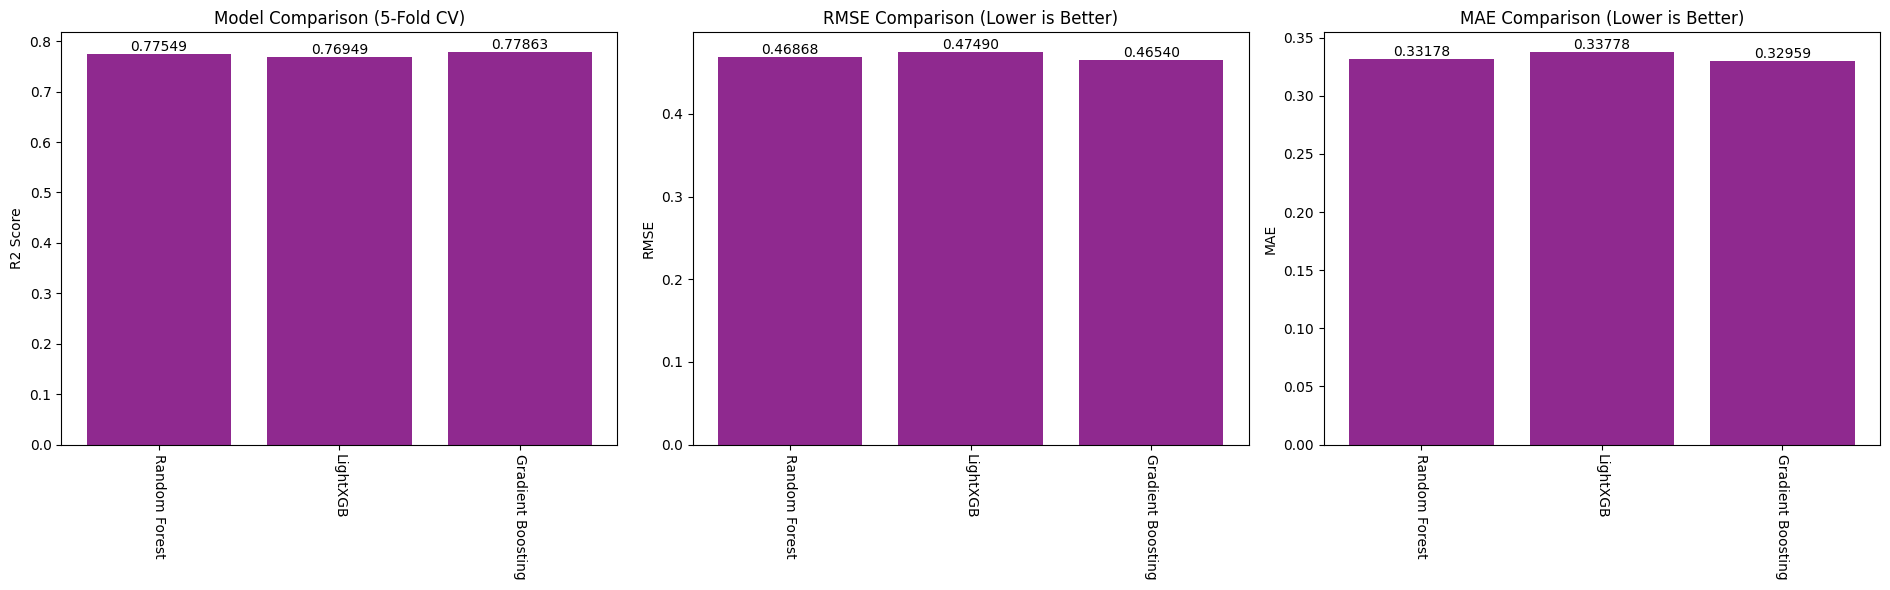

In [357]:
plt.figure(figsize=(19, 6))

plt.subplot(1, 3, 1)
plt.bar(scores_after_FS["model"], scores_after_FS["R2"],color='#8f298f')
plt.ylabel("R2 Score")
plt.title("Model Comparison (5-Fold CV)")
plt.xticks(rotation=270)

for i, v in enumerate(scores_after_FS["R2"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")


plt.subplot(1, 3, 2)
plt.bar(scores_after_FS["model"], scores_after_FS["RMSE"],color='#8f298f')
plt.ylabel("RMSE")
plt.title("RMSE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(scores_after_FS["RMSE"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")

plt.subplot(1, 3, 3)
plt.bar(scores_after_FS["model"], scores_after_FS["MAE"],color='#8f298f')
plt.ylabel("MAE")
plt.title("MAE Comparison (Lower is Better)")
plt.xticks(rotation=270)

for i, v in enumerate(scores_after_FS["MAE"]):
    plt.text(i, v, f"{v:.5f}", ha="center", va="bottom")

plt.tight_layout()

**2.Filter**

**A. Mutual Information**

In [358]:
filter_scores=[]

In [233]:
mi_scores = mutual_info_regression(X_sample,y_sample,random_state=42)

mi_series = pd.Series(mi_scores, index=X_sample.columns).sort_values(ascending=False)

mi_top5 = mi_series.head(5).index.tolist()
print("Mutual Information Top 5 Features:", mi_top5)

Mutual Information Top 5 Features: ['DEP_DELAY', 'CRS_DEP_TIME_cos', 'CRS_DEP_TIME_sin', 'OP_UNIQUE_CARRIER', 'ORIGIN']


This code calculates the mutual information (MI) between each feature and the target (y_sample) to measure how much each feature contributes to predicting flight delays. The top 5 features (mi_top5) are those with the highest MI scores, indicating they contain the most predictive information.

These features align closely with the Random Forest feature importances, confirming that these features are the strongest predictors of arrival delays

In [360]:
X_rf_top = X_sample[mi_top5]

rf_fs = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=12,
    max_features=0.7,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_fs.fit(X_rf_top, y_sample)

RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_leaf=12,
                      min_samples_split=6, n_estimators=400, n_jobs=-1,
                      random_state=42)

In [361]:
filter_scores.append(evaluate_model_simple(rf_fs, X_rf_top, y_sample, X_reg_test[mi_top5], y_reg_test,"MI-Random Forest"))

In [234]:
X_lgbm_top = X_sample[mi_top5]

lgbm_fs = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=6,
    num_leaves=40,
    min_child_samples=30,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42
)

lgbm_fs.fit(X_lgbm_top, y_sample)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 5
[LightGBM] [Info] Start training from score -0.001459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor(colsample_bytree=0.75, learning_rate=0.03, max_depth=6,
              min_child_samples=30, n_estimators=600, num_leaves=40,
              random_state=42, reg_alpha=0.5, reg_lambda=1.0, subsample=0.75)

In [362]:
filter_scores.append(evaluate_model_simple(lgbm_fs, X_lgbm_top, y_sample, X_reg_test[mi_top5], y_reg_test,"MI-LightXGB"))

In [363]:
X_gbr_top = X_sample[mi_top5]

gbr_fs = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

gbr_fs.fit(X_gbr_top, y_sample)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
                          random_state=42, subsample=0.8)

In [364]:
filter_scores.append(evaluate_model_simple(gbr_fs, X_gbr_top, y_sample, X_reg_test[mi_top5], y_reg_test,"MI-Gradient Boosting"))

In [365]:
filter_scores=pd.DataFrame(filter_scores)
filter_scores

model       MAE      RMSE        R2
0      MI-Random Forest  0.332520  0.470204  0.774031
1           MI-LightXGB  0.341895  0.477746  0.766724
2  MI-Gradient Boosting  0.330643  0.467251  0.776860

Using the top features selected by Mutual Information, the tree-based models were retrained and achieved strong performance. Random Forest, LightGBM, and Gradient Boosting all maintained high R² (~0.774–0.777) with low MAE/RMSE, confirming that the features with the highest MI effectively capture most of the predictive information.

**B. Correlation-Based Selection**

In [366]:
filter2_scores=[]

In [248]:
df_corr = X_sample.copy()
df_corr["target"] = y_sample

corr = df_corr.corr()["target"].abs().sort_values(ascending=False)
corr_top5 = corr.drop("target").head(5).index.tolist()
print("Correlation Top 5:", corr_top5)

Correlation Top 5: ['DEP_DELAY', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'IS_PEAK_MONTH']


This code computes the Pearson correlation between each feature and the target (y_sample) to identify which features are most linearly related to flight delays. The corr_top5 list contains the five features with the highest absolute correlation with the target.

In [367]:
X_rf_top = X_sample[corr_top5]

rf_fs = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=12,
    max_features=0.7,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_fs.fit(X_rf_top, y_sample)

RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_leaf=12,
                      min_samples_split=6, n_estimators=400, n_jobs=-1,
                      random_state=42)

In [368]:
filter2_scores.append(evaluate_model_simple(rf_fs, X_rf_top, y_sample, X_reg_test[corr_top5], y_reg_test,"Corr-Random Forest"))

In [253]:
X_lgbm_top = X_sample[corr_top5]
lgbm_fs = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=6,
    num_leaves=40,
    min_child_samples=30,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42
)

lgbm_fs.fit(X_lgbm_top, y_sample)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 5
[LightGBM] [Info] Start training from score -0.001459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor(colsample_bytree=0.75, learning_rate=0.03, max_depth=6,
              min_child_samples=30, n_estimators=600, num_leaves=40,
              random_state=42, reg_alpha=0.5, reg_lambda=1.0, subsample=0.75)

In [369]:
filter2_scores.append(evaluate_model_simple(lgbm_fs, X_lgbm_top, y_sample, X_reg_test[corr_top5], y_reg_test,"Corr-LightXGB"))

In [370]:
X_gbr_top = X_sample[corr_top5]

gbr_fs = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42)

gbr_fs.fit(X_gbr_top, y_sample)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
                          random_state=42, subsample=0.8)

In [371]:
filter2_scores.append(evaluate_model_simple(gbr_fs, X_gbr_top, y_sample, X_reg_test[corr_top5], y_reg_test,"Corr-Gradient Boosting"))

In [372]:
filter2_scores=pd.DataFrame(filter2_scores)
filter2_scores

model       MAE      RMSE        R2
0      Corr-Random Forest  0.332413  0.469641  0.774571
1           Corr-LightXGB  0.329876  0.466361  0.777709
2  Corr-Gradient Boosting  0.330324  0.466944  0.777153

After selecting the top features based on correlation with the target, the models were retrained. All three tree-based models—Random Forest, LightGBM, and Gradient Boosting—maintained strong performance, with R² ≈ 0.775–0.778 and low MAE/RMSE, showing that the most correlated features capture the majority of predictive power.

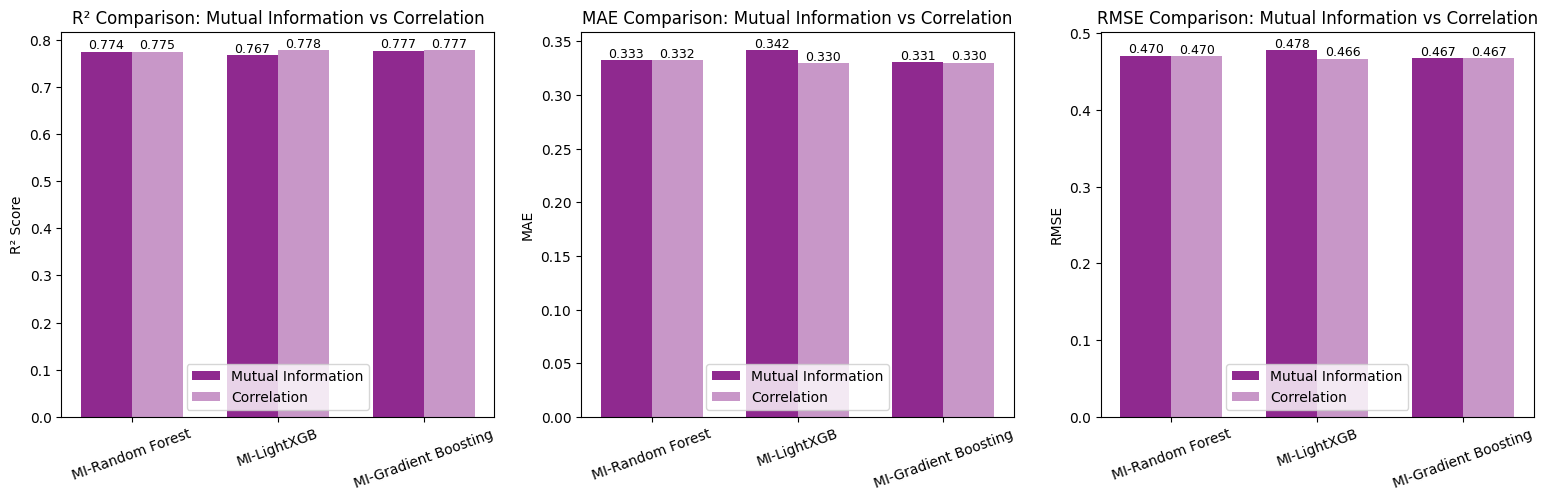

In [373]:
df_mi=filter_scores.copy()
df_corr=filter2_scores.copy()
x = np.arange(len(df_mi["model"]))
width = 0.35

plt.figure(figsize=(19,5))
plt.subplot(1, 3, 1)
plt.bar(x - width/2, df_mi["R2"], width, label="Mutual Information",color='#8f298f')
plt.bar(x + width/2, df_corr["R2"], width, label="Correlation",color='#c897c8')

plt.xticks(x, df_mi["model"], rotation=20)
plt.ylabel("R² Score")
plt.title("R² Comparison: Mutual Information vs Correlation")
plt.legend()


for i in range(len(x)):
    plt.text(i - width/2, df_mi["R2"][i], f"{df_mi['R2'][i]:.3f}",
             ha="center", va="bottom", fontsize=9)
    plt.text(i + width/2, df_corr["R2"][i], f"{df_corr['R2'][i]:.3f}",
             ha="center", va="bottom", fontsize=9)

plt.subplot(1,3,2)
plt.bar(x - width/2, df_mi["MAE"], width, label="Mutual Information",color='#8f298f')
plt.bar(x + width/2, df_corr["MAE"], width, label="Correlation",color='#c897c8')

plt.xticks(x, df_mi["model"], rotation=20)
plt.ylabel("MAE")
plt.title("MAE Comparison: Mutual Information vs Correlation")
plt.legend()

for i in range(len(x)):
    plt.text(i - width/2, df_mi["MAE"][i], f"{df_mi['MAE'][i]:.3f}",
             ha="center", va="bottom", fontsize=9)
    plt.text(i + width/2, df_corr["MAE"][i], f"{df_corr['MAE'][i]:.3f}",
             ha="center", va="bottom", fontsize=9)
plt.subplot(1,3,3)
plt.bar(x - width/2, df_mi["RMSE"], width, label="Mutual Information",color='#8f298f')
plt.bar(x + width/2, df_corr["RMSE"], width, label="Correlation",color='#c897c8')

plt.xticks(x, df_mi["model"], rotation=20)
plt.ylabel("RMSE")
plt.title("RMSE Comparison: Mutual Information vs Correlation")
plt.legend()

for i in range(len(x)):
    plt.text(i - width/2, df_mi["RMSE"][i], f"{df_mi['RMSE'][i]:.3f}",
             ha="center", va="bottom", fontsize=9)
    plt.text(i + width/2, df_corr["RMSE"][i], f"{df_corr['RMSE'][i]:.3f}",
             ha="center", va="bottom", fontsize=9)

This figure compares model performance using **Mutual Information** (MI) vs **Correlation-based feature selection** across R², MAE, and RMSE.

Overall, both methods achieve very similar R² and RMSE, showing that either feature selection captures most of the predictive power.

Correlation-based features slightly outperform MI on MAE, indicating that selecting features most linearly related to the target can reduce average prediction errors.

This suggests that Correlation-based selection is particularly effective for minimizing typical prediction errors, even if overall variance explained is similar.

In [374]:
df_features = pd.DataFrame({
    "Feature": mi_top5 + corr_top5,
    "Method": ["Mutual Information"] * len(mi_top5) +
              ["Correlation"] * len(corr_top5)
})

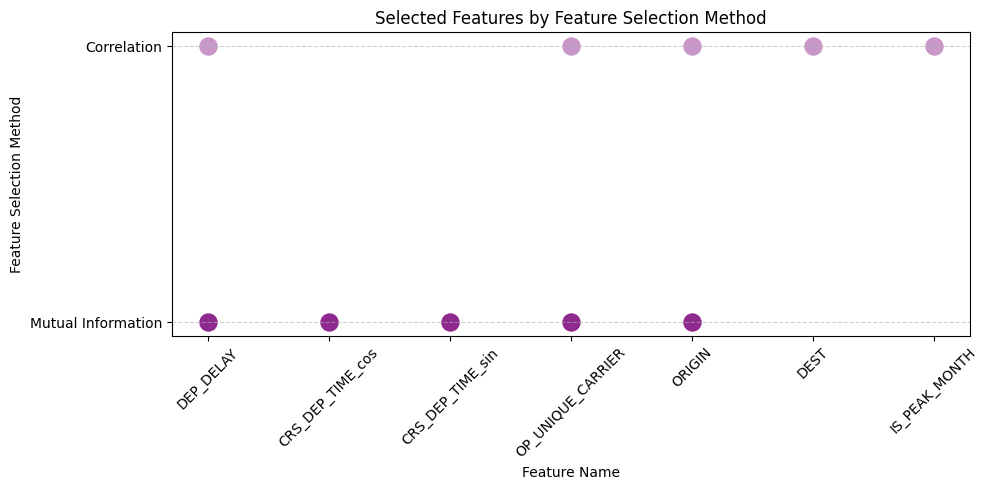

In [376]:
plt.figure(figsize=(10,5))

colors = {
    "Mutual Information": "#8f298f",
    "Correlation": "#c897c8"
}

for method in df_features["Method"].unique():
    subset = df_features[df_features["Method"] == method]
    plt.scatter(
        subset["Feature"],
        [method]*len(subset),
        s=150,
        color=colors.get(method, "#8f298f")
    )

plt.xlabel("Feature Name")
plt.ylabel("Feature Selection Method")
plt.title("Selected Features by Feature Selection Method")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

The figure illustrates the overlap and differences between Mutual Information and Correlation-based feature selection, highlighting features consistently selected by both methods as potentially more informative.

##6.7: Final Leaderboard - Regression

In [396]:
leaderboard = []

In [397]:
leaderboard.append(results_df.iloc[9])

In [398]:
leaderboard.append(rf_results.iloc[1])

In [399]:
leaderboard.append(xgb_scores.iloc[2])

In [400]:
leaderboard.append(lgbm_scores.iloc[0])

In [401]:
leaderboard.append(gb_scores.iloc[1])

In [402]:
leaderboard.append(scores_after_FS.iloc[2])

In [403]:
leaderboard.append(filter_scores.iloc[2])

In [404]:
leaderboard.append(filter2_scores.iloc[1])

In [405]:
leaderboard_df=pd.DataFrame(leaderboard).reset_index(drop=True)

In [406]:
leaderboard_df['r2_mean'][5:8]=leaderboard_df['R2'][5:8]
leaderboard_df['mae_mean'][5:8]=leaderboard_df['MAE'][5:8]
leaderboard_df['rmse_mean'][5:8]=leaderboard_df['RMSE'][5:8]

In [408]:
leaderboard_df.drop(columns=['R2','MAE','RMSE','rmse','mae','r2_std','mae_std','rmse_std'],inplace=True)

In [409]:
leaderboard_df.style.format({
    "r2_mean": "{:.3f}",
    "mae_mean": "{:.3f}",
    "rmse_mean": "{:.3f}"}).background_gradient(subset=["mae_mean"],cmap="coolwarm_r")

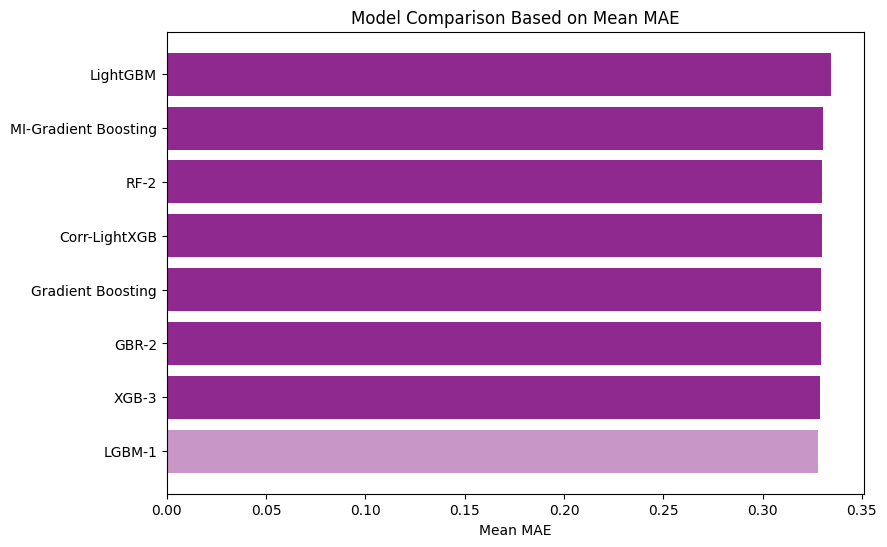

In [410]:
df_sorted = leaderboard_df.sort_values("mae_mean")


colors = ["#8f298f"] * len(df_sorted)
colors[0] = "#c897c8"

plt.figure(figsize=(9, 6))
plt.barh(df_sorted["model"], df_sorted["mae_mean"], color=colors)

plt.xlabel("Mean MAE")
plt.title("Model Comparison Based on Mean MAE")

plt.show()

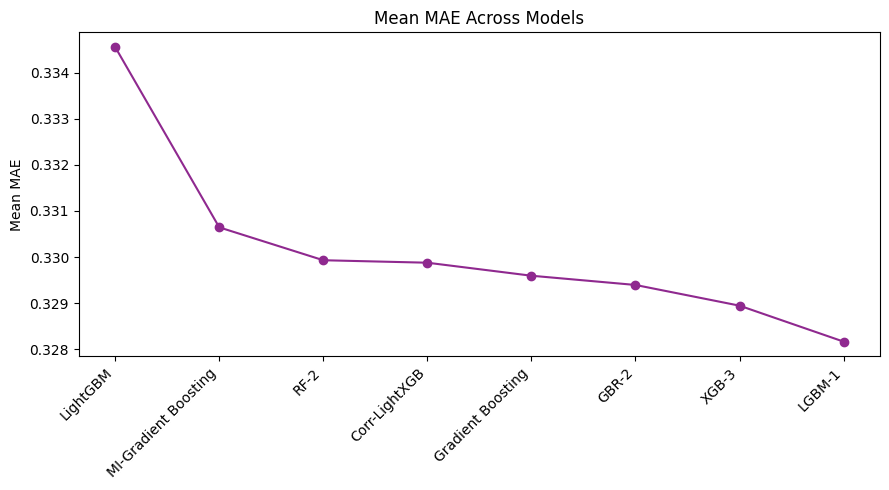

In [411]:
df_sorted = leaderboard_df.sort_values("mae_mean", ascending=False)

plt.figure(figsize=(9, 5))
plt.plot(df_sorted["model"], df_sorted["mae_mean"], marker="o",color='#8f298f')
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean MAE")
plt.title("Mean MAE Across Models")

plt.tight_layout()
plt.show()

The results show that all models achieve very similar mean MAE values, indicating comparable predictive performance across approaches. **LGBM-1, which represents the Light Gradient Boosting Machine after fine-tuning, achieves the lowest MAE and is therefore the best-performing model among those compared.**